In [1]:
# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.7834769413661389
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:32
# learning_rate:0.007176761798504128
# pre_spike_weight:5.165214142219577
# rate_coding:true
# TIME_STEP:9
# time_step:9
# v_decay:0.7834769413661389
# v_reset:0
# v_threshold:1
# which_data:"CIFAR10"


# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.38993471232202725
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.06285718352377828
# pre_spike_weight:6.21970124592063
# rate_coding:true
# TIME_STEP:16
# time_step:16
# v_decay:0.38993471232202725
# v_reset:0
# v_threshold:1
# which_data:"MNIST"

# BATCH:64
# batch_size:64
# data_path:"/data2"
# decay:0.9266077968579136
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.07732456724854177
# pre_spike_weight:1.5377416716615555
# rate_coding:true
# TIME_STEP:7
# time_step:7
# v_decay:0.9266077968579136
# v_reset:0
# v_threshold:1
# which_data:"FASHION_MNIST"

In [2]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt


from snntorch import spikegen

 
import wandb

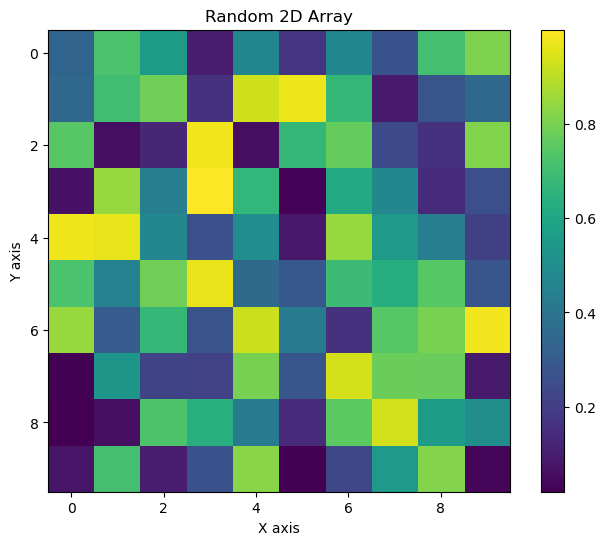

In [4]:
# my module import
from modules import *

In [5]:
    
class RESERVOIR(nn.Module):
    def __init__ (self, TIME_STEP=8, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1):
        super(RESERVOIR, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.in_spike_size = in_spike_size
        self.in_channel = in_channel
        self.receptive_size = receptive_size #3
        self.v_init = v_init
        self.v_decay = v_decay
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.hard_reset = hard_reset
        self.pre_spike_weight = pre_spike_weight

        self.out_channel = 1

        # 파라미터 
        self.conv_depthwise = nn.Conv2d(in_channels=self.in_channel, out_channels=self.in_channel, 
                                        kernel_size=self.receptive_size, 
                                        stride=1, padding=1, groups=self.in_channel)

        # kaiming 초기화
        nn.init.kaiming_normal_(self.conv_depthwise.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.conv_depthwise.bias, 0)

        # membrane potential 초기화
        self.v = torch.full((self.in_channel, self.in_spike_size, self.in_spike_size), fill_value=self.v_init, requires_grad=False)

        
    def forward(self, pre_spike):    
        # pre_spike [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        v = torch.full_like(pre_spike[0], fill_value=self.v_init, requires_grad=False)
        post_spike = torch.zeros_like(pre_spike[0], requires_grad=False)
        # v [batch_size, in_channel, in_spike_size, in_spike_size]
        # recurrent [batch_size, in_channel, in_spike_size, in_spike_size]

        # timestep 안 맞으면 종료
        assert pre_spike.size(0) == self.TIME_STEP, f"Time step mismatch: {pre_spike.size(0)} vs {self.TIME_STEP}"

        output = []
        for t in range (self.TIME_STEP):
            # pre_spike[t] [batch_size, in_channel, in_spike_size, in_spike_size]
            input_current = self.pre_spike_weight * pre_spike[t]
            recurrent_current = self.conv_depthwise(post_spike)
            current = input_current + recurrent_current
            # current [batch_size, in_channel, in_spike_size, in_spike_size] # kernel size 3이니까 사이즈 유지
            
            # decay and itegrate
            v = v*self.v_decay + current

            # post spike
            post_spike = (v >= self.v_threshold).float()

            output.append(post_spike)
            
            #reset
            if self.hard_reset: # hard reset
                v = (1 - post_spike)*v + post_spike*self.v_reset 
            else: # soft reset
                v = v - post_spike*self.v_threshold

        output = torch.stack(output, dim=0)
        return output

In [6]:
class NO_RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1):
        super(NO_RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
        self.linear = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        # with torch.no_grad():
        #     x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape
        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.linear(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [7]:
class RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1):
        super(RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
        self.linear = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        with torch.no_grad():
            x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape
        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.linear(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [8]:
def data_loader(which_data, data_path, rate_coding, BATCH, IMAGE_SIZE, TIME, dvs_duration, dvs_clipping):
    if which_data == 'MNIST':
        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0,), (1,))])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.MNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.MNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10


    

    elif (which_data == 'CIFAR10'):

        if rate_coding :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor()])

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor()])
            
            transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor()])
                                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.ToTensor()])
        
        else :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            
            # assert IMAGE_SIZE == 32, 'OTTT랑 맞짱뜰 때는 32로 ㄱ'
            transform_train = transforms.Compose([
                transforms.RandomCrop(IMAGE_SIZE, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])

        trainset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform_train)


        testset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform_test)
        
        
        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        
        synapse_conv_in_channels = 3
        CLASS_NUM = 10
        '''
        classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck') 
        '''


    elif (which_data == 'FASHION_MNIST'):

        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor()])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10
    elif (which_data == 'DVS_GESTURE'):
        data_dir = data_path + '/gesture'
        transform = None

        # # spikingjelly.datasets.dvs128_gesture.DVS128Gesture(root: str, train: bool, use_frame=True, frames_num=10, split_by='number', normalization='max')
       
        #https://spikingjelly.readthedocs.io/zh-cn/latest/activation_based_en/neuromorphic_datasets.html
        # 10ms마다 1개의 timestep하고 싶으면 위의 주소 참고. 근데 timestep이 각각 좀 다를 거임.

        
        if dvs_duration > 0:
            resize_shape = (IMAGE_SIZE, IMAGE_SIZE)
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(
                data_dir, train=False, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)

        else:
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(data_dir, train=False,
                                            data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        ## 11번째 클래스 배제 ########################################################################
        exclude_class = 10
        if dvs_duration > 0:
            train_file_name = f'modules/dvs_gesture_class_index/train_indices_dvsgesture_duration_{dvs_duration}'
            test_file_name = f'modules/dvs_gesture_class_index/test_indices_dvsgesture_duration_{dvs_duration}'
            if (os.path.isfile(train_file_name) and os.path.isfile(test_file_name)):
                print('\ndvsgestrue 10th exclude class indices exist\n')
                with open(train_file_name, 'rb') as f:
                    train_indices = pickle.load(f)
                with open(test_file_name, 'rb') as f:
                    test_indices = pickle.load(f)
            else:
                print('\ndvsgestrue 10th exclude class indices doesn\'t exist\n')
                train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
                test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
                with open(train_file_name, 'wb') as f:
                    pickle.dump(train_indices, f)
                with open(test_file_name, 'wb') as f:
                    pickle.dump(test_indices, f)
        else:
            train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
            test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
        ################################################################################################
            
        # SubsetRandomSampler 생성
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SequentialSampler(test_indices)

        # ([B, T, 2, 128, 128]) 
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH, num_workers=2, sampler=train_sampler, collate_fn=pad_sequence_collate)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH, num_workers=2, sampler=test_sampler, collate_fn=pad_sequence_collate)
        synapse_conv_in_channels = 2
        CLASS_NUM = 10
        # mapping = { 0 :'Hand Clapping'  1 :'Right Hand Wave'2 :'Left Hand Wave' 3 :'Right Arm CW'   4 :'Right Arm CCW'  5 :'Left Arm CW'    6 :'Left Arm CCW'   7 :'Arm Roll'       8 :'Air Drums'      9 :'Air Guitar'     10:'Other'}


    else:
        assert False, 'wrong dataset name'


    
    return train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM

In [9]:
def train(model, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    iterator = enumerate(train_loader, 0)
    for i, data in iterator:
    # for i, (inputs, labels) in enumerate(train_loader):
        if len(data) == 2:
            inputs, labels = data
            # 처리 로직 작성
        elif len(data) == 3:
            inputs, labels, x_len = data

        inputs, labels = inputs.to(device), labels.to(device)

        # if rate_coding == True:
        #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        # else:
        #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        

        ###########################################################################################################################        
        if (which_data == 'n_tidigits'):
            inputs = inputs.permute(0, 1, 3, 2, 4)
            labels = labels[:, 0, :]
            labels = torch.argmax(labels, dim=1)
        elif (which_data == 'heidelberg'):
            inputs = inputs.view(5, 1000, 1, 700, 1)
            print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
        # print('inputs',inputs.size(),'\nlabels',labels.size())
        # print(labels)
            
        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
            inputs = inputs.permute(1, 0, 2, 3, 4)
        elif rate_coding == True :
            inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        else :
            inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        # inputs: [Time, Batch, Channel, Height, Width]  
        ####################################################################################################################### 

        
        
        
        
        inputs = inputs.permute(1, 0, 2, 3, 4)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        iter_correct = (predicted == labels).sum().item()
        correct += iter_correct
        # if i % 100 == 99:
        # print(f"[{i+1}] loss: {running_loss / 100:.3f}")
        # running_loss = 0.0
        iter_accuracy = 100 * iter_correct / labels.size(0)
        wandb.log({"iter_accuracy": iter_accuracy})
    tr_accuracy = 100 * correct / total         
    wandb.log({"tr_accuracy": tr_accuracy})
    print(f"Train Accuracy: {tr_accuracy:.2f}%")
    
def test(model, test_loader, criterion, device, rate_coding, TIME_STEP, which_data):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    iterator = enumerate(test_loader, 0)
    with torch.no_grad():
        for i, data in iterator:
        # for inputs, labels in test_loader:
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                
            inputs, labels = inputs.to(device), labels.to(device)

            # if rate_coding == True:
            #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            # else:
            #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)

        

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            else :
                inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 

        


            inputs = inputs.permute(1, 0, 2, 3, 4)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    wandb.log({"val_accuracy": val_accuracy})
    print(f"Test loss: {test_loss / len(test_loader):.3f}, Val Accuracy: {val_accuracy:.2f}%")


In [10]:
def main(data_path='/data2', which_data='MNIST', gpu = '3',learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=10, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False):
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu
    # run = wandb.init(project=f'reservoir')

    hyperparameters = locals()

    wandb.config.update(hyperparameters)
    wandb.run.name = f'{which_data}_sweeprun_epoch{EPOCH}'
    wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

    train_loader, test_loader, in_channel, CLASS_NUM = data_loader(
        which_data=which_data, data_path=data_path, rate_coding=rate_coding, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME=TIME_STEP, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if no_reservoir == True:
        net = NO_RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
    else:
        net = RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
    net = net.to(device)
    wandb.watch(net, log="all", log_freq = 1) #gradient, parameter logging해줌

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)

    print(net)

    for epoch in range(EPOCH):
        print(f"Epoch {epoch+1}")
        train(net, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data)
        test(net, test_loader, criterion, device, rate_coding, TIME_STEP, which_data)
        # torch.save(net.state_dict(), 'net_save/reservoir_net.pth')
        # artifact = wandb.Artifact('model', type='model')
        # artifact.add_file('net_save/reservoir_net.pth')
        # run.log_artifact(artifact)
        wandb.log({"epoch": epoch})



In [11]:
# # sweep 하기 싫을 때
# wandb.init(project=f'reservoir')
# main(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0072, BATCH=256, IMAGE_SIZE=32, TIME_STEP=9, EPOCH=50, rate_coding=True, v_decay= 0.78,
# v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=5.0, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False)

In [12]:
# sweep하고싶을 때
def sweep_cover(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=3, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False):
    
    wandb.init(save_code = True)

    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.batch_size
    TIME_STEP  =  wandb.config.time_step
    v_decay  =  wandb.config.decay
    pre_spike_weight  =  wandb.config.pre_spike_weight
    which_data  =  wandb.config.which_data
    data_path  =  wandb.config.data_path
    rate_coding  =  wandb.config.rate_coding
    EPOCH  =  wandb.config.EPOCH
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    no_reservoir  =  wandb.config.no_reservoir
    main(data_path=data_path, which_data=which_data, gpu = gpu, learning_rate = learning_rate, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME_STEP=TIME_STEP, EPOCH=EPOCH, rate_coding=rate_coding, v_decay= v_decay,
v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping, no_reservoir = no_reservoir)



which_data_hyper = 'DVS_GESTURE' # 'MNIST', 'CIFAR10' ', 'FASHION_MNIST', 'DVS_GESTURE'
data_path_hyper = '/data2'

sweep_configuration = {
    'method': 'bayes',
    'name': which_data_hyper,
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': 
    {
        "learning_rate": {"min": 0.00001, "max": 0.1},
        "batch_size": {"values": [16, 32, 64, 128, 256]},
        "time_step": {"values": [4,5,6,7,8,9,10,11,12]},
        "decay": {"min": 0.25, "max": 1.0},
        "pre_spike_weight": {"min": 0.5, "max": 10.0},
        "which_data": {"values": [which_data_hyper]},
        "data_path": {"values": [data_path_hyper]},
        "rate_coding": {"values": [True, False]},
        "EPOCH": {"values": [20]},
        "IMAGE_SIZE": {"values": [16,32,48,128]},
        "dvs_duration": {"values": [10000]},
        "dvs_clipping": {"values": [True]},
        "no_reservoir": {"values": [True, False]},
     }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'reservoir')
wandb.agent(sweep_id, function=sweep_cover, count=10000)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 397xhd72
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/reservoir/sweeps/397xhd72


wandb: Agent Starting Run: 8oi0b83w with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.3435909379984224
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0027351160576586007
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.798857426282596
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.86%
Test loss: 2.048, Val Accuracy: 25.38%
Epoch 2
Train Accuracy: 41.56%
Test loss: 1.875, Val Accuracy: 33.71%
Epoch 3
Train Accuracy: 50.00%
Test loss: 1.789, Val Accuracy: 35.98%
Epoch 4
Train Accuracy: 53.34%
Test loss: 1.717, Val Accuracy: 37.50%
Epoch 5
Train Accuracy: 56.59%
Test loss: 1.668, Val Accuracy: 39.39%
Epoch 6
Train Accuracy: 58.07%
Test loss: 1.641, Val Accuracy: 42.42%
Epoch 7
Train Accuracy: 60.95%
Test loss: 1.609, Val Accuracy: 42.80%
Epoch 8
Train Accuracy: 62.62%
Test loss: 1.586, Val Accuracy: 43.18%
Epoch 9
Train Accuracy: 64.94%
Test loss: 1.567, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▂▃▃▃▅▃▄▇▅▅▅▅▄▆▅▇▆▇▆▄▇▆▅██▅▄▆▆▆▇▆▇▇▇▆▇
tr_accuracy,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇█████
val_accuracy,▁▄▄▅▅▆▆▇▇▇█▇▇▇█▇▇███
epoch,19
iter_accuracy,77.27273
tr_accuracy,80.14842
val_accuracy,46.59091


wandb: Agent Starting Run: sm4lruas with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.4242140117214032
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09935029019939856
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4048772144956674
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.84%
Test loss: 1.994, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 49.35%
Test loss: 1.635, Val Accuracy: 41.29%
Epoch 3
Train Accuracy: 56.22%
Test loss: 1.676, Val Accuracy: 43.56%
Epoch 4
Train Accuracy: 63.54%
Test loss: 1.595, Val Accuracy: 44.70%
Epoch 5
Train Accuracy: 68.46%
Test loss: 1.552, Val Accuracy: 47.35%
Epoch 6
Train Accuracy: 74.58%
Test loss: 1.494, Val Accuracy: 47.35%
Epoch 7
Train Accuracy: 77.37%
Test loss: 1.503, Val Accuracy: 47.73%
Epoch 8
Train Accuracy: 80.15%
Test loss: 1.516, Val Accuracy: 47.73%
Epoch 9
Train Accuracy: 81.82%
Test loss: 1.505, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▃▄▄▄▅▆▅▆▅▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇█▇██▇███▇▇█
tr_accuracy,▁▄▄▅▆▆▆▇▇▇▇▇▇███████
val_accuracy,▁▅▆▆▇▇▇▇▇████████▇██
epoch,19
iter_accuracy,96.2963
tr_accuracy,92.85714
val_accuracy,49.24242


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ua601hkq with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.8033433184723244
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0008228343740146018
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.7726965596324264
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.65%
Test loss: 2.183, Val Accuracy: 25.38%
Epoch 2
Train Accuracy: 29.78%
Test loss: 2.096, Val Accuracy: 26.14%
Epoch 3
Train Accuracy: 34.23%
Test loss: 2.034, Val Accuracy: 27.27%
Epoch 4
Train Accuracy: 38.78%
Test loss: 1.985, Val Accuracy: 29.55%
Epoch 5
Train Accuracy: 42.95%
Test loss: 1.941, Val Accuracy: 31.44%
Epoch 6
Train Accuracy: 44.99%
Test loss: 1.904, Val Accuracy: 31.82%
Epoch 7
Train Accuracy: 46.94%
Test loss: 1.871, Val Accuracy: 33.71%
Epoch 8
Train Accuracy: 48.61%
Test loss: 1.842, Val Accuracy: 35.23%
Epoch 9
Train Accuracy: 49.44%
Test loss: 1.816, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▃▃▆▃▃▄▅▆▅▆▆▅▄▅▅▆▆▅▅▆▆▄▄█▇▆▅▅▆▅▄▅▅▅▆▅
tr_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇▇█████
val_accuracy,▁▁▂▃▄▄▅▅▅▅▆▆▆▆▇▇▇███
epoch,19
iter_accuracy,50.0
tr_accuracy,56.67904
val_accuracy,40.90909


wandb: Agent Starting Run: myldvled with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5141233340300878
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08107126986578825
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6822689077879611
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.80%
Test loss: 1.616, Val Accuracy: 34.85%
Epoch 2
Train Accuracy: 64.29%
Test loss: 1.822, Val Accuracy: 42.05%
Epoch 3
Train Accuracy: 80.61%
Test loss: 1.393, Val Accuracy: 46.21%
Epoch 4
Train Accuracy: 90.54%
Test loss: 1.627, Val Accuracy: 45.45%
Epoch 5
Train Accuracy: 96.10%
Test loss: 1.374, Val Accuracy: 47.73%
Epoch 6
Train Accuracy: 98.24%
Test loss: 1.512, Val Accuracy: 45.83%
Epoch 7
Train Accuracy: 98.70%
Test loss: 1.481, Val Accuracy: 47.35%
Epoch 8
Train Accuracy: 99.35%
Test loss: 1.561, Val Accuracy: 46.97%
Epoch 9
Train Accuracy: 99.72%
Test loss: 1.560, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▆▆▇▇▇███████████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▁▅▇▇█▇████▇▇█▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,45.83333


wandb: Agent Starting Run: i5dupwum with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.3157258063992836
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0649704831477087
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.548315256902914
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.73%
Test loss: 2.075, Val Accuracy: 25.38%
Epoch 2
Train Accuracy: 40.82%
Test loss: 1.840, Val Accuracy: 34.47%
Epoch 3
Train Accuracy: 49.07%
Test loss: 1.767, Val Accuracy: 40.15%
Epoch 4
Train Accuracy: 52.97%
Test loss: 1.676, Val Accuracy: 41.67%
Epoch 5
Train Accuracy: 55.29%
Test loss: 1.644, Val Accuracy: 43.18%
Epoch 6
Train Accuracy: 57.79%
Test loss: 1.621, Val Accuracy: 45.83%
Epoch 7
Train Accuracy: 61.87%
Test loss: 1.609, Val Accuracy: 45.83%
Epoch 8
Train Accuracy: 63.17%
Test loss: 1.570, Val Accuracy: 45.83%
Epoch 9
Train Accuracy: 64.84%
Test loss: 1.556, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▄▄▅▅▅▄▆▆█▆▆▆▅▅▅▆▆▆▅▅▆▇▇▇▇▆█▇█▆▆▇▇█▇
tr_accuracy,▁▃▅▅▅▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▄▆▆▇███▇▇▇▇▇██▇█▇██
epoch,19
iter_accuracy,75.92593
tr_accuracy,73.93321
val_accuracy,47.34848


wandb: Agent Starting Run: 9cbbj42w with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9683942418699176
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.05607308942796282
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.4228410717249997
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.80%
Test loss: 2.197, Val Accuracy: 26.52%
Epoch 2
Train Accuracy: 29.22%
Test loss: 2.105, Val Accuracy: 26.14%
Epoch 3
Train Accuracy: 40.72%
Test loss: 1.804, Val Accuracy: 33.33%
Epoch 4
Train Accuracy: 48.05%
Test loss: 1.657, Val Accuracy: 35.61%
Epoch 5
Train Accuracy: 51.11%
Test loss: 1.717, Val Accuracy: 39.02%
Epoch 6
Train Accuracy: 53.62%
Test loss: 1.800, Val Accuracy: 42.05%
Epoch 7
Train Accuracy: 55.66%
Test loss: 1.772, Val Accuracy: 42.80%
Epoch 8
Train Accuracy: 58.16%
Test loss: 1.666, Val Accuracy: 45.08%
Epoch 9
Train Accuracy: 60.20%
Test loss: 1.601, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▂▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇██
tr_accuracy,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇█████
val_accuracy,▁▁▃▄▅▆▆▇▇▆▇▇███▇▇███
epoch,19
iter_accuracy,83.33333
tr_accuracy,77.73655
val_accuracy,48.86364


wandb: Agent Starting Run: qg6zgor9 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.6476377139340843
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07109841647240601
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.905946217313446
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.85%
Test loss: 2.240, Val Accuracy: 23.86%
Epoch 2
Train Accuracy: 25.23%
Test loss: 2.130, Val Accuracy: 22.35%
Epoch 3
Train Accuracy: 25.97%
Test loss: 2.055, Val Accuracy: 25.38%
Epoch 4
Train Accuracy: 34.04%
Test loss: 1.938, Val Accuracy: 32.58%
Epoch 5
Train Accuracy: 42.02%
Test loss: 1.855, Val Accuracy: 36.36%
Epoch 6
Train Accuracy: 47.77%
Test loss: 1.801, Val Accuracy: 37.88%
Epoch 7
Train Accuracy: 49.63%
Test loss: 1.818, Val Accuracy: 36.74%
Epoch 8
Train Accuracy: 49.91%
Test loss: 1.838, Val Accuracy: 36.36%
Epoch 9
Train Accuracy: 50.46%
Test loss: 1.826, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▂▂▃▃▃▅▅▆▆▅▇▆▆▇▆▆▇▇▆▇▆▇▆▆▇▇▇█▇▇▇▇▇█▇█▇
tr_accuracy,▁▂▂▄▅▆▆▆▆▆▇▇▇▇▇█████
val_accuracy,▁▁▂▄▅▅▅▅▆▆▆▇▇▆▇▇▇███
epoch,19
iter_accuracy,59.25926
tr_accuracy,59.27644
val_accuracy,48.10606


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k3238p5j with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7253347790828484
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09443749363938718
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.964842506056968
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 16.98%
Test loss: 2.225, Val Accuracy: 19.70%
Epoch 2
Train Accuracy: 21.24%
Test loss: 2.179, Val Accuracy: 21.21%
Epoch 3
Train Accuracy: 25.88%
Test loss: 2.160, Val Accuracy: 26.89%
Epoch 4
Train Accuracy: 35.81%
Test loss: 2.038, Val Accuracy: 32.58%
Epoch 5
Train Accuracy: 43.41%
Test loss: 1.890, Val Accuracy: 34.47%
Epoch 6
Train Accuracy: 46.10%
Test loss: 1.831, Val Accuracy: 34.47%
Epoch 7
Train Accuracy: 47.31%
Test loss: 1.804, Val Accuracy: 37.12%
Epoch 8
Train Accuracy: 49.26%
Test loss: 1.807, Val Accuracy: 39.39%
Epoch 9
Train Accuracy: 50.65%
Test loss: 1.807, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▂▃▃▃▄▅▅▆▅▅▆▅▇▇▆▇▆▇▇▆▇▇▇▇▇▇▆▆█▆█▇▇▇█▇█
tr_accuracy,▁▂▂▄▅▆▆▆▆▆▇▇▇▇▇▇████
val_accuracy,▁▁▃▄▅▅▅▆▅▆▆▆▆▇▇▇▇███
epoch,19
iter_accuracy,64.81481
tr_accuracy,61.22449
val_accuracy,48.10606


wandb: Agent Starting Run: kheox20t with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7803485451983305
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08042030182385142
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.32812689890982
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.16%
Test loss: 2.177, Val Accuracy: 28.03%
Epoch 2
Train Accuracy: 47.22%
Test loss: 1.411, Val Accuracy: 37.50%
Epoch 3
Train Accuracy: 54.27%
Test loss: 1.810, Val Accuracy: 40.91%
Epoch 4
Train Accuracy: 61.97%
Test loss: 1.897, Val Accuracy: 42.80%
Epoch 5
Train Accuracy: 70.13%
Test loss: 1.555, Val Accuracy: 48.48%
Epoch 6
Train Accuracy: 75.51%
Test loss: 1.663, Val Accuracy: 47.35%
Epoch 7
Train Accuracy: 80.80%
Test loss: 1.624, Val Accuracy: 49.24%
Epoch 8
Train Accuracy: 85.81%
Test loss: 1.505, Val Accuracy: 50.76%
Epoch 9
Train Accuracy: 87.57%
Test loss: 1.605, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████████████████████
tr_accuracy,▁▃▄▅▅▆▆▇▇▇▇█████████
val_accuracy,▁▄▅▆▇▇████▇▇▇▇█████▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,97.58813
val_accuracy,48.86364


wandb: Agent Starting Run: 06b0176k with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.4769508815064
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09609729932892971
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.629538182152704
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.17%
Test loss: 2.209, Val Accuracy: 25.38%
Epoch 2
Train Accuracy: 29.50%
Test loss: 1.961, Val Accuracy: 31.06%
Epoch 3
Train Accuracy: 42.58%
Test loss: 1.587, Val Accuracy: 35.61%
Epoch 4
Train Accuracy: 52.41%
Test loss: 1.828, Val Accuracy: 41.67%
Epoch 5
Train Accuracy: 55.66%
Test loss: 1.947, Val Accuracy: 39.02%
Epoch 6
Train Accuracy: 58.44%
Test loss: 1.735, Val Accuracy: 44.70%
Epoch 7
Train Accuracy: 62.99%
Test loss: 1.564, Val Accuracy: 47.35%
Epoch 8
Train Accuracy: 65.31%
Test loss: 1.620, Val Accuracy: 48.11%
Epoch 9
Train Accuracy: 69.39%
Test loss: 1.725, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▂▂▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██
tr_accuracy,▁▂▃▄▅▅▆▆▆▇▇▇▇▇██████
val_accuracy,▁▂▄▅▅▆▇▇▆▆██▇█▇▇█▇▇▇
epoch,19
iter_accuracy,87.03704
tr_accuracy,84.04453
val_accuracy,50.0


wandb: Agent Starting Run: 3xz7bf7z with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.2579095385888097
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09694825871752626
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.461914794009988
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 13.91%
Test loss: 2.250, Val Accuracy: 18.94%
Epoch 2
Train Accuracy: 20.41%
Test loss: 2.220, Val Accuracy: 18.94%
Epoch 3
Train Accuracy: 23.84%
Test loss: 2.174, Val Accuracy: 25.38%
Epoch 4
Train Accuracy: 33.67%
Test loss: 2.044, Val Accuracy: 30.30%
Epoch 5
Train Accuracy: 42.49%
Test loss: 1.873, Val Accuracy: 34.09%
Epoch 6
Train Accuracy: 47.68%
Test loss: 1.787, Val Accuracy: 37.88%
Epoch 7
Train Accuracy: 49.72%
Test loss: 1.776, Val Accuracy: 40.53%
Epoch 8
Train Accuracy: 50.65%
Test loss: 1.801, Val Accuracy: 39.02%
Epoch 9
Train Accuracy: 51.39%
Test loss: 1.795, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▂▃▃▄▄▄▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▆▆▇▇▇▇█▇▇▇▇█
tr_accuracy,▁▂▂▄▅▆▆▆▆▆▇▇▇▇▇▇████
val_accuracy,▁▁▂▄▄▅▆▅▅▅▆▆▇▇▇▆▇███
epoch,19
iter_accuracy,72.22222
tr_accuracy,62.98701
val_accuracy,50.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k2t5e2k3 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.27633537112953066
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08896098996930704
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.802328585192342
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 15.40%
Test loss: 2.204, Val Accuracy: 19.70%
Epoch 2
Train Accuracy: 21.71%
Test loss: 2.176, Val Accuracy: 20.45%
Epoch 3
Train Accuracy: 28.11%
Test loss: 2.126, Val Accuracy: 26.52%
Epoch 4
Train Accuracy: 35.71%
Test loss: 1.952, Val Accuracy: 33.71%
Epoch 5
Train Accuracy: 42.02%
Test loss: 1.822, Val Accuracy: 34.09%
Epoch 6
Train Accuracy: 46.20%
Test loss: 1.803, Val Accuracy: 40.53%
Epoch 7
Train Accuracy: 48.61%
Test loss: 1.815, Val Accuracy: 40.53%
Epoch 8
Train Accuracy: 50.65%
Test loss: 1.782, Val Accuracy: 42.42%
Epoch 9
Train Accuracy: 52.04%
Test loss: 1.735, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▃▃▃▄▄▅▅▅▆▆▆▆▆▆▇▆▇▇▆▇▆▇▆▇▆▇▇▇▇█████▇██
tr_accuracy,▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇████
val_accuracy,▁▁▃▄▄▆▆▆▇▇▇▇▇▇▇█████
epoch,19
iter_accuracy,64.81481
tr_accuracy,62.70872
val_accuracy,49.24242


wandb: Agent Starting Run: dfowms81 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.512284687737071
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09955577640508256
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.218983423059342
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.74%
Test loss: 1.627, Val Accuracy: 35.61%
Epoch 2
Train Accuracy: 50.00%
Test loss: 1.793, Val Accuracy: 45.45%
Epoch 3
Train Accuracy: 56.12%
Test loss: 1.642, Val Accuracy: 49.62%
Epoch 4
Train Accuracy: 62.24%
Test loss: 2.075, Val Accuracy: 53.03%
Epoch 5
Train Accuracy: 66.70%
Test loss: 1.221, Val Accuracy: 50.00%
Epoch 6
Train Accuracy: 71.34%
Test loss: 2.263, Val Accuracy: 52.27%
Epoch 7
Train Accuracy: 74.58%
Test loss: 1.215, Val Accuracy: 53.41%
Epoch 8
Train Accuracy: 76.25%
Test loss: 1.905, Val Accuracy: 54.55%
Epoch 9
Train Accuracy: 78.29%
Test loss: 1.435, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▄▅▅▅▆▆▆▆▆▇▆▇▆▇▆▆▇▇▇▇▇▇▇▇██████████▇
tr_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇█████
val_accuracy,▁▄▆▇▆▇▇▇▆▇▇▆█▇██▇██▇
epoch,19
iter_accuracy,88.88889
tr_accuracy,93.87755
val_accuracy,54.54545


wandb: Agent Starting Run: yo8d7h72 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.26789991599498325
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09662198127876104
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.873107924115516
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.33%
Test loss: 2.118, Val Accuracy: 31.82%
Epoch 2
Train Accuracy: 47.59%
Test loss: 1.493, Val Accuracy: 39.77%
Epoch 3
Train Accuracy: 57.88%
Test loss: 2.118, Val Accuracy: 43.18%
Epoch 4
Train Accuracy: 67.63%
Test loss: 1.712, Val Accuracy: 46.97%
Epoch 5
Train Accuracy: 72.91%
Test loss: 1.690, Val Accuracy: 48.86%
Epoch 6
Train Accuracy: 79.68%
Test loss: 1.506, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 85.25%
Test loss: 1.507, Val Accuracy: 44.70%
Epoch 8
Train Accuracy: 86.55%
Test loss: 1.515, Val Accuracy: 48.11%
Epoch 9
Train Accuracy: 88.87%
Test loss: 1.639, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▅▅▆▆▅▆▆▇▇▇▇▇▇▇▇▇██▇▇███████████████
tr_accuracy,▁▃▄▅▅▆▇▇▇▇▇█████████
val_accuracy,▁▄▅▇▇█▆▇█▇▇▇▇▇▇▇▆▇▆▆
epoch,19
iter_accuracy,98.14815
tr_accuracy,98.79406
val_accuracy,45.07576


wandb: Agent Starting Run: p8apc7gb with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.458914318034714
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06779231976329213
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.548994019926626
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.42%
Test loss: 2.047, Val Accuracy: 28.41%
Epoch 2
Train Accuracy: 43.14%
Test loss: 1.646, Val Accuracy: 35.61%
Epoch 3
Train Accuracy: 51.67%
Test loss: 1.674, Val Accuracy: 45.45%
Epoch 4
Train Accuracy: 57.42%
Test loss: 1.571, Val Accuracy: 44.32%
Epoch 5
Train Accuracy: 62.62%
Test loss: 1.598, Val Accuracy: 46.97%
Epoch 6
Train Accuracy: 67.07%
Test loss: 1.465, Val Accuracy: 48.86%
Epoch 7
Train Accuracy: 69.76%
Test loss: 1.503, Val Accuracy: 49.24%
Epoch 8
Train Accuracy: 72.54%
Test loss: 1.432, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 75.60%
Test loss: 1.511, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▃▃▅▅▄▆▅▆▆▆▆▆▇▆▇▇▇▇▇▆██▇▇█▇█▇█▇▇███▇██
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▃▆▆▇▇▇█▇▇▇█▇▇███▇▇█
epoch,19
iter_accuracy,87.03704
tr_accuracy,86.27087
val_accuracy,51.51515


wandb: Agent Starting Run: crq93tk9 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7512803597869797
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09516376441238292
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.068614145513822
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.06%
Test loss: 1.790, Val Accuracy: 33.33%
Epoch 2
Train Accuracy: 54.64%
Test loss: 1.740, Val Accuracy: 42.80%
Epoch 3
Train Accuracy: 62.89%
Test loss: 1.450, Val Accuracy: 45.83%
Epoch 4
Train Accuracy: 70.22%
Test loss: 1.593, Val Accuracy: 50.00%
Epoch 5
Train Accuracy: 78.29%
Test loss: 1.372, Val Accuracy: 48.86%
Epoch 6
Train Accuracy: 82.10%
Test loss: 1.422, Val Accuracy: 50.76%
Epoch 7
Train Accuracy: 84.23%
Test loss: 1.402, Val Accuracy: 48.48%
Epoch 8
Train Accuracy: 87.76%
Test loss: 1.517, Val Accuracy: 48.86%
Epoch 9
Train Accuracy: 88.31%
Test loss: 1.421, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▃▅▄▄▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇█▇████▇███████
tr_accuracy,▁▄▄▅▆▆▇▇▇▇▇▇████████
val_accuracy,▁▅▆█▇█▇▇███▇█▇███▇▇█
epoch,19
iter_accuracy,98.14815
tr_accuracy,97.30983
val_accuracy,50.37879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u5u12xsm with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5103227797660399
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06169498942117736
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.453108266774982
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.32%
Test loss: 2.178, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 43.97%
Test loss: 1.596, Val Accuracy: 35.98%
Epoch 3
Train Accuracy: 52.41%
Test loss: 1.605, Val Accuracy: 39.02%
Epoch 4
Train Accuracy: 58.44%
Test loss: 2.029, Val Accuracy: 39.39%
Epoch 5
Train Accuracy: 62.06%
Test loss: 1.766, Val Accuracy: 41.29%
Epoch 6
Train Accuracy: 68.65%
Test loss: 1.474, Val Accuracy: 46.21%
Epoch 7
Train Accuracy: 73.56%
Test loss: 1.693, Val Accuracy: 46.97%
Epoch 8
Train Accuracy: 77.64%
Test loss: 1.684, Val Accuracy: 50.76%
Epoch 9
Train Accuracy: 80.80%
Test loss: 1.547, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▅▄▅▅▅▆▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇██▇████████████
tr_accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇███████
val_accuracy,▁▃▄▄▅▇▇██▇▇▇▇▇▇▇▇▇▆▇
epoch,19
iter_accuracy,94.44444
tr_accuracy,93.97032
val_accuracy,46.21212


wandb: Agent Starting Run: izxibkzo with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8610885871892857
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08577878393221874
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.88344520515684
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.72%
Test loss: 1.785, Val Accuracy: 34.47%
Epoch 2
Train Accuracy: 46.75%
Test loss: 1.768, Val Accuracy: 42.80%
Epoch 3
Train Accuracy: 53.99%
Test loss: 1.516, Val Accuracy: 47.35%
Epoch 4
Train Accuracy: 59.55%
Test loss: 1.452, Val Accuracy: 49.24%
Epoch 5
Train Accuracy: 67.53%
Test loss: 1.449, Val Accuracy: 50.76%
Epoch 6
Train Accuracy: 69.29%
Test loss: 1.365, Val Accuracy: 53.03%
Epoch 7
Train Accuracy: 74.30%
Test loss: 1.437, Val Accuracy: 51.14%
Epoch 8
Train Accuracy: 75.79%
Test loss: 1.413, Val Accuracy: 53.03%
Epoch 9
Train Accuracy: 76.53%
Test loss: 1.303, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▄▅▄▅▅▅▆▆▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇███▇██▇██▇█▇
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▄▆▆▇█▇██▇▇██▇▇▇▇▇▇▇
epoch,19
iter_accuracy,83.33333
tr_accuracy,88.31169
val_accuracy,51.51515


wandb: Agent Starting Run: 9r1a6lld with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5836373194632167
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09355819345312166
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.376124614865798
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.51%
Test loss: 2.241, Val Accuracy: 28.03%
Epoch 2
Train Accuracy: 45.27%
Test loss: 1.425, Val Accuracy: 37.88%
Epoch 3
Train Accuracy: 54.36%
Test loss: 1.867, Val Accuracy: 41.29%
Epoch 4
Train Accuracy: 64.84%
Test loss: 1.656, Val Accuracy: 41.29%
Epoch 5
Train Accuracy: 72.45%
Test loss: 1.454, Val Accuracy: 48.11%
Epoch 6
Train Accuracy: 76.53%
Test loss: 1.711, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 80.15%
Test loss: 1.729, Val Accuracy: 50.76%
Epoch 8
Train Accuracy: 86.09%
Test loss: 1.439, Val Accuracy: 47.73%
Epoch 9
Train Accuracy: 88.03%
Test loss: 1.553, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇█████████████████
tr_accuracy,▁▃▄▅▆▆▆▇▇▇██████████
val_accuracy,▁▄▅▅▇▇█▇▇▇▇▇███▇▇▇▇▇
epoch,19
iter_accuracy,96.2963
tr_accuracy,97.4026
val_accuracy,49.24242


wandb: Agent Starting Run: rzqr033h with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9554064575394838
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09015888833789942
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.092051329991623
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.83%
Test loss: 2.063, Val Accuracy: 26.52%
Epoch 2
Train Accuracy: 42.39%
Test loss: 1.574, Val Accuracy: 35.23%
Epoch 3
Train Accuracy: 52.04%
Test loss: 1.815, Val Accuracy: 42.05%
Epoch 4
Train Accuracy: 55.66%
Test loss: 1.675, Val Accuracy: 46.21%
Epoch 5
Train Accuracy: 62.24%
Test loss: 1.817, Val Accuracy: 42.42%
Epoch 6
Train Accuracy: 69.39%
Test loss: 1.543, Val Accuracy: 50.38%
Epoch 7
Train Accuracy: 73.10%
Test loss: 1.694, Val Accuracy: 51.89%
Epoch 8
Train Accuracy: 76.53%
Test loss: 1.580, Val Accuracy: 50.76%
Epoch 9
Train Accuracy: 80.24%
Test loss: 1.597, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
tr_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▃▅▆▅▇█▇███▇▇██▇▇▇▇▇
epoch,19
iter_accuracy,92.59259
tr_accuracy,91.00186
val_accuracy,49.62121


wandb: Agent Starting Run: yzb13ptq with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.702842792293144
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06753868978074815
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.647117810805748
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.71%
Test loss: 2.189, Val Accuracy: 24.24%
Epoch 2
Train Accuracy: 34.69%
Test loss: 1.826, Val Accuracy: 32.58%
Epoch 3
Train Accuracy: 46.75%
Test loss: 1.581, Val Accuracy: 38.64%
Epoch 4
Train Accuracy: 50.28%
Test loss: 1.768, Val Accuracy: 43.94%
Epoch 5
Train Accuracy: 52.88%
Test loss: 1.773, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 55.94%
Test loss: 1.579, Val Accuracy: 45.08%
Epoch 7
Train Accuracy: 60.20%
Test loss: 1.601, Val Accuracy: 46.59%
Epoch 8
Train Accuracy: 63.27%
Test loss: 1.627, Val Accuracy: 48.11%
Epoch 9
Train Accuracy: 65.21%
Test loss: 1.568, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇███▇█▇
tr_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇█▇████
val_accuracy,▁▃▄▆▆▆▆▇▇█▇▇█████▇██
epoch,19
iter_accuracy,72.22222
tr_accuracy,79.12801
val_accuracy,52.27273


wandb: Agent Starting Run: af2grr2y with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.2535595682169948
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0987221584779349
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.141688176284215
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.38%
Test loss: 2.210, Val Accuracy: 29.55%
Epoch 2
Train Accuracy: 42.02%
Test loss: 1.446, Val Accuracy: 40.53%
Epoch 3
Train Accuracy: 52.23%
Test loss: 1.936, Val Accuracy: 40.91%
Epoch 4
Train Accuracy: 57.51%
Test loss: 1.699, Val Accuracy: 43.18%
Epoch 5
Train Accuracy: 64.94%
Test loss: 1.550, Val Accuracy: 47.35%
Epoch 6
Train Accuracy: 68.65%
Test loss: 1.716, Val Accuracy: 46.21%
Epoch 7
Train Accuracy: 74.77%
Test loss: 1.529, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 78.20%
Test loss: 1.551, Val Accuracy: 52.27%
Epoch 9
Train Accuracy: 77.83%
Test loss: 1.697, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▄▅▅▅▅▆▆▆▇▇▆▇▆▇▇▇▇▇▇▇▇██▇████▇██████
tr_accuracy,▁▃▄▄▅▆▆▆▆▇▇▇▇███████
val_accuracy,▁▄▅▅▆▆▇█▇▇▇█▇▇███▇██
epoch,19
iter_accuracy,94.44444
tr_accuracy,93.41373
val_accuracy,50.75758


wandb: Agent Starting Run: 9mevqgua with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.26178447700706864
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0809917032655316
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.208652218393932
wandb: 	rate_coding: True
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.50%
Test loss: 1.676, Val Accuracy: 32.95%
Epoch 2
Train Accuracy: 51.76%
Test loss: 1.865, Val Accuracy: 42.42%
Epoch 3
Train Accuracy: 61.78%
Test loss: 1.519, Val Accuracy: 45.08%
Epoch 4
Train Accuracy: 70.78%
Test loss: 1.486, Val Accuracy: 50.00%
Epoch 5
Train Accuracy: 77.64%
Test loss: 1.444, Val Accuracy: 52.65%
Epoch 6
Train Accuracy: 82.37%
Test loss: 1.470, Val Accuracy: 51.52%
Epoch 7
Train Accuracy: 84.23%
Test loss: 1.417, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 87.57%
Test loss: 1.550, Val Accuracy: 52.27%
Epoch 9
Train Accuracy: 89.52%
Test loss: 1.404, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▂▄▄▄▆▅▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▄▅▇██▇█▇█▇▇█▇█▇▇▇▇▇
epoch,19
iter_accuracy,94.44444
tr_accuracy,97.4026
val_accuracy,51.13636


wandb: Agent Starting Run: p7wz74er with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7289016086338496
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06421251520498299
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.806562075104498
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.39%
Test loss: 2.190, Val Accuracy: 25.76%
Epoch 2
Train Accuracy: 37.76%
Test loss: 1.611, Val Accuracy: 34.09%
Epoch 3
Train Accuracy: 49.81%
Test loss: 1.725, Val Accuracy: 43.94%
Epoch 4
Train Accuracy: 53.90%
Test loss: 1.934, Val Accuracy: 41.67%
Epoch 5
Train Accuracy: 57.51%
Test loss: 1.659, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 64.29%
Test loss: 1.598, Val Accuracy: 46.97%
Epoch 7
Train Accuracy: 66.88%
Test loss: 1.694, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 71.52%
Test loss: 1.537, Val Accuracy: 51.89%
Epoch 9
Train Accuracy: 73.65%
Test loss: 1.511, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▄▅▅▅▅▅▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇█▇▇█▇█
tr_accuracy,▁▃▄▄▅▆▆▆▆▇▇▇▇▇▇█████
val_accuracy,▁▃▆▅▆▇▇█▇██▇▇▇██▇███
epoch,19
iter_accuracy,92.59259
tr_accuracy,89.0538
val_accuracy,52.27273


wandb: Agent Starting Run: 48awcg8w with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6250751443386771
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04966233364164336
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.9947279938499625
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 28.48%
Test loss: 1.882, Val Accuracy: 35.61%
Epoch 2
Train Accuracy: 51.58%
Test loss: 1.598, Val Accuracy: 39.39%
Epoch 3
Train Accuracy: 61.50%
Test loss: 1.609, Val Accuracy: 42.05%
Epoch 4
Train Accuracy: 71.71%
Test loss: 1.447, Val Accuracy: 49.62%
Epoch 5
Train Accuracy: 76.07%
Test loss: 1.507, Val Accuracy: 49.62%
Epoch 6
Train Accuracy: 82.00%
Test loss: 1.438, Val Accuracy: 49.62%
Epoch 7
Train Accuracy: 85.06%
Test loss: 1.425, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 87.38%
Test loss: 1.453, Val Accuracy: 48.86%
Epoch 9
Train Accuracy: 90.07%
Test loss: 1.456, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▃▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇████████████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▃▄▇▇▇▇▇▇█▇█▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,94.44444
tr_accuracy,97.49536
val_accuracy,49.62121


wandb: Agent Starting Run: kpzuwq9x with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5504821943556943
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08477218302253856
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.40566921417477
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.01%
Test loss: 2.275, Val Accuracy: 26.52%
Epoch 2
Train Accuracy: 40.17%
Test loss: 1.535, Val Accuracy: 37.88%
Epoch 3
Train Accuracy: 51.11%
Test loss: 1.673, Val Accuracy: 42.80%
Epoch 4
Train Accuracy: 55.01%
Test loss: 1.852, Val Accuracy: 42.80%
Epoch 5
Train Accuracy: 60.67%
Test loss: 1.507, Val Accuracy: 49.24%
Epoch 6
Train Accuracy: 68.00%
Test loss: 1.837, Val Accuracy: 43.18%
Epoch 7
Train Accuracy: 70.13%
Test loss: 1.549, Val Accuracy: 47.73%
Epoch 8
Train Accuracy: 75.14%
Test loss: 1.476, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 77.74%
Test loss: 1.568, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▅▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███▇██████████
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇▇█████
val_accuracy,▁▄▅▅▇▅▇▇▇█▇▇▇▇█▇▇▇█▇
epoch,19
iter_accuracy,90.74074
tr_accuracy,91.00186
val_accuracy,51.13636


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jhw1ojy3 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8876556622195804
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0743423183305687
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.770068901635646
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.06%
Test loss: 1.725, Val Accuracy: 32.58%
Epoch 2
Train Accuracy: 48.52%
Test loss: 1.671, Val Accuracy: 43.94%
Epoch 3
Train Accuracy: 58.81%
Test loss: 1.486, Val Accuracy: 49.62%
Epoch 4
Train Accuracy: 70.50%
Test loss: 1.601, Val Accuracy: 47.73%
Epoch 5
Train Accuracy: 75.42%
Test loss: 1.464, Val Accuracy: 49.62%
Epoch 6
Train Accuracy: 80.89%
Test loss: 1.477, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 83.30%
Test loss: 1.442, Val Accuracy: 50.76%
Epoch 8
Train Accuracy: 84.60%
Test loss: 1.407, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 87.01%
Test loss: 1.502, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▂▃▅▄▄▅▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇█▇▇█▇▇▇█▇████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇████████
val_accuracy,▁▅▇▆▇▇█▇▇▇█▇██▇▇▇▇▇█
epoch,19
iter_accuracy,98.14815
tr_accuracy,96.56772
val_accuracy,50.75758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 088llzvo with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.657266427589045
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.060713618309528344
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.442799602515013
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.46%
Test loss: 2.204, Val Accuracy: 28.03%
Epoch 2
Train Accuracy: 42.12%
Test loss: 1.675, Val Accuracy: 35.98%
Epoch 3
Train Accuracy: 50.00%
Test loss: 1.439, Val Accuracy: 41.67%
Epoch 4
Train Accuracy: 59.00%
Test loss: 1.915, Val Accuracy: 40.91%
Epoch 5
Train Accuracy: 63.36%
Test loss: 1.840, Val Accuracy: 41.67%
Epoch 6
Train Accuracy: 70.69%
Test loss: 1.500, Val Accuracy: 46.59%
Epoch 7
Train Accuracy: 74.95%
Test loss: 1.689, Val Accuracy: 46.21%
Epoch 8
Train Accuracy: 78.20%
Test loss: 1.711, Val Accuracy: 48.86%
Epoch 9
Train Accuracy: 82.28%
Test loss: 1.466, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█████████
tr_accuracy,▁▃▃▄▅▅▆▆▇▇▇▇▇▇██████
val_accuracy,▁▄▆▅▆▇▇█████▇▇▇▇▇▇██
epoch,19
iter_accuracy,90.74074
tr_accuracy,95.17625
val_accuracy,49.24242


wandb: Agent Starting Run: au35qld1 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6798392320480453
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08247619108675883
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.398131271831268
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.91%
Test loss: 2.038, Val Accuracy: 28.41%
Epoch 2
Train Accuracy: 42.12%
Test loss: 1.659, Val Accuracy: 40.15%
Epoch 3
Train Accuracy: 51.58%
Test loss: 1.714, Val Accuracy: 43.18%
Epoch 4
Train Accuracy: 59.55%
Test loss: 1.556, Val Accuracy: 43.94%
Epoch 5
Train Accuracy: 65.03%
Test loss: 1.578, Val Accuracy: 47.35%
Epoch 6
Train Accuracy: 68.37%
Test loss: 1.462, Val Accuracy: 50.38%
Epoch 7
Train Accuracy: 73.56%
Test loss: 1.495, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 75.32%
Test loss: 1.486, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 77.18%
Test loss: 1.449, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▃▅▄▅▅▅▆▆▅▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇███████████▇
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇█▇██████
val_accuracy,▁▄▅▅▆▇▇▇▇▆▇▇▇█▇█▇▇▇▇
epoch,19
iter_accuracy,83.33333
tr_accuracy,87.38404
val_accuracy,49.62121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wdwcxbvb with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.4417423724715375
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06662997323035608
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.137084372896089
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 35.34%
Test loss: 1.686, Val Accuracy: 37.12%
Epoch 2
Train Accuracy: 61.13%
Test loss: 1.437, Val Accuracy: 51.52%
Epoch 3
Train Accuracy: 72.17%
Test loss: 1.590, Val Accuracy: 47.73%
Epoch 4
Train Accuracy: 83.58%
Test loss: 1.347, Val Accuracy: 47.73%
Epoch 5
Train Accuracy: 90.45%
Test loss: 1.521, Val Accuracy: 51.14%
Epoch 6
Train Accuracy: 93.78%
Test loss: 1.612, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 96.38%
Test loss: 1.476, Val Accuracy: 50.00%
Epoch 8
Train Accuracy: 97.77%
Test loss: 1.532, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 98.70%
Test loss: 1.599, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▅▆▇▆▇▇▇█████████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▁█▆▆█▇▇▇▆▇▆▇▇▇▆▆▇▆▇▆
epoch,19
iter_accuracy,98.14815
tr_accuracy,99.72171
val_accuracy,47.72727


wandb: Agent Starting Run: kqzanpvd with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6045679190062665
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09602269799065392
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.543183835909792
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.40%
Test loss: 2.048, Val Accuracy: 28.41%
Epoch 2
Train Accuracy: 45.45%
Test loss: 1.589, Val Accuracy: 42.05%
Epoch 3
Train Accuracy: 55.75%
Test loss: 1.787, Val Accuracy: 41.67%
Epoch 4
Train Accuracy: 59.65%
Test loss: 1.478, Val Accuracy: 49.24%
Epoch 5
Train Accuracy: 67.63%
Test loss: 1.592, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 70.69%
Test loss: 1.449, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 73.75%
Test loss: 1.474, Val Accuracy: 49.62%
Epoch 8
Train Accuracy: 77.27%
Test loss: 1.452, Val Accuracy: 49.62%
Epoch 9
Train Accuracy: 80.52%
Test loss: 1.468, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▅▅▅▅▆▆▇▆▆▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇██▇█▇█▇██▇
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▅▅▇▆▇▇▇█▇██▇█▇█████
epoch,19
iter_accuracy,87.03704
tr_accuracy,89.88868
val_accuracy,50.37879


wandb: Agent Starting Run: tuj1tcig with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.6760172879783434
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.092324917055517
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.159362962498213
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.05%
Test loss: 2.212, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 44.90%
Test loss: 1.535, Val Accuracy: 39.77%
Epoch 3
Train Accuracy: 58.16%
Test loss: 2.068, Val Accuracy: 40.15%
Epoch 4
Train Accuracy: 63.27%
Test loss: 1.746, Val Accuracy: 42.05%
Epoch 5
Train Accuracy: 73.28%
Test loss: 1.602, Val Accuracy: 47.35%
Epoch 6
Train Accuracy: 79.59%
Test loss: 1.745, Val Accuracy: 51.14%
Epoch 7
Train Accuracy: 82.56%
Test loss: 1.593, Val Accuracy: 50.00%
Epoch 8
Train Accuracy: 87.01%
Test loss: 1.530, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 88.87%
Test loss: 1.711, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇██████████████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇██████████
val_accuracy,▁▄▅▅▇███▇▇▇▇▇█▇▇▇▇▇▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,98.14471
val_accuracy,47.72727


wandb: Agent Starting Run: k4luzlyi with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8290406535005719
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07510987076202519
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.9337708806816805
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 28.48%
Test loss: 1.673, Val Accuracy: 32.95%
Epoch 2
Train Accuracy: 50.93%
Test loss: 1.830, Val Accuracy: 43.94%
Epoch 3
Train Accuracy: 61.78%
Test loss: 1.581, Val Accuracy: 48.11%
Epoch 4
Train Accuracy: 69.85%
Test loss: 1.391, Val Accuracy: 48.11%
Epoch 5
Train Accuracy: 77.46%
Test loss: 1.601, Val Accuracy: 50.38%
Epoch 6
Train Accuracy: 81.91%
Test loss: 1.362, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 83.58%
Test loss: 1.522, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 88.03%
Test loss: 1.471, Val Accuracy: 48.48%
Epoch 9
Train Accuracy: 88.59%
Test loss: 1.409, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▄▄▅▅▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇█▇█████████████▇█▇
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▅▇▇██▇▇▇███▇▇▇▇▇▇▇█
epoch,19
iter_accuracy,90.74074
tr_accuracy,97.30983
val_accuracy,49.24242


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 55c3031f with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.4182637105031005
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.05478527944735244
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.120920359762243
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 14.10%
Test loss: 2.204, Val Accuracy: 21.59%
Epoch 2
Train Accuracy: 27.27%
Test loss: 2.105, Val Accuracy: 25.38%
Epoch 3
Train Accuracy: 35.81%
Test loss: 1.860, Val Accuracy: 31.06%
Epoch 4
Train Accuracy: 42.76%
Test loss: 1.630, Val Accuracy: 36.74%
Epoch 5
Train Accuracy: 51.76%
Test loss: 1.690, Val Accuracy: 37.88%
Epoch 6
Train Accuracy: 53.34%
Test loss: 1.745, Val Accuracy: 41.29%
Epoch 7
Train Accuracy: 55.01%
Test loss: 1.810, Val Accuracy: 41.67%
Epoch 8
Train Accuracy: 57.51%
Test loss: 1.730, Val Accuracy: 42.42%
Epoch 9
Train Accuracy: 61.32%
Test loss: 1.632, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▃▄▄▅▆▅▆▅▆▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇
tr_accuracy,▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇█████
val_accuracy,▁▂▃▅▅▆▆▆▆▇▇▇████████
epoch,19
iter_accuracy,70.37037
tr_accuracy,76.62338
val_accuracy,50.0


wandb: Agent Starting Run: x9ji8fxy with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.7980874015706474
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08296694648554777
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.529224075998875
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 38.13%
Test loss: 1.638, Val Accuracy: 42.05%
Epoch 2
Train Accuracy: 66.79%
Test loss: 1.539, Val Accuracy: 48.11%
Epoch 3
Train Accuracy: 83.77%
Test loss: 1.462, Val Accuracy: 49.62%
Epoch 4
Train Accuracy: 89.98%
Test loss: 1.466, Val Accuracy: 49.62%
Epoch 5
Train Accuracy: 92.95%
Test loss: 1.347, Val Accuracy: 50.38%
Epoch 6
Train Accuracy: 95.36%
Test loss: 1.462, Val Accuracy: 49.62%
Epoch 7
Train Accuracy: 97.03%
Test loss: 1.471, Val Accuracy: 49.24%
Epoch 8
Train Accuracy: 97.96%
Test loss: 1.449, Val Accuracy: 48.86%
Epoch 9
Train Accuracy: 98.89%
Test loss: 1.553, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▇▇▇▇▇████▇██████████████████████████
tr_accuracy,▁▄▆▇▇▇██████████████
val_accuracy,▁▅▆▆▇▆▆▆█▆▅▆▆▇▆▆▆▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.81447
val_accuracy,50.37879


wandb: Agent Starting Run: it1u9euw with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8891029941300792
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0430284119438005
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.496591279300228
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.62%
Test loss: 2.158, Val Accuracy: 27.27%
Epoch 2
Train Accuracy: 41.84%
Test loss: 1.796, Val Accuracy: 32.95%
Epoch 3
Train Accuracy: 49.81%
Test loss: 1.494, Val Accuracy: 42.05%
Epoch 4
Train Accuracy: 54.64%
Test loss: 1.824, Val Accuracy: 38.26%
Epoch 5
Train Accuracy: 61.50%
Test loss: 1.789, Val Accuracy: 44.32%
Epoch 6
Train Accuracy: 66.98%
Test loss: 1.615, Val Accuracy: 45.45%
Epoch 7
Train Accuracy: 71.80%
Test loss: 1.555, Val Accuracy: 49.24%
Epoch 8
Train Accuracy: 76.25%
Test loss: 1.646, Val Accuracy: 46.97%
Epoch 9
Train Accuracy: 78.39%
Test loss: 1.601, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇███████
tr_accuracy,▁▃▃▄▅▅▆▆▇▇▇▇▇▇██████
val_accuracy,▁▃▅▄▆▆█▇▇▇▇▇▇██▇██▇▇
epoch,19
iter_accuracy,92.59259
tr_accuracy,91.83673
val_accuracy,48.10606


wandb: Agent Starting Run: yk8oxwrx with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.4257623069492985
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0785379740395728
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.395248018898457
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.38%
Test loss: 2.146, Val Accuracy: 25.76%
Epoch 2
Train Accuracy: 39.42%
Test loss: 1.514, Val Accuracy: 34.47%
Epoch 3
Train Accuracy: 51.58%
Test loss: 1.862, Val Accuracy: 41.67%
Epoch 4
Train Accuracy: 55.94%
Test loss: 2.030, Val Accuracy: 42.80%
Epoch 5
Train Accuracy: 61.22%
Test loss: 1.680, Val Accuracy: 44.32%
Epoch 6
Train Accuracy: 66.51%
Test loss: 1.592, Val Accuracy: 45.45%
Epoch 7
Train Accuracy: 71.43%
Test loss: 1.734, Val Accuracy: 48.48%
Epoch 8
Train Accuracy: 74.30%
Test loss: 1.637, Val Accuracy: 47.35%
Epoch 9
Train Accuracy: 79.04%
Test loss: 1.547, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▅▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇██████
tr_accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇███████
val_accuracy,▁▃▅▅▆▆▇▇▇█▇▇▇██▇████
epoch,19
iter_accuracy,94.44444
tr_accuracy,91.28015
val_accuracy,50.75758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z3lxlhxb with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.583607669696181
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08146952403125324
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.826514444199192
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.10%
Test loss: 2.046, Val Accuracy: 32.20%
Epoch 2
Train Accuracy: 44.34%
Test loss: 1.688, Val Accuracy: 42.05%
Epoch 3
Train Accuracy: 52.88%
Test loss: 2.087, Val Accuracy: 43.56%
Epoch 4
Train Accuracy: 57.05%
Test loss: 1.322, Val Accuracy: 47.73%
Epoch 5
Train Accuracy: 63.73%
Test loss: 1.715, Val Accuracy: 47.73%
Epoch 6
Train Accuracy: 67.90%
Test loss: 1.484, Val Accuracy: 52.27%
Epoch 7
Train Accuracy: 72.17%
Test loss: 1.537, Val Accuracy: 51.52%
Epoch 8
Train Accuracy: 75.14%
Test loss: 1.581, Val Accuracy: 51.14%
Epoch 9
Train Accuracy: 79.59%
Test loss: 1.439, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇█▇████▇████▇
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▄▅▆▆▇▇▇██▇▆▇█▇▇▇▇▇▇
epoch,19
iter_accuracy,85.18519
tr_accuracy,90.72356
val_accuracy,50.37879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v8z998q4 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.2803766437827977
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09929741940129744
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.950277026945736
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.15%
Test loss: 2.169, Val Accuracy: 27.27%
Epoch 2
Train Accuracy: 43.32%
Test loss: 1.610, Val Accuracy: 39.02%
Epoch 3
Train Accuracy: 52.97%
Test loss: 2.032, Val Accuracy: 43.18%
Epoch 4
Train Accuracy: 59.37%
Test loss: 1.605, Val Accuracy: 48.48%
Epoch 5
Train Accuracy: 63.64%
Test loss: 1.830, Val Accuracy: 45.08%
Epoch 6
Train Accuracy: 70.69%
Test loss: 1.746, Val Accuracy: 45.83%
Epoch 7
Train Accuracy: 75.51%
Test loss: 1.634, Val Accuracy: 48.48%
Epoch 8
Train Accuracy: 77.37%
Test loss: 1.662, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 80.43%
Test loss: 1.713, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▅▅▄▅▅▆▅▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇█████▇████████
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇███████
val_accuracy,▁▄▆▇▆▆▇▇▇▇██▇██▇▇▇██
epoch,19
iter_accuracy,92.59259
tr_accuracy,92.94991
val_accuracy,51.13636


wandb: Agent Starting Run: gct5z1kq with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9285972876757383
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06135575352151796
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.630336952635853
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.45%
Test loss: 2.221, Val Accuracy: 25.76%
Epoch 2
Train Accuracy: 39.24%
Test loss: 1.596, Val Accuracy: 33.71%
Epoch 3
Train Accuracy: 49.72%
Test loss: 1.641, Val Accuracy: 39.39%
Epoch 4
Train Accuracy: 54.73%
Test loss: 1.585, Val Accuracy: 41.67%
Epoch 5
Train Accuracy: 59.83%
Test loss: 1.578, Val Accuracy: 45.45%
Epoch 6
Train Accuracy: 64.75%
Test loss: 1.512, Val Accuracy: 48.11%
Epoch 7
Train Accuracy: 67.53%
Test loss: 1.514, Val Accuracy: 51.89%
Epoch 8
Train Accuracy: 73.01%
Test loss: 1.540, Val Accuracy: 52.27%
Epoch 9
Train Accuracy: 74.21%
Test loss: 1.583, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████████
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇███████
val_accuracy,▁▃▄▅▆▇▇█▇▇▇██▇██▇▇▇█
epoch,19
iter_accuracy,83.33333
tr_accuracy,87.10575
val_accuracy,54.16667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lqoe7ekg with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7252010877358133
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.02273339675115302
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.750719035982542
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.99%
Test loss: 2.041, Val Accuracy: 32.58%
Epoch 2
Train Accuracy: 43.51%
Test loss: 1.602, Val Accuracy: 40.53%
Epoch 3
Train Accuracy: 52.69%
Test loss: 1.724, Val Accuracy: 41.67%
Epoch 4
Train Accuracy: 57.05%
Test loss: 1.505, Val Accuracy: 47.35%
Epoch 5
Train Accuracy: 60.67%
Test loss: 1.540, Val Accuracy: 48.48%
Epoch 6
Train Accuracy: 65.31%
Test loss: 1.478, Val Accuracy: 52.65%
Epoch 7
Train Accuracy: 69.02%
Test loss: 1.486, Val Accuracy: 50.38%
Epoch 8
Train Accuracy: 69.94%
Test loss: 1.425, Val Accuracy: 50.76%
Epoch 9
Train Accuracy: 73.10%
Test loss: 1.432, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▂▄▄▄▄▅▅▅▅▆▆▇▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██▇█▇
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇█████
val_accuracy,▁▄▄▆▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,79.62963
tr_accuracy,84.41558
val_accuracy,48.86364


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6ga5h5jp with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.8240534170519077
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09804181606229229
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.556156686718343
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 35.99%
Test loss: 1.903, Val Accuracy: 39.77%
Epoch 2
Train Accuracy: 62.80%
Test loss: 1.421, Val Accuracy: 52.27%
Epoch 3
Train Accuracy: 75.70%
Test loss: 1.471, Val Accuracy: 51.52%
Epoch 4
Train Accuracy: 81.45%
Test loss: 1.431, Val Accuracy: 50.38%
Epoch 5
Train Accuracy: 87.29%
Test loss: 1.380, Val Accuracy: 52.27%
Epoch 6
Train Accuracy: 88.87%
Test loss: 1.417, Val Accuracy: 51.14%
Epoch 7
Train Accuracy: 92.02%
Test loss: 1.439, Val Accuracy: 49.62%
Epoch 8
Train Accuracy: 94.16%
Test loss: 1.400, Val Accuracy: 51.14%
Epoch 9
Train Accuracy: 95.36%
Test loss: 1.367, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▅▆▇▆▆▇▆▇▇▇▇▇██▇█▇██▇█████████████████
tr_accuracy,▁▄▅▆▇▇▇▇████████████
val_accuracy,▁██▇█▇▇▇▆█▇▇▇▆▇▇▇▆▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.44341
val_accuracy,50.37879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: flhxuhcy with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7135119530537838
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04873441892891414
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.649770487401916
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.72%
Test loss: 2.184, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 44.34%
Test loss: 1.762, Val Accuracy: 34.85%
Epoch 3
Train Accuracy: 51.11%
Test loss: 1.510, Val Accuracy: 38.26%
Epoch 4
Train Accuracy: 58.63%
Test loss: 1.903, Val Accuracy: 39.77%
Epoch 5
Train Accuracy: 62.71%
Test loss: 1.952, Val Accuracy: 38.64%
Epoch 6
Train Accuracy: 67.72%
Test loss: 1.571, Val Accuracy: 43.94%
Epoch 7
Train Accuracy: 72.82%
Test loss: 1.512, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 76.35%
Test loss: 1.575, Val Accuracy: 47.73%
Epoch 9
Train Accuracy: 79.22%
Test loss: 1.541, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▄▄▄▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇██▇█▇████████
tr_accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇███████
val_accuracy,▁▃▄▄▄▅▇▇▇▇▇▇▆▇█████▇
epoch,19
iter_accuracy,96.2963
tr_accuracy,92.76438
val_accuracy,50.0


wandb: Agent Starting Run: 27ylic2t with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9773169869711564
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.02633637501642998
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.367766073694193
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.32%
Test loss: 2.150, Val Accuracy: 25.38%
Epoch 2
Train Accuracy: 36.18%
Test loss: 2.068, Val Accuracy: 29.55%
Epoch 3
Train Accuracy: 44.06%
Test loss: 1.818, Val Accuracy: 32.95%
Epoch 4
Train Accuracy: 50.83%
Test loss: 1.657, Val Accuracy: 35.98%
Epoch 5
Train Accuracy: 54.73%
Test loss: 1.697, Val Accuracy: 39.77%
Epoch 6
Train Accuracy: 60.39%
Test loss: 1.784, Val Accuracy: 40.15%
Epoch 7
Train Accuracy: 61.69%
Test loss: 1.789, Val Accuracy: 41.29%
Epoch 8
Train Accuracy: 64.94%
Test loss: 1.614, Val Accuracy: 42.80%
Epoch 9
Train Accuracy: 69.11%
Test loss: 1.586, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇██▇████████
tr_accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇█████
val_accuracy,▁▂▃▄▅▅▆▆▆▆▇▇▇▇██████
epoch,19
iter_accuracy,83.33333
tr_accuracy,85.1577
val_accuracy,49.24242


wandb: Agent Starting Run: 4i6v6wml with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.36334706920328064
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0894350218662171
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.0237276709658945
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.65%
Test loss: 1.994, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 47.03%
Test loss: 1.629, Val Accuracy: 42.05%
Epoch 3
Train Accuracy: 54.27%
Test loss: 1.733, Val Accuracy: 42.05%
Epoch 4
Train Accuracy: 60.95%
Test loss: 1.600, Val Accuracy: 45.08%
Epoch 5
Train Accuracy: 65.03%
Test loss: 1.554, Val Accuracy: 47.35%
Epoch 6
Train Accuracy: 70.04%
Test loss: 1.520, Val Accuracy: 49.62%
Epoch 7
Train Accuracy: 74.30%
Test loss: 1.532, Val Accuracy: 48.48%
Epoch 8
Train Accuracy: 77.27%
Test loss: 1.480, Val Accuracy: 51.14%
Epoch 9
Train Accuracy: 78.66%
Test loss: 1.463, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▄▄▅▄▅▅▅▆▆▇▆▆▇▆▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇████████
tr_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▅▅▆▆▇▇█▇▇██▇▇█▇▇█▇▇
epoch,19
iter_accuracy,87.03704
tr_accuracy,89.70315
val_accuracy,50.37879


wandb: Agent Starting Run: fszh4676 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7413839057938995
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08949682677664478
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.474238216615674
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.03%
Test loss: 2.103, Val Accuracy: 30.68%
Epoch 2
Train Accuracy: 44.81%
Test loss: 1.494, Val Accuracy: 42.05%
Epoch 3
Train Accuracy: 51.39%
Test loss: 2.140, Val Accuracy: 45.83%
Epoch 4
Train Accuracy: 56.77%
Test loss: 1.811, Val Accuracy: 45.08%
Epoch 5
Train Accuracy: 64.38%
Test loss: 1.496, Val Accuracy: 49.24%
Epoch 6
Train Accuracy: 67.90%
Test loss: 1.620, Val Accuracy: 48.86%
Epoch 7
Train Accuracy: 74.40%
Test loss: 1.561, Val Accuracy: 51.89%
Epoch 8
Train Accuracy: 76.25%
Test loss: 1.589, Val Accuracy: 51.52%
Epoch 9
Train Accuracy: 78.76%
Test loss: 1.550, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇███████
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▅▆▅▇▇█▇█▇▇▇▇██▇▇▇▇▇
epoch,19
iter_accuracy,88.88889
tr_accuracy,90.6308
val_accuracy,50.37879


wandb: Agent Starting Run: fni4hggi with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.4350215377605355
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08625565983518566
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.587613764380448
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.63%
Test loss: 2.168, Val Accuracy: 26.52%
Epoch 2
Train Accuracy: 39.61%
Test loss: 1.455, Val Accuracy: 36.36%
Epoch 3
Train Accuracy: 48.33%
Test loss: 1.856, Val Accuracy: 41.67%
Epoch 4
Train Accuracy: 53.90%
Test loss: 2.126, Val Accuracy: 40.53%
Epoch 5
Train Accuracy: 61.22%
Test loss: 1.454, Val Accuracy: 44.32%
Epoch 6
Train Accuracy: 65.86%
Test loss: 1.667, Val Accuracy: 44.70%
Epoch 7
Train Accuracy: 71.52%
Test loss: 1.611, Val Accuracy: 46.21%
Epoch 8
Train Accuracy: 76.16%
Test loss: 1.565, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 78.39%
Test loss: 1.499, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇█▇▇████████████
tr_accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇███████
val_accuracy,▁▄▅▅▆▆▆▇▇██▇▇██▇▇█▇▇
epoch,19
iter_accuracy,90.74074
tr_accuracy,91.00186
val_accuracy,50.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s2no96pi with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.950522476916242
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06838241118987151
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.005168223595902
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.16%
Test loss: 2.174, Val Accuracy: 29.55%
Epoch 2
Train Accuracy: 42.21%
Test loss: 1.623, Val Accuracy: 34.85%
Epoch 3
Train Accuracy: 51.58%
Test loss: 1.571, Val Accuracy: 39.77%
Epoch 4
Train Accuracy: 58.35%
Test loss: 1.880, Val Accuracy: 39.77%
Epoch 5
Train Accuracy: 64.84%
Test loss: 1.492, Val Accuracy: 43.94%
Epoch 6
Train Accuracy: 71.89%
Test loss: 1.550, Val Accuracy: 46.21%
Epoch 7
Train Accuracy: 76.35%
Test loss: 1.600, Val Accuracy: 45.83%
Epoch 8
Train Accuracy: 80.43%
Test loss: 1.484, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 83.58%
Test loss: 1.455, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▃▄▄▅▅▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇███▇████████████
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇███████
val_accuracy,▁▃▄▄▆▆▆██▇▇██▇█▇▇▇▇█
epoch,19
iter_accuracy,94.44444
tr_accuracy,95.36178
val_accuracy,50.75758


wandb: Agent Starting Run: h87rosc0 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9817819153290044
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06832578362183957
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.692278534556861
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.68%
Test loss: 2.229, Val Accuracy: 26.52%
Epoch 2
Train Accuracy: 42.86%
Test loss: 1.619, Val Accuracy: 34.09%
Epoch 3
Train Accuracy: 52.04%
Test loss: 1.603, Val Accuracy: 41.29%
Epoch 4
Train Accuracy: 59.74%
Test loss: 1.998, Val Accuracy: 40.15%
Epoch 5
Train Accuracy: 65.49%
Test loss: 1.527, Val Accuracy: 40.91%
Epoch 6
Train Accuracy: 70.32%
Test loss: 1.618, Val Accuracy: 45.08%
Epoch 7
Train Accuracy: 76.16%
Test loss: 1.757, Val Accuracy: 47.35%
Epoch 8
Train Accuracy: 81.17%
Test loss: 1.480, Val Accuracy: 49.62%
Epoch 9
Train Accuracy: 84.97%
Test loss: 1.600, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████▇███████
tr_accuracy,▁▃▄▄▅▅▆▇▇▇▇▇▇███████
val_accuracy,▁▃▅▅▅▆▇▇██▇▇▇▆▆▇▇▇▇▇
epoch,19
iter_accuracy,92.59259
tr_accuracy,96.28942
val_accuracy,47.72727


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bnilrkjz with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.7772984830154331
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.040013953976312605
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.458086214868039
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.52%
Test loss: 1.666, Val Accuracy: 35.23%
Epoch 2
Train Accuracy: 51.67%
Test loss: 1.560, Val Accuracy: 40.15%
Epoch 3
Train Accuracy: 61.41%
Test loss: 1.524, Val Accuracy: 46.97%
Epoch 4
Train Accuracy: 72.17%
Test loss: 1.439, Val Accuracy: 48.11%
Epoch 5
Train Accuracy: 76.90%
Test loss: 1.407, Val Accuracy: 49.62%
Epoch 6
Train Accuracy: 80.24%
Test loss: 1.404, Val Accuracy: 48.86%
Epoch 7
Train Accuracy: 82.65%
Test loss: 1.353, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 85.06%
Test loss: 1.323, Val Accuracy: 51.52%
Epoch 9
Train Accuracy: 87.20%
Test loss: 1.399, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▃▃▄▅▅▅▅▇▆▇▆▆▇▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇█
tr_accuracy,▁▃▄▆▆▆▇▇▇▇▇▇████████
val_accuracy,▁▃▆▆▇▆▆█▇▆██▇▆█▇█▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,94.99072
val_accuracy,51.13636


wandb: Agent Starting Run: z7hmmsau with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.4847396728499529
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07011464447384938
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.333276843381256
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.53%
Test loss: 1.734, Val Accuracy: 34.09%
Epoch 2
Train Accuracy: 50.46%
Test loss: 1.844, Val Accuracy: 41.29%
Epoch 3
Train Accuracy: 56.68%
Test loss: 1.544, Val Accuracy: 46.59%
Epoch 4
Train Accuracy: 67.72%
Test loss: 1.508, Val Accuracy: 45.08%
Epoch 5
Train Accuracy: 71.71%
Test loss: 1.464, Val Accuracy: 51.14%
Epoch 6
Train Accuracy: 77.18%
Test loss: 1.456, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 80.52%
Test loss: 1.382, Val Accuracy: 51.14%
Epoch 8
Train Accuracy: 82.75%
Test loss: 1.478, Val Accuracy: 51.52%
Epoch 9
Train Accuracy: 84.88%
Test loss: 1.365, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▅▅▆▆▅▇▆▇▆▇▇▇▇▇▇▇█▇██▇██████████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇███████
val_accuracy,▁▄▆▅▇▇▇█▇██▇▇▇█▇▇█▇█
epoch,19
iter_accuracy,92.59259
tr_accuracy,94.80519
val_accuracy,52.27273


wandb: Agent Starting Run: k2g7vayd with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.7224293776910541
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06845067164381659
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.471430390370584
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 40.35%
Test loss: 1.484, Val Accuracy: 45.08%
Epoch 2
Train Accuracy: 68.92%
Test loss: 1.509, Val Accuracy: 44.32%
Epoch 3
Train Accuracy: 77.83%
Test loss: 1.450, Val Accuracy: 49.62%
Epoch 4
Train Accuracy: 85.53%
Test loss: 1.453, Val Accuracy: 49.24%
Epoch 5
Train Accuracy: 89.70%
Test loss: 1.322, Val Accuracy: 47.73%
Epoch 6
Train Accuracy: 93.23%
Test loss: 1.362, Val Accuracy: 50.38%
Epoch 7
Train Accuracy: 94.62%
Test loss: 1.518, Val Accuracy: 47.35%
Epoch 8
Train Accuracy: 95.73%
Test loss: 1.406, Val Accuracy: 49.62%
Epoch 9
Train Accuracy: 96.75%
Test loss: 1.452, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▅▅▇▇▇▇█▇█▇███▇█▇████████████████████
tr_accuracy,▁▄▅▆▇▇▇█████████████
val_accuracy,▂▁▆▆▅▇▄▆█▆▅▇▆▆▇▆▇▆▇▆
epoch,19
iter_accuracy,100.0
tr_accuracy,99.81447
val_accuracy,49.24242


wandb: Agent Starting Run: j5f3h0fk with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7293712260636792
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08138652567755539
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.240159752939596
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.24%
Test loss: 2.064, Val Accuracy: 30.30%
Epoch 2
Train Accuracy: 40.45%
Test loss: 1.675, Val Accuracy: 39.02%
Epoch 3
Train Accuracy: 50.65%
Test loss: 2.044, Val Accuracy: 42.05%
Epoch 4
Train Accuracy: 56.22%
Test loss: 1.544, Val Accuracy: 48.11%
Epoch 5
Train Accuracy: 60.76%
Test loss: 1.605, Val Accuracy: 46.97%
Epoch 6
Train Accuracy: 66.98%
Test loss: 1.458, Val Accuracy: 51.52%
Epoch 7
Train Accuracy: 72.17%
Test loss: 1.535, Val Accuracy: 53.41%
Epoch 8
Train Accuracy: 73.84%
Test loss: 1.433, Val Accuracy: 51.89%
Epoch 9
Train Accuracy: 76.35%
Test loss: 1.542, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▅▅▅▆▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇▇██████
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▄▅▆▆▇█▇▇▇▇▇▇███▇█▇▇
epoch,19
iter_accuracy,88.88889
tr_accuracy,89.61039
val_accuracy,50.0


wandb: Agent Starting Run: 7b4idwj7 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.4286008854030098
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09064564497562053
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.392490621377254
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.07%
Test loss: 1.767, Val Accuracy: 30.30%
Epoch 2
Train Accuracy: 43.97%
Test loss: 1.639, Val Accuracy: 43.18%
Epoch 3
Train Accuracy: 54.64%
Test loss: 1.474, Val Accuracy: 47.35%
Epoch 4
Train Accuracy: 62.62%
Test loss: 2.045, Val Accuracy: 46.59%
Epoch 5
Train Accuracy: 65.77%
Test loss: 1.290, Val Accuracy: 51.14%
Epoch 6
Train Accuracy: 73.01%
Test loss: 2.008, Val Accuracy: 50.38%
Epoch 7
Train Accuracy: 76.25%
Test loss: 1.284, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 77.83%
Test loss: 1.779, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 80.61%
Test loss: 1.649, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇█▇██▇████████
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▅▆▆▇▇▇▇▇▇█▇▇██▇▇█▇█
epoch,19
iter_accuracy,90.74074
tr_accuracy,93.78479
val_accuracy,53.0303


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n5emzg58 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.474327772404623
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09233066272926004
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.876541885697408
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.21%
Test loss: 2.216, Val Accuracy: 26.14%
Epoch 2
Train Accuracy: 33.86%
Test loss: 2.002, Val Accuracy: 32.95%
Epoch 3
Train Accuracy: 48.79%
Test loss: 1.615, Val Accuracy: 37.50%
Epoch 4
Train Accuracy: 52.88%
Test loss: 1.773, Val Accuracy: 41.67%
Epoch 5
Train Accuracy: 54.27%
Test loss: 1.961, Val Accuracy: 42.42%
Epoch 6
Train Accuracy: 58.72%
Test loss: 1.669, Val Accuracy: 40.91%
Epoch 7
Train Accuracy: 63.91%
Test loss: 1.611, Val Accuracy: 43.56%
Epoch 8
Train Accuracy: 68.27%
Test loss: 1.631, Val Accuracy: 43.18%
Epoch 9
Train Accuracy: 69.39%
Test loss: 1.635, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▄▅▅▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇█▇▇█▇███████
tr_accuracy,▁▂▄▄▅▅▆▆▆▇▇▇▇▇▇█████
val_accuracy,▁▃▄▅▆▅▆▆▇▇▇▇████▇███
epoch,19
iter_accuracy,83.33333
tr_accuracy,84.04453
val_accuracy,50.37879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g14qa29c with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5490681836181517
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.058859042047829255
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.77923581762222
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.26%
Test loss: 2.197, Val Accuracy: 25.38%
Epoch 2
Train Accuracy: 39.61%
Test loss: 1.754, Val Accuracy: 34.47%
Epoch 3
Train Accuracy: 48.70%
Test loss: 1.582, Val Accuracy: 40.53%
Epoch 4
Train Accuracy: 53.15%
Test loss: 1.924, Val Accuracy: 42.42%
Epoch 5
Train Accuracy: 56.31%
Test loss: 1.599, Val Accuracy: 47.73%
Epoch 6
Train Accuracy: 62.62%
Test loss: 1.558, Val Accuracy: 46.21%
Epoch 7
Train Accuracy: 65.21%
Test loss: 1.617, Val Accuracy: 46.97%
Epoch 8
Train Accuracy: 69.48%
Test loss: 1.532, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 74.30%
Test loss: 1.556, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▅▄▅▅▅▅▅▆▆▆▆▆▆▇▇▆▇▇▆▇▇▇▇▇█▇▇▇██▇██▇██
tr_accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇▇▇█████
val_accuracy,▁▃▅▆▇▇▇▇██▇▇██▇▇█▇▇█
epoch,19
iter_accuracy,90.74074
tr_accuracy,86.54917
val_accuracy,50.0


wandb: Agent Starting Run: gax6yo1i with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7923758223945612
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.05350253575474569
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.403097036959371
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.36%
Test loss: 2.148, Val Accuracy: 26.14%
Epoch 2
Train Accuracy: 42.21%
Test loss: 1.613, Val Accuracy: 35.98%
Epoch 3
Train Accuracy: 52.04%
Test loss: 1.591, Val Accuracy: 40.91%
Epoch 4
Train Accuracy: 59.09%
Test loss: 1.844, Val Accuracy: 39.39%
Epoch 5
Train Accuracy: 61.97%
Test loss: 1.755, Val Accuracy: 39.39%
Epoch 6
Train Accuracy: 67.90%
Test loss: 1.560, Val Accuracy: 47.35%
Epoch 7
Train Accuracy: 72.36%
Test loss: 1.644, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 74.12%
Test loss: 1.661, Val Accuracy: 48.48%
Epoch 9
Train Accuracy: 79.41%
Test loss: 1.548, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▅▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███████████
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇███████
val_accuracy,▁▄▅▅▅▇▇▇▇▇▇██▇▇▇▇███
epoch,19
iter_accuracy,88.88889
tr_accuracy,92.85714
val_accuracy,50.0


wandb: Agent Starting Run: m2tpc364 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8982094579207061
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09785076348268072
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.474995764181375
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.22%
Test loss: 2.233, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 41.65%
Test loss: 1.544, Val Accuracy: 39.77%
Epoch 3
Train Accuracy: 52.41%
Test loss: 1.965, Val Accuracy: 40.91%
Epoch 4
Train Accuracy: 55.94%
Test loss: 1.743, Val Accuracy: 44.32%
Epoch 5
Train Accuracy: 64.84%
Test loss: 1.506, Val Accuracy: 47.35%
Epoch 6
Train Accuracy: 70.87%
Test loss: 1.746, Val Accuracy: 48.11%
Epoch 7
Train Accuracy: 74.21%
Test loss: 1.519, Val Accuracy: 52.65%
Epoch 8
Train Accuracy: 76.72%
Test loss: 1.541, Val Accuracy: 51.14%
Epoch 9
Train Accuracy: 78.94%
Test loss: 1.554, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▅▄▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇█▇▇███▇██████
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▄▅▆▆▇██▇▇▇▇███▇▇▇▇▇
epoch,19
iter_accuracy,94.44444
tr_accuracy,92.20779
val_accuracy,50.37879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rrneai2t with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.36943071840064184
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09292711772364774
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.35044816965591
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.10%
Test loss: 2.191, Val Accuracy: 26.14%
Epoch 2
Train Accuracy: 41.74%
Test loss: 1.506, Val Accuracy: 36.36%
Epoch 3
Train Accuracy: 52.23%
Test loss: 1.894, Val Accuracy: 45.08%
Epoch 4
Train Accuracy: 56.59%
Test loss: 1.942, Val Accuracy: 46.59%
Epoch 5
Train Accuracy: 64.47%
Test loss: 1.574, Val Accuracy: 47.73%
Epoch 6
Train Accuracy: 70.41%
Test loss: 1.704, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 74.30%
Test loss: 1.581, Val Accuracy: 50.76%
Epoch 8
Train Accuracy: 79.31%
Test loss: 1.445, Val Accuracy: 53.03%
Epoch 9
Train Accuracy: 81.45%
Test loss: 1.639, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇████████████
tr_accuracy,▁▃▄▄▅▆▆▇▇▇▇▇▇███████
val_accuracy,▁▄▆▆▇▇▇█▇███▇▇█▇█▇██
epoch,19
iter_accuracy,88.88889
tr_accuracy,93.69202
val_accuracy,51.51515


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 81xw7gxe with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5584902628088895
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06972715943420904
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.946499580937497
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.25%
Test loss: 2.024, Val Accuracy: 32.20%
Epoch 2
Train Accuracy: 45.55%
Test loss: 1.597, Val Accuracy: 41.29%
Epoch 3
Train Accuracy: 53.06%
Test loss: 1.640, Val Accuracy: 45.08%
Epoch 4
Train Accuracy: 58.91%
Test loss: 1.489, Val Accuracy: 47.35%
Epoch 5
Train Accuracy: 64.75%
Test loss: 1.565, Val Accuracy: 47.35%
Epoch 6
Train Accuracy: 69.11%
Test loss: 1.435, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 73.38%
Test loss: 1.412, Val Accuracy: 51.14%
Epoch 8
Train Accuracy: 74.77%
Test loss: 1.427, Val Accuracy: 50.76%
Epoch 9
Train Accuracy: 77.37%
Test loss: 1.412, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▂▄▅▅▅▄▅▅▆▆▆▅▇▆▆▆▇▆▆▇▇▇▇▇▇▇█▇▇▇▇▇▇█████
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▄▅▆▆▇▇▇▇█▇██▇▇████▇
epoch,19
iter_accuracy,92.59259
tr_accuracy,88.0334
val_accuracy,51.13636


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r2kxtour with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5622035682089278
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.048785126485234045
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.244929987479553
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.26%
Test loss: 2.136, Val Accuracy: 23.48%
Epoch 2
Train Accuracy: 38.59%
Test loss: 1.741, Val Accuracy: 35.61%
Epoch 3
Train Accuracy: 49.81%
Test loss: 1.692, Val Accuracy: 39.02%
Epoch 4
Train Accuracy: 53.80%
Test loss: 1.698, Val Accuracy: 41.67%
Epoch 5
Train Accuracy: 56.03%
Test loss: 1.597, Val Accuracy: 45.83%
Epoch 6
Train Accuracy: 61.50%
Test loss: 1.515, Val Accuracy: 46.21%
Epoch 7
Train Accuracy: 64.29%
Test loss: 1.573, Val Accuracy: 46.97%
Epoch 8
Train Accuracy: 66.05%
Test loss: 1.513, Val Accuracy: 46.97%
Epoch 9
Train Accuracy: 70.04%
Test loss: 1.473, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▆▅▄▅▅▆▆▆▆▆▆▆▇▆▆▆▇▇▆▇▇▇█▇▇▇███████▇██
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇███████
val_accuracy,▁▄▅▅▆▇▇▇▇█▇▇██▇▇▇▇▇▇
epoch,19
iter_accuracy,81.48148
tr_accuracy,80.70501
val_accuracy,50.0


wandb: Agent Starting Run: vdy9d6oe with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5801368304678164
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07444905923944875
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.305472092174506
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.50%
Test loss: 1.714, Val Accuracy: 34.09%
Epoch 2
Train Accuracy: 51.86%
Test loss: 1.822, Val Accuracy: 40.91%
Epoch 3
Train Accuracy: 60.20%
Test loss: 1.595, Val Accuracy: 46.21%
Epoch 4
Train Accuracy: 67.35%
Test loss: 1.362, Val Accuracy: 51.52%
Epoch 5
Train Accuracy: 74.68%
Test loss: 1.483, Val Accuracy: 49.62%
Epoch 6
Train Accuracy: 79.50%
Test loss: 1.564, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 81.26%
Test loss: 1.318, Val Accuracy: 51.52%
Epoch 8
Train Accuracy: 84.60%
Test loss: 1.593, Val Accuracy: 50.76%
Epoch 9
Train Accuracy: 87.29%
Test loss: 1.403, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇██████████
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇████████
val_accuracy,▁▄▆█▇▇███▇███▇▇█▇▆▇█
epoch,19
iter_accuracy,94.44444
tr_accuracy,96.19666
val_accuracy,50.37879


wandb: Agent Starting Run: 8shnwnvp with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9695591132000644
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.03937333778943467
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.042396135202097
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.52%
Test loss: 2.213, Val Accuracy: 26.14%
Epoch 2
Train Accuracy: 33.21%
Test loss: 1.991, Val Accuracy: 31.06%
Epoch 3
Train Accuracy: 44.90%
Test loss: 1.583, Val Accuracy: 37.12%
Epoch 4
Train Accuracy: 49.81%
Test loss: 1.767, Val Accuracy: 41.29%
Epoch 5
Train Accuracy: 53.34%
Test loss: 2.068, Val Accuracy: 39.77%
Epoch 6
Train Accuracy: 56.12%
Test loss: 1.748, Val Accuracy: 42.05%
Epoch 7
Train Accuracy: 60.85%
Test loss: 1.541, Val Accuracy: 45.08%
Epoch 8
Train Accuracy: 64.56%
Test loss: 1.700, Val Accuracy: 46.21%
Epoch 9
Train Accuracy: 65.49%
Test loss: 1.663, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▄▄▅▅▅▆▆▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇██████
tr_accuracy,▁▂▄▄▅▅▆▆▆▇▇▇▇▇██████
val_accuracy,▁▂▄▅▅▅▆▇▆▇█▇▆▇▇▆▇██▇
epoch,19
iter_accuracy,83.33333
tr_accuracy,81.81818
val_accuracy,47.72727


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: estcbk2l with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5881997233172488
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07941063443639415
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.449147972556288
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.10%
Test loss: 2.065, Val Accuracy: 25.38%
Epoch 2
Train Accuracy: 44.71%
Test loss: 1.661, Val Accuracy: 39.77%
Epoch 3
Train Accuracy: 53.25%
Test loss: 1.707, Val Accuracy: 43.18%
Epoch 4
Train Accuracy: 59.74%
Test loss: 1.577, Val Accuracy: 45.08%
Epoch 5
Train Accuracy: 63.73%
Test loss: 1.542, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 69.48%
Test loss: 1.545, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 71.34%
Test loss: 1.499, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 74.49%
Test loss: 1.493, Val Accuracy: 48.86%
Epoch 9
Train Accuracy: 78.01%
Test loss: 1.470, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▅▆▅▆▆▆▆▇▆▆▇▆▇▇▇▇▇▇▇▇██▇▇▇▇████████▇
tr_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▅▆▆▆▇▇▇█▇▇▇████▇███
epoch,19
iter_accuracy,83.33333
tr_accuracy,87.47681
val_accuracy,51.13636


wandb: Agent Starting Run: 2icqplsn with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.33859069442202655
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09124047295426324
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.99750557510506
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 38.31%
Test loss: 1.603, Val Accuracy: 45.08%
Epoch 2
Train Accuracy: 76.81%
Test loss: 1.424, Val Accuracy: 44.70%
Epoch 3
Train Accuracy: 92.21%
Test loss: 1.622, Val Accuracy: 44.32%
Epoch 4
Train Accuracy: 97.40%
Test loss: 1.655, Val Accuracy: 45.45%
Epoch 5
Train Accuracy: 98.98%
Test loss: 1.682, Val Accuracy: 45.08%
Epoch 6
Train Accuracy: 99.44%
Test loss: 1.646, Val Accuracy: 46.59%
Epoch 7
Train Accuracy: 99.63%
Test loss: 1.638, Val Accuracy: 45.08%
Epoch 8
Train Accuracy: 99.72%
Test loss: 1.697, Val Accuracy: 45.45%
Epoch 9
Train Accuracy: 99.72%
Test loss: 1.708, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▆▅▇███████████████████████████████████
tr_accuracy,▁▅▇█████████████████
val_accuracy,▃▂▁▅▃█▃▅▆▁▇▇▃▆▁▂▂▃▃▂
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,44.69697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2vgw6pag with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8825752384908073
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07237588499297361
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.233105101718483
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 34.88%
Test loss: 1.548, Val Accuracy: 35.98%
Epoch 2
Train Accuracy: 61.13%
Test loss: 1.369, Val Accuracy: 51.14%
Epoch 3
Train Accuracy: 70.69%
Test loss: 1.324, Val Accuracy: 52.65%
Epoch 4
Train Accuracy: 76.90%
Test loss: 1.361, Val Accuracy: 45.45%
Epoch 5
Train Accuracy: 81.73%
Test loss: 1.339, Val Accuracy: 53.41%
Epoch 6
Train Accuracy: 83.77%
Test loss: 1.396, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 85.62%
Test loss: 1.366, Val Accuracy: 53.79%
Epoch 8
Train Accuracy: 87.48%
Test loss: 1.416, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 90.26%
Test loss: 1.430, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▅▅▅▆▇▆▅▇▇▆▆▆▇▆▇▇▇▇█▇▇██▇███▇▇▇███▇██
tr_accuracy,▁▄▅▆▆▆▇▇▇▇▇█████████
val_accuracy,▁▇█▅█▇█▆▆▇▆▆▇▇▆▆▅▅▆▆
epoch,19
iter_accuracy,95.45455
tr_accuracy,97.21707
val_accuracy,48.10606


wandb: Agent Starting Run: 92ocf8zh with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.28965998813572197
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07545037239690106
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.5628025168189588
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 28.20%
Test loss: 1.669, Val Accuracy: 34.85%
Epoch 2
Train Accuracy: 50.09%
Test loss: 1.985, Val Accuracy: 41.67%
Epoch 3
Train Accuracy: 58.53%
Test loss: 1.456, Val Accuracy: 48.86%
Epoch 4
Train Accuracy: 68.27%
Test loss: 1.566, Val Accuracy: 50.00%
Epoch 5
Train Accuracy: 75.05%
Test loss: 1.471, Val Accuracy: 49.24%
Epoch 6
Train Accuracy: 79.04%
Test loss: 1.392, Val Accuracy: 52.27%
Epoch 7
Train Accuracy: 83.40%
Test loss: 1.493, Val Accuracy: 50.00%
Epoch 8
Train Accuracy: 84.23%
Test loss: 1.356, Val Accuracy: 52.65%
Epoch 9
Train Accuracy: 87.01%
Test loss: 1.502, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▄▅▆▅▇▆▆▇▇▇▇▇▇▇▇▇▇▇██▇██▇██▇███▇█▇██
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇████████
val_accuracy,▁▄▇▇▇█▇█▇█▇▇▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,96.28942
val_accuracy,50.37879


wandb: Agent Starting Run: 6lbl1pas with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.427166938688682
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09305378733233272
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.072110860645608
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.58%
Test loss: 2.198, Val Accuracy: 24.62%
Epoch 2
Train Accuracy: 42.39%
Test loss: 1.545, Val Accuracy: 38.26%
Epoch 3
Train Accuracy: 53.34%
Test loss: 1.747, Val Accuracy: 43.56%
Epoch 4
Train Accuracy: 59.28%
Test loss: 1.593, Val Accuracy: 43.18%
Epoch 5
Train Accuracy: 63.82%
Test loss: 1.618, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 70.04%
Test loss: 1.697, Val Accuracy: 46.97%
Epoch 7
Train Accuracy: 72.63%
Test loss: 1.480, Val Accuracy: 49.24%
Epoch 8
Train Accuracy: 78.66%
Test loss: 1.549, Val Accuracy: 50.76%
Epoch 9
Train Accuracy: 81.17%
Test loss: 1.606, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇██
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇███████
val_accuracy,▁▅▆▆▇▇▇███▇█▇▇████▇█
epoch,19
iter_accuracy,98.14815
tr_accuracy,93.78479
val_accuracy,50.37879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qg7149ly with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.588369172882289
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08045549942661868
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.873076379402279
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 35.71%
Test loss: 1.677, Val Accuracy: 40.91%
Epoch 2
Train Accuracy: 61.32%
Test loss: 1.350, Val Accuracy: 53.41%
Epoch 3
Train Accuracy: 74.68%
Test loss: 1.419, Val Accuracy: 47.73%
Epoch 4
Train Accuracy: 79.78%
Test loss: 1.360, Val Accuracy: 47.73%
Epoch 5
Train Accuracy: 84.88%
Test loss: 1.324, Val Accuracy: 50.76%
Epoch 6
Train Accuracy: 88.78%
Test loss: 1.453, Val Accuracy: 46.59%
Epoch 7
Train Accuracy: 91.74%
Test loss: 1.452, Val Accuracy: 50.38%
Epoch 8
Train Accuracy: 94.34%
Test loss: 1.499, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 95.18%
Test loss: 1.436, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▄▆▇▆▇▇▇▇▇▇███████▇██████████████████
tr_accuracy,▁▄▅▆▆▇▇▇████████████
val_accuracy,▁█▅▅▇▄▆▆▇▇▆▆▆▆▆▅▆▆▆▅
epoch,19
iter_accuracy,100.0
tr_accuracy,99.44341
val_accuracy,48.86364


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mhxa06o2 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.27420008000622154
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.046172391271368345
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.32167221952016
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.60%
Test loss: 1.965, Val Accuracy: 31.06%
Epoch 2
Train Accuracy: 47.40%
Test loss: 1.617, Val Accuracy: 38.26%
Epoch 3
Train Accuracy: 54.17%
Test loss: 1.717, Val Accuracy: 41.67%
Epoch 4
Train Accuracy: 60.39%
Test loss: 1.512, Val Accuracy: 45.45%
Epoch 5
Train Accuracy: 66.51%
Test loss: 1.512, Val Accuracy: 48.11%
Epoch 6
Train Accuracy: 73.93%
Test loss: 1.464, Val Accuracy: 47.73%
Epoch 7
Train Accuracy: 75.14%
Test loss: 1.434, Val Accuracy: 51.89%
Epoch 8
Train Accuracy: 79.13%
Test loss: 1.417, Val Accuracy: 49.62%
Epoch 9
Train Accuracy: 80.52%
Test loss: 1.452, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▅▄▅▄▆▅▆▇▇▆▇▆▇▆▇▇▇▇▇▇▇▇▇█▇██▇█▇████▇█
tr_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇███████
val_accuracy,▁▃▅▆▇▆█▇██▇▇██▇██▇█▇
epoch,19
iter_accuracy,92.59259
tr_accuracy,91.83673
val_accuracy,49.62121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aaou7uid with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.37021846068033
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.05912442517071574
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.618272170997995
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.54%
Test loss: 2.285, Val Accuracy: 26.14%
Epoch 2
Train Accuracy: 38.68%
Test loss: 1.675, Val Accuracy: 34.09%
Epoch 3
Train Accuracy: 51.02%
Test loss: 1.683, Val Accuracy: 43.94%
Epoch 4
Train Accuracy: 56.12%
Test loss: 1.988, Val Accuracy: 45.83%
Epoch 5
Train Accuracy: 60.85%
Test loss: 1.467, Val Accuracy: 46.59%
Epoch 6
Train Accuracy: 66.60%
Test loss: 1.757, Val Accuracy: 43.94%
Epoch 7
Train Accuracy: 70.59%
Test loss: 1.674, Val Accuracy: 45.83%
Epoch 8
Train Accuracy: 74.49%
Test loss: 1.457, Val Accuracy: 50.76%
Epoch 9
Train Accuracy: 78.29%
Test loss: 1.647, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇█▇███▇██████
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇███████
val_accuracy,▁▃▆▇▇▆▇██▇▇▇▇▇▇▇▇█▇▇
epoch,19
iter_accuracy,92.59259
tr_accuracy,90.6308
val_accuracy,48.10606


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8g8ow37a with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8406571053126866
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06626615987509299
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.403993505913006
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.04%
Test loss: 2.199, Val Accuracy: 26.14%
Epoch 2
Train Accuracy: 36.55%
Test loss: 1.664, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 46.85%
Test loss: 1.709, Val Accuracy: 42.05%
Epoch 4
Train Accuracy: 53.34%
Test loss: 2.102, Val Accuracy: 42.42%
Epoch 5
Train Accuracy: 58.63%
Test loss: 1.710, Val Accuracy: 44.70%
Epoch 6
Train Accuracy: 64.19%
Test loss: 1.589, Val Accuracy: 45.83%
Epoch 7
Train Accuracy: 67.35%
Test loss: 1.692, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 71.34%
Test loss: 1.582, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 76.07%
Test loss: 1.506, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▄▄▄▅▅▆▆▅▆▅▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
tr_accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇▇██████
val_accuracy,▁▃▆▆▆▇▇████▇█▇███▇██
epoch,19
iter_accuracy,87.03704
tr_accuracy,90.25974
val_accuracy,49.62121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dwbpe39j with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.945417244549052
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07862748366022049
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.384538760754026
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.55%
Test loss: 1.605, Val Accuracy: 38.26%
Epoch 2
Train Accuracy: 51.21%
Test loss: 1.566, Val Accuracy: 43.56%
Epoch 3
Train Accuracy: 63.91%
Test loss: 1.419, Val Accuracy: 51.89%
Epoch 4
Train Accuracy: 72.36%
Test loss: 1.384, Val Accuracy: 52.65%
Epoch 5
Train Accuracy: 78.66%
Test loss: 1.450, Val Accuracy: 49.24%
Epoch 6
Train Accuracy: 83.67%
Test loss: 1.450, Val Accuracy: 52.65%
Epoch 7
Train Accuracy: 85.34%
Test loss: 1.350, Val Accuracy: 50.00%
Epoch 8
Train Accuracy: 87.01%
Test loss: 1.454, Val Accuracy: 51.52%
Epoch 9
Train Accuracy: 90.82%
Test loss: 1.465, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▃▄▅▅▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇███▇█▇▇▇█████████▇
tr_accuracy,▁▃▅▅▆▇▇▇▇▇██████████
val_accuracy,▁▄██▆█▇▇▇▇▆▇▆▇▇▇▆▆▇▆
epoch,19
iter_accuracy,94.44444
tr_accuracy,97.86642
val_accuracy,49.24242


wandb: Agent Starting Run: tq9gy8u6 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5055500578550625
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09789187450737986
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.9045033067951063
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 46.38%
Test loss: 1.552, Val Accuracy: 46.59%
Epoch 2
Train Accuracy: 74.77%
Test loss: 1.644, Val Accuracy: 43.18%
Epoch 3
Train Accuracy: 89.89%
Test loss: 1.544, Val Accuracy: 46.97%
Epoch 4
Train Accuracy: 95.83%
Test loss: 1.590, Val Accuracy: 46.21%
Epoch 5
Train Accuracy: 98.61%
Test loss: 1.583, Val Accuracy: 46.97%
Epoch 6
Train Accuracy: 99.54%
Test loss: 1.573, Val Accuracy: 47.35%
Epoch 7
Train Accuracy: 99.72%
Test loss: 1.626, Val Accuracy: 46.97%
Epoch 8
Train Accuracy: 99.81%
Test loss: 1.619, Val Accuracy: 48.11%
Epoch 9
Train Accuracy: 99.81%
Test loss: 1.652, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▅▆▂█▇█▇█▇██████████████████████████████
tr_accuracy,▁▅▇▇████████████████
val_accuracy,▅▁▆▅▆▆▆▇▅█▇▆▆▇▆▃█▅▅▄
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,45.83333


wandb: Agent Starting Run: anq83woi with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5209232927160261
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08813718722117021
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.356650165314434
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.95%
Test loss: 2.180, Val Accuracy: 32.20%
Epoch 2
Train Accuracy: 46.29%
Test loss: 1.473, Val Accuracy: 40.91%
Epoch 3
Train Accuracy: 57.61%
Test loss: 1.876, Val Accuracy: 40.53%
Epoch 4
Train Accuracy: 62.62%
Test loss: 1.666, Val Accuracy: 40.53%
Epoch 5
Train Accuracy: 71.52%
Test loss: 1.519, Val Accuracy: 50.00%
Epoch 6
Train Accuracy: 75.97%
Test loss: 1.619, Val Accuracy: 51.89%
Epoch 7
Train Accuracy: 81.08%
Test loss: 1.553, Val Accuracy: 51.52%
Epoch 8
Train Accuracy: 85.71%
Test loss: 1.543, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 88.03%
Test loss: 1.468, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇▇███████████████
tr_accuracy,▁▃▄▅▅▆▆▇▇▇▇█████████
val_accuracy,▁▄▄▄▇██▇█▇▆▆▆▇▇▇▇▇▇▇
epoch,19
iter_accuracy,96.2963
tr_accuracy,97.58813
val_accuracy,48.48485


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7e7gswcg with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.31974435077452823
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.048604781832594514
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.7883206557328708
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 31.08%
Test loss: 1.999, Val Accuracy: 28.41%
Epoch 2
Train Accuracy: 50.28%
Test loss: 1.553, Val Accuracy: 41.67%
Epoch 3
Train Accuracy: 60.67%
Test loss: 1.730, Val Accuracy: 40.53%
Epoch 4
Train Accuracy: 68.74%
Test loss: 1.440, Val Accuracy: 47.73%
Epoch 5
Train Accuracy: 75.42%
Test loss: 1.631, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 80.15%
Test loss: 1.500, Val Accuracy: 50.76%
Epoch 7
Train Accuracy: 85.06%
Test loss: 1.461, Val Accuracy: 53.41%
Epoch 8
Train Accuracy: 87.11%
Test loss: 1.459, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 90.35%
Test loss: 1.487, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▄▄▅▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇█▇████████████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▅▄▆▆▇█▇▇▇▇▇▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,97.58813
val_accuracy,49.24242


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: az4rmmen with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.47934312431353104
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07735058671239242
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.24527008074077
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.80%
Test loss: 2.212, Val Accuracy: 23.48%
Epoch 2
Train Accuracy: 39.15%
Test loss: 1.536, Val Accuracy: 37.50%
Epoch 3
Train Accuracy: 50.37%
Test loss: 1.805, Val Accuracy: 41.29%
Epoch 4
Train Accuracy: 55.10%
Test loss: 2.248, Val Accuracy: 42.05%
Epoch 5
Train Accuracy: 59.83%
Test loss: 1.449, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 65.58%
Test loss: 1.737, Val Accuracy: 45.83%
Epoch 7
Train Accuracy: 70.50%
Test loss: 1.713, Val Accuracy: 47.73%
Epoch 8
Train Accuracy: 75.88%
Test loss: 1.525, Val Accuracy: 46.97%
Epoch 9
Train Accuracy: 79.13%
Test loss: 1.518, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▅▄▅▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇█▇██
tr_accuracy,▁▃▄▄▅▅▆▇▇▇▇▇▇▇██████
val_accuracy,▁▄▅▆▇▆▇▇█▇█▇▇███████
epoch,19
iter_accuracy,94.44444
tr_accuracy,89.98145
val_accuracy,51.51515


wandb: Agent Starting Run: gnfy7mwh with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5122891455867226
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09924193349271888
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.29990254907514
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.32%
Test loss: 1.969, Val Accuracy: 30.68%
Epoch 2
Train Accuracy: 47.22%
Test loss: 1.715, Val Accuracy: 41.29%
Epoch 3
Train Accuracy: 55.19%
Test loss: 1.617, Val Accuracy: 46.97%
Epoch 4
Train Accuracy: 61.32%
Test loss: 1.552, Val Accuracy: 47.73%
Epoch 5
Train Accuracy: 67.63%
Test loss: 1.553, Val Accuracy: 48.48%
Epoch 6
Train Accuracy: 72.26%
Test loss: 1.481, Val Accuracy: 51.89%
Epoch 7
Train Accuracy: 75.14%
Test loss: 1.507, Val Accuracy: 50.00%
Epoch 8
Train Accuracy: 78.94%
Test loss: 1.475, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 79.59%
Test loss: 1.479, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▄▅▆▆▆▆▆▇▆▇▆▇▇▇▆▇▇▇▇▇▇▇█▇▇▇█▇██████▇
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇█████
val_accuracy,▁▅▆▇▇█▇▇▇▇▇█▇█▇███▇█
epoch,19
iter_accuracy,85.18519
tr_accuracy,90.44527
val_accuracy,50.75758


wandb: Agent Starting Run: tgxw17nb with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.25448790890284345
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08269204969523537
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.70682411163612
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 31.54%
Test loss: 1.671, Val Accuracy: 43.94%
Epoch 2
Train Accuracy: 54.82%
Test loss: 1.507, Val Accuracy: 46.97%
Epoch 3
Train Accuracy: 67.53%
Test loss: 1.409, Val Accuracy: 50.00%
Epoch 4
Train Accuracy: 74.21%
Test loss: 1.342, Val Accuracy: 46.59%
Epoch 5
Train Accuracy: 76.44%
Test loss: 1.356, Val Accuracy: 50.76%
Epoch 6
Train Accuracy: 80.24%
Test loss: 1.352, Val Accuracy: 50.38%
Epoch 7
Train Accuracy: 82.37%
Test loss: 1.307, Val Accuracy: 53.41%
Epoch 8
Train Accuracy: 84.69%
Test loss: 1.406, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 85.53%
Test loss: 1.364, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▂▅▄▆▆▆▅▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇█▇▇▇██▇▇▇▇▇▇███
tr_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
val_accuracy,▁▃▅▃▆▅▇▅▅▆▆▇█▇▇▆▇█▆█
epoch,19
iter_accuracy,100.0
tr_accuracy,94.15584
val_accuracy,54.16667


wandb: Agent Starting Run: ojvmwwo3 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.33099937663615336
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08057939078843585
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.903488220525656
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.09%
Test loss: 1.635, Val Accuracy: 34.85%
Epoch 2
Train Accuracy: 49.81%
Test loss: 1.831, Val Accuracy: 42.05%
Epoch 3
Train Accuracy: 59.46%
Test loss: 1.441, Val Accuracy: 48.11%
Epoch 4
Train Accuracy: 69.11%
Test loss: 1.420, Val Accuracy: 49.62%
Epoch 5
Train Accuracy: 75.14%
Test loss: 1.539, Val Accuracy: 50.00%
Epoch 6
Train Accuracy: 78.76%
Test loss: 1.382, Val Accuracy: 51.14%
Epoch 7
Train Accuracy: 82.75%
Test loss: 1.430, Val Accuracy: 51.14%
Epoch 8
Train Accuracy: 84.69%
Test loss: 1.374, Val Accuracy: 51.14%
Epoch 9
Train Accuracy: 87.20%
Test loss: 1.472, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▄▄▅▆▅▇▅▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇██▇████▇
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▄▇▇▇█████▇█▇███████
epoch,19
iter_accuracy,92.59259
tr_accuracy,95.08349
val_accuracy,51.13636


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0io395ie with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.26409823938479365
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06867728546415282
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.10909490111034
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.55%
Test loss: 2.060, Val Accuracy: 24.24%
Epoch 2
Train Accuracy: 40.45%
Test loss: 1.785, Val Accuracy: 37.12%
Epoch 3
Train Accuracy: 48.14%
Test loss: 1.710, Val Accuracy: 39.02%
Epoch 4
Train Accuracy: 51.76%
Test loss: 1.618, Val Accuracy: 40.91%
Epoch 5
Train Accuracy: 53.71%
Test loss: 1.603, Val Accuracy: 42.80%
Epoch 6
Train Accuracy: 55.19%
Test loss: 1.525, Val Accuracy: 48.86%
Epoch 7
Train Accuracy: 60.11%
Test loss: 1.515, Val Accuracy: 45.83%
Epoch 8
Train Accuracy: 61.60%
Test loss: 1.494, Val Accuracy: 45.08%
Epoch 9
Train Accuracy: 62.15%
Test loss: 1.454, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▂▄▅▅▅▅▅▆▇▆▅▇▇▇▇▆▆▅▇▇▇▇▆▆▆▇▆█▇▆▆▆▇█▇█▇▇
tr_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▄▅▅▅▇▆▆█▇▇█▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,68.51852
tr_accuracy,72.07792
val_accuracy,50.75758


wandb: Agent Starting Run: 7nhq2xcn with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.526687097975896
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09836026772957927
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.283838007555712
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.79%
Test loss: 2.222, Val Accuracy: 28.41%
Epoch 2
Train Accuracy: 50.09%
Test loss: 1.459, Val Accuracy: 35.23%
Epoch 3
Train Accuracy: 62.89%
Test loss: 1.874, Val Accuracy: 40.91%
Epoch 4
Train Accuracy: 73.28%
Test loss: 1.705, Val Accuracy: 45.08%
Epoch 5
Train Accuracy: 81.91%
Test loss: 1.509, Val Accuracy: 46.97%
Epoch 6
Train Accuracy: 88.03%
Test loss: 1.689, Val Accuracy: 49.62%
Epoch 7
Train Accuracy: 92.49%
Test loss: 1.472, Val Accuracy: 46.21%
Epoch 8
Train Accuracy: 95.18%
Test loss: 1.441, Val Accuracy: 48.86%
Epoch 9
Train Accuracy: 96.85%
Test loss: 1.539, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▅▅▆▆▆▇▇▇▇▇██████████████████████████
tr_accuracy,▁▃▅▆▆▇▇█████████████
val_accuracy,▁▃▅▆▇█▇██▇▇▇▇▇▆▆▇▇▇▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,99.62894
val_accuracy,45.45455


wandb: Agent Starting Run: 7b9yify8 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.5530636276358857
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.059586834108229896
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.839117067669922
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 33.86%
Test loss: 1.722, Val Accuracy: 34.85%
Epoch 2
Train Accuracy: 54.45%
Test loss: 1.547, Val Accuracy: 45.45%
Epoch 3
Train Accuracy: 67.16%
Test loss: 1.443, Val Accuracy: 48.86%
Epoch 4
Train Accuracy: 76.62%
Test loss: 1.412, Val Accuracy: 50.38%
Epoch 5
Train Accuracy: 81.45%
Test loss: 1.378, Val Accuracy: 49.62%
Epoch 6
Train Accuracy: 84.97%
Test loss: 1.321, Val Accuracy: 51.14%
Epoch 7
Train Accuracy: 87.66%
Test loss: 1.336, Val Accuracy: 52.27%
Epoch 8
Train Accuracy: 89.80%
Test loss: 1.353, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 90.91%
Test loss: 1.317, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▃▄▅▅▅▆▆▇▆▇▇▇▇▇▇█▇██▇██▇███▇██████████
tr_accuracy,▁▃▅▆▆▇▇▇▇▇██████████
val_accuracy,▁▅▇▇▇██▇▇▆█▇▇██████▇
epoch,19
iter_accuracy,100.0
tr_accuracy,97.86642
val_accuracy,48.86364


wandb: Agent Starting Run: o7423fua with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5599987893592158
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0660925619797013
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.76621938206153
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.56%
Test loss: 2.174, Val Accuracy: 23.86%
Epoch 2
Train Accuracy: 31.91%
Test loss: 2.067, Val Accuracy: 28.41%
Epoch 3
Train Accuracy: 43.32%
Test loss: 1.685, Val Accuracy: 34.47%
Epoch 4
Train Accuracy: 48.33%
Test loss: 1.607, Val Accuracy: 33.71%
Epoch 5
Train Accuracy: 51.67%
Test loss: 1.794, Val Accuracy: 39.39%
Epoch 6
Train Accuracy: 53.06%
Test loss: 1.823, Val Accuracy: 41.67%
Epoch 7
Train Accuracy: 57.70%
Test loss: 1.702, Val Accuracy: 42.80%
Epoch 8
Train Accuracy: 61.50%
Test loss: 1.622, Val Accuracy: 45.08%
Epoch 9
Train Accuracy: 63.45%
Test loss: 1.641, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▂▃▄▄▄▄▅▅▄▅▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇██▇█████
tr_accuracy,▁▂▄▄▅▅▅▆▆▆▇▇▇███████
val_accuracy,▁▂▄▃▅▆▆▆▇▇▆▇▇████▇█▇
epoch,19
iter_accuracy,77.77778
tr_accuracy,78.20037
val_accuracy,48.86364


wandb: Agent Starting Run: gpmuq9fc with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.4737888623285895
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0743373599943677
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.179098453684119
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.39%
Test loss: 2.180, Val Accuracy: 27.65%
Epoch 2
Train Accuracy: 40.17%
Test loss: 1.581, Val Accuracy: 39.02%
Epoch 3
Train Accuracy: 50.46%
Test loss: 1.870, Val Accuracy: 41.29%
Epoch 4
Train Accuracy: 56.31%
Test loss: 1.757, Val Accuracy: 45.83%
Epoch 5
Train Accuracy: 60.02%
Test loss: 1.707, Val Accuracy: 42.80%
Epoch 6
Train Accuracy: 64.94%
Test loss: 1.768, Val Accuracy: 44.32%
Epoch 7
Train Accuracy: 70.87%
Test loss: 1.574, Val Accuracy: 46.59%
Epoch 8
Train Accuracy: 73.47%
Test loss: 1.610, Val Accuracy: 47.35%
Epoch 9
Train Accuracy: 74.95%
Test loss: 1.607, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▄▅▅▅▅▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇█████
tr_accuracy,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇█████
val_accuracy,▁▄▅▆▅▆▆▇▇▇▇██▇██████
epoch,19
iter_accuracy,94.44444
tr_accuracy,90.90909
val_accuracy,50.37879


wandb: Agent Starting Run: e1q1r2bn with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7976425885225089
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06327095196200275
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.275118146056585
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.58%
Test loss: 2.027, Val Accuracy: 29.92%
Epoch 2
Train Accuracy: 43.97%
Test loss: 1.607, Val Accuracy: 42.42%
Epoch 3
Train Accuracy: 49.44%
Test loss: 1.545, Val Accuracy: 44.70%
Epoch 4
Train Accuracy: 58.63%
Test loss: 1.620, Val Accuracy: 45.45%
Epoch 5
Train Accuracy: 61.78%
Test loss: 1.345, Val Accuracy: 52.27%
Epoch 6
Train Accuracy: 67.16%
Test loss: 1.539, Val Accuracy: 48.48%
Epoch 7
Train Accuracy: 70.41%
Test loss: 1.475, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 73.28%
Test loss: 1.487, Val Accuracy: 51.89%
Epoch 9
Train Accuracy: 75.14%
Test loss: 1.424, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇█
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇█████
val_accuracy,▁▅▅▆█▇▇█▇▇█▇▇▇▇▇▇▇▇█
epoch,19
iter_accuracy,94.44444
tr_accuracy,86.17811
val_accuracy,53.40909


wandb: Agent Starting Run: nbc1xgzg with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5533409955342723
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09362824838748186
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.48139247302186
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 31.54%
Test loss: 1.558, Val Accuracy: 35.61%
Epoch 2
Train Accuracy: 56.77%
Test loss: 1.705, Val Accuracy: 41.29%
Epoch 3
Train Accuracy: 70.13%
Test loss: 1.558, Val Accuracy: 50.76%
Epoch 4
Train Accuracy: 81.17%
Test loss: 1.434, Val Accuracy: 49.24%
Epoch 5
Train Accuracy: 86.73%
Test loss: 1.489, Val Accuracy: 49.24%
Epoch 6
Train Accuracy: 91.47%
Test loss: 1.528, Val Accuracy: 50.76%
Epoch 7
Train Accuracy: 93.32%
Test loss: 1.488, Val Accuracy: 48.48%
Epoch 8
Train Accuracy: 94.99%
Test loss: 1.551, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 95.92%
Test loss: 1.548, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▅▄▅▇▆▇▇▇▇▇▇▇▇████████████████████████
tr_accuracy,▁▄▅▆▇▇▇█████████████
val_accuracy,▁▄█▇▇█▇██▇█▇▇▇▇█▇▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,99.62894
val_accuracy,50.0


wandb: Agent Starting Run: 0kplsf39 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5050200773060545
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07975049347683483
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.35568961633889
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.10%
Test loss: 2.034, Val Accuracy: 25.38%
Epoch 2
Train Accuracy: 45.36%
Test loss: 1.679, Val Accuracy: 40.53%
Epoch 3
Train Accuracy: 52.69%
Test loss: 1.722, Val Accuracy: 44.70%
Epoch 4
Train Accuracy: 58.81%
Test loss: 1.608, Val Accuracy: 45.08%
Epoch 5
Train Accuracy: 61.97%
Test loss: 1.553, Val Accuracy: 48.11%
Epoch 6
Train Accuracy: 68.83%
Test loss: 1.487, Val Accuracy: 48.48%
Epoch 7
Train Accuracy: 73.01%
Test loss: 1.574, Val Accuracy: 47.73%
Epoch 8
Train Accuracy: 74.49%
Test loss: 1.446, Val Accuracy: 51.89%
Epoch 9
Train Accuracy: 77.83%
Test loss: 1.474, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▂▄▄▄▄▅▅▅▆▆▆▆▆▇▆▇▇▆▇▇▇██▇▇▇█▇█▇███▇████
tr_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▅▆▆▇▇▇█▇▇█▇▇█▇▇██▇▇
epoch,19
iter_accuracy,90.74074
tr_accuracy,87.84787
val_accuracy,50.0


wandb: Agent Starting Run: jx1pvesc with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.568696452953767
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09394574628242323
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.26911785865421
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.61%
Test loss: 2.016, Val Accuracy: 28.03%
Epoch 2
Train Accuracy: 40.35%
Test loss: 1.567, Val Accuracy: 40.91%
Epoch 3
Train Accuracy: 52.69%
Test loss: 2.171, Val Accuracy: 38.26%
Epoch 4
Train Accuracy: 58.16%
Test loss: 1.594, Val Accuracy: 47.73%
Epoch 5
Train Accuracy: 62.80%
Test loss: 1.773, Val Accuracy: 45.08%
Epoch 6
Train Accuracy: 67.63%
Test loss: 1.705, Val Accuracy: 46.97%
Epoch 7
Train Accuracy: 73.38%
Test loss: 1.746, Val Accuracy: 49.62%
Epoch 8
Train Accuracy: 77.18%
Test loss: 1.642, Val Accuracy: 47.35%
Epoch 9
Train Accuracy: 78.85%
Test loss: 1.751, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▄▅▅▅▅▆▆▆▆▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇███
tr_accuracy,▁▃▄▅▅▅▆▆▇▇▇▇▇▇██████
val_accuracy,▁▅▄▇▆▇▇▇█████████▇██
epoch,19
iter_accuracy,98.14815
tr_accuracy,93.50649
val_accuracy,51.13636


wandb: Agent Starting Run: 3wvwbzfe with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.6298713633296487
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08309823571319985
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.748243381079216
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.27%
Test loss: 2.173, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 44.62%
Test loss: 1.430, Val Accuracy: 39.02%
Epoch 3
Train Accuracy: 51.30%
Test loss: 1.806, Val Accuracy: 39.39%
Epoch 4
Train Accuracy: 60.67%
Test loss: 1.879, Val Accuracy: 39.77%
Epoch 5
Train Accuracy: 68.37%
Test loss: 1.466, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 74.58%
Test loss: 1.666, Val Accuracy: 46.59%
Epoch 7
Train Accuracy: 78.94%
Test loss: 1.724, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 83.86%
Test loss: 1.435, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 85.53%
Test loss: 1.480, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇██▇██████████████
tr_accuracy,▁▃▃▄▅▆▆▇▇▇▇▇████████
val_accuracy,▁▄▄▄▆▆▇▇████▇▇▇▆▇▇▇█
epoch,19
iter_accuracy,94.44444
tr_accuracy,96.01113
val_accuracy,50.37879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 84smp4lw with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.48613534090897176
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.048154234554548245
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.29616372268528
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.33%
Test loss: 1.683, Val Accuracy: 36.74%
Epoch 2
Train Accuracy: 48.33%
Test loss: 1.692, Val Accuracy: 42.05%
Epoch 3
Train Accuracy: 56.12%
Test loss: 1.567, Val Accuracy: 43.56%
Epoch 4
Train Accuracy: 64.66%
Test loss: 1.404, Val Accuracy: 50.00%
Epoch 5
Train Accuracy: 68.00%
Test loss: 1.380, Val Accuracy: 50.76%
Epoch 6
Train Accuracy: 71.61%
Test loss: 1.408, Val Accuracy: 51.89%
Epoch 7
Train Accuracy: 75.42%
Test loss: 1.379, Val Accuracy: 51.14%
Epoch 8
Train Accuracy: 77.64%
Test loss: 1.376, Val Accuracy: 51.89%
Epoch 9
Train Accuracy: 77.83%
Test loss: 1.414, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▂▄▄▄▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▆▇▆▇▆▇▇█▇█▇▇█▇███
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▃▄▇▇█▇█▇█▇█▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,88.88889
tr_accuracy,88.40445
val_accuracy,51.13636


wandb: Agent Starting Run: 18my05xf with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.30889957203248264
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06564176583006108
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.737820466942804
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.89%
Test loss: 1.610, Val Accuracy: 34.85%
Epoch 2
Train Accuracy: 51.30%
Test loss: 1.720, Val Accuracy: 43.94%
Epoch 3
Train Accuracy: 63.36%
Test loss: 1.495, Val Accuracy: 48.86%
Epoch 4
Train Accuracy: 68.65%
Test loss: 1.534, Val Accuracy: 49.62%
Epoch 5
Train Accuracy: 74.86%
Test loss: 1.268, Val Accuracy: 54.55%
Epoch 6
Train Accuracy: 75.42%
Test loss: 1.318, Val Accuracy: 50.38%
Epoch 7
Train Accuracy: 80.15%
Test loss: 1.452, Val Accuracy: 51.52%
Epoch 8
Train Accuracy: 83.30%
Test loss: 1.319, Val Accuracy: 51.14%
Epoch 9
Train Accuracy: 83.86%
Test loss: 1.302, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▅▅▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇██▇█▇███████
tr_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇████████
val_accuracy,▁▄▆▆█▇▇▇▆▆▇▆▆▆▆▆▆▅▇▆
epoch,19
iter_accuracy,92.59259
tr_accuracy,95.17625
val_accuracy,49.62121


wandb: Agent Starting Run: t6eje2dj with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.6450911222629852
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09911847081159177
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.971252704458356
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.03%
Test loss: 1.890, Val Accuracy: 36.36%
Epoch 2
Train Accuracy: 47.12%
Test loss: 2.041, Val Accuracy: 44.70%
Epoch 3
Train Accuracy: 53.06%
Test loss: 1.617, Val Accuracy: 49.24%
Epoch 4
Train Accuracy: 62.80%
Test loss: 1.587, Val Accuracy: 50.76%
Epoch 5
Train Accuracy: 67.25%
Test loss: 1.473, Val Accuracy: 53.79%
Epoch 6
Train Accuracy: 72.91%
Test loss: 1.517, Val Accuracy: 54.17%
Epoch 7
Train Accuracy: 74.40%
Test loss: 1.481, Val Accuracy: 53.41%
Epoch 8
Train Accuracy: 76.07%
Test loss: 1.446, Val Accuracy: 54.55%
Epoch 9
Train Accuracy: 79.87%
Test loss: 1.401, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇█████████████
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇███████
val_accuracy,▁▄▅▆▇▇▇▇▇▇▇█▇▇▆▆▇▇▇▇
epoch,19
iter_accuracy,88.88889
tr_accuracy,91.83673
val_accuracy,53.40909


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d5t9k1i8 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5655090077769636
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06801834261288758
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.546484864205895
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.77%
Test loss: 2.115, Val Accuracy: 26.89%
Epoch 2
Train Accuracy: 40.17%
Test loss: 1.672, Val Accuracy: 36.74%
Epoch 3
Train Accuracy: 51.11%
Test loss: 1.726, Val Accuracy: 42.05%
Epoch 4
Train Accuracy: 56.40%
Test loss: 1.624, Val Accuracy: 44.32%
Epoch 5
Train Accuracy: 62.24%
Test loss: 1.533, Val Accuracy: 47.35%
Epoch 6
Train Accuracy: 66.70%
Test loss: 1.531, Val Accuracy: 46.97%
Epoch 7
Train Accuracy: 70.96%
Test loss: 1.482, Val Accuracy: 51.52%
Epoch 8
Train Accuracy: 71.43%
Test loss: 1.501, Val Accuracy: 48.86%
Epoch 9
Train Accuracy: 74.77%
Test loss: 1.485, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▆▄▄▅▅▆▆▆▆▇▆▆▇▇▇▇▇▇▇█▇▇▇██▇▇████▇█▇██
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇███████
val_accuracy,▁▄▅▆▇▇█▇▇▇▇▇▇██▇████
epoch,19
iter_accuracy,85.18519
tr_accuracy,85.43599
val_accuracy,50.37879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j6ftjo28 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.3337555287836321
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0976740058863476
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.953903559524399
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.47%
Test loss: 1.986, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 45.36%
Test loss: 1.635, Val Accuracy: 40.91%
Epoch 3
Train Accuracy: 55.10%
Test loss: 1.700, Val Accuracy: 42.42%
Epoch 4
Train Accuracy: 62.89%
Test loss: 1.499, Val Accuracy: 45.45%
Epoch 5
Train Accuracy: 67.63%
Test loss: 1.529, Val Accuracy: 48.48%
Epoch 6
Train Accuracy: 72.17%
Test loss: 1.502, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 75.70%
Test loss: 1.520, Val Accuracy: 47.35%
Epoch 8
Train Accuracy: 77.55%
Test loss: 1.430, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 80.06%
Test loss: 1.481, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▅▅▅▆▅▇▆▆▇▆▆▇▇▇▇▇▇▇▇█▇██▇██▇██████▇█
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇███████
val_accuracy,▁▅▅▆▇█▇▇▇▇██▇████▇██
epoch,19
iter_accuracy,92.59259
tr_accuracy,90.44527
val_accuracy,51.51515


wandb: Agent Starting Run: klzf86ts with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.38097248361117986
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06953148607958172
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.785646336290619
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.80%
Test loss: 2.177, Val Accuracy: 21.21%
Epoch 2
Train Accuracy: 25.51%
Test loss: 2.106, Val Accuracy: 27.65%
Epoch 3
Train Accuracy: 38.68%
Test loss: 1.916, Val Accuracy: 34.09%
Epoch 4
Train Accuracy: 47.40%
Test loss: 1.818, Val Accuracy: 35.98%
Epoch 5
Train Accuracy: 49.63%
Test loss: 1.767, Val Accuracy: 38.26%
Epoch 6
Train Accuracy: 50.56%
Test loss: 1.734, Val Accuracy: 39.39%
Epoch 7
Train Accuracy: 50.74%
Test loss: 1.708, Val Accuracy: 39.39%
Epoch 8
Train Accuracy: 53.71%
Test loss: 1.680, Val Accuracy: 40.53%
Epoch 9
Train Accuracy: 54.64%
Test loss: 1.666, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▃▄▅▄▅▆▅▅▅▆▆▆▆▅▆▇▆▆▇▇▇█▇▇▇▇▇▇█▇▆▇▇▇██▇
tr_accuracy,▁▂▄▅▅▆▆▆▆▇▇▇▇▇██████
val_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇██▇████
epoch,19
iter_accuracy,61.11111
tr_accuracy,65.39889
val_accuracy,48.86364


wandb: Agent Starting Run: tcm5bikk with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.3299800627418824
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04516620836906211
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.226216388698837
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 33.95%
Test loss: 1.617, Val Accuracy: 37.12%
Epoch 2
Train Accuracy: 55.19%
Test loss: 1.482, Val Accuracy: 45.83%
Epoch 3
Train Accuracy: 66.42%
Test loss: 1.371, Val Accuracy: 53.03%
Epoch 4
Train Accuracy: 74.03%
Test loss: 1.494, Val Accuracy: 48.48%
Epoch 5
Train Accuracy: 79.13%
Test loss: 1.403, Val Accuracy: 51.89%
Epoch 6
Train Accuracy: 82.47%
Test loss: 1.342, Val Accuracy: 47.35%
Epoch 7
Train Accuracy: 85.34%
Test loss: 1.326, Val Accuracy: 51.89%
Epoch 8
Train Accuracy: 88.22%
Test loss: 1.347, Val Accuracy: 50.76%
Epoch 9
Train Accuracy: 89.89%
Test loss: 1.444, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▅▅▆▆▆▅▆▇▇▆█▇▇▇▇▇▇▇██████▇███████▇███
tr_accuracy,▁▃▅▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▅█▆▇▅▇▇▆▇█▆▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,97.1243
val_accuracy,50.75758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i76sgoqj with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.267142566829255
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09212201838877725
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.686519428659901
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.43%
Test loss: 2.171, Val Accuracy: 24.62%
Epoch 2
Train Accuracy: 26.25%
Test loss: 2.069, Val Accuracy: 28.03%
Epoch 3
Train Accuracy: 42.12%
Test loss: 1.811, Val Accuracy: 34.85%
Epoch 4
Train Accuracy: 47.77%
Test loss: 1.771, Val Accuracy: 37.50%
Epoch 5
Train Accuracy: 50.56%
Test loss: 1.776, Val Accuracy: 39.39%
Epoch 6
Train Accuracy: 52.78%
Test loss: 1.710, Val Accuracy: 39.77%
Epoch 7
Train Accuracy: 54.73%
Test loss: 1.638, Val Accuracy: 42.42%
Epoch 8
Train Accuracy: 57.33%
Test loss: 1.620, Val Accuracy: 44.32%
Epoch 9
Train Accuracy: 57.42%
Test loss: 1.616, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▅▄▅▅▆▆▅▆▆▇▆▆▆▇▆▆█▆▆▇▆▇█▆▇██▆▇▇▆▇▇▇▇▇
tr_accuracy,▁▂▄▅▅▆▆▆▆▇▇▇▇▇██████
val_accuracy,▁▂▄▅▅▅▆▇▆▇▇▇▇▇██████
epoch,19
iter_accuracy,68.51852
tr_accuracy,68.83117
val_accuracy,49.62121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2ogofl9d with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7395261470333994
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09626485799907472
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.515214544379633
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 28.85%
Test loss: 1.595, Val Accuracy: 35.23%
Epoch 2
Train Accuracy: 51.67%
Test loss: 2.080, Val Accuracy: 42.80%
Epoch 3
Train Accuracy: 62.15%
Test loss: 1.355, Val Accuracy: 46.21%
Epoch 4
Train Accuracy: 71.61%
Test loss: 1.629, Val Accuracy: 48.48%
Epoch 5
Train Accuracy: 78.66%
Test loss: 1.362, Val Accuracy: 50.00%
Epoch 6
Train Accuracy: 80.52%
Test loss: 1.385, Val Accuracy: 52.27%
Epoch 7
Train Accuracy: 83.86%
Test loss: 1.460, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 86.46%
Test loss: 1.457, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 88.40%
Test loss: 1.313, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▄▃▅▄▅▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇████▇█▇█████▇██
tr_accuracy,▁▃▄▅▆▆▇▇▇▇██████████
val_accuracy,▁▄▅▆▇█▆▇█▇▇▇▇▇█▇██▇▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,96.38219
val_accuracy,50.0


wandb: Agent Starting Run: i0cbu6dr with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.4902075344679689
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.037121858086707704
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.831902791029136
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 34.04%
Test loss: 1.784, Val Accuracy: 39.39%
Epoch 2
Train Accuracy: 52.23%
Test loss: 1.580, Val Accuracy: 47.73%
Epoch 3
Train Accuracy: 58.35%
Test loss: 1.383, Val Accuracy: 48.11%
Epoch 4
Train Accuracy: 62.99%
Test loss: 1.474, Val Accuracy: 48.86%
Epoch 5
Train Accuracy: 67.72%
Test loss: 1.337, Val Accuracy: 51.89%
Epoch 6
Train Accuracy: 70.87%
Test loss: 1.399, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 72.73%
Test loss: 1.332, Val Accuracy: 52.65%
Epoch 8
Train Accuracy: 73.65%
Test loss: 1.327, Val Accuracy: 52.27%
Epoch 9
Train Accuracy: 75.60%
Test loss: 1.357, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▃▄▅▅▅▅▅▆▆▅▆▆▆▇▇▆▆▆▇▇▆▆▆▇▆▇▆▆▆▆▇▆▆█▇█▆
tr_accuracy,▁▄▄▅▆▆▆▇▇▇▇▇▇▇█▇████
val_accuracy,▁▅▅▅▆▆▇▇▆▇▇▆▇█▇▆▇█▇▇
epoch,19
iter_accuracy,77.77778
tr_accuracy,83.30241
val_accuracy,54.16667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qlt7ae2o with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.3657535816534559
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08977504518032878
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.75775911076003
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.85%
Test loss: 2.184, Val Accuracy: 24.24%
Epoch 2
Train Accuracy: 30.24%
Test loss: 2.081, Val Accuracy: 30.68%
Epoch 3
Train Accuracy: 43.51%
Test loss: 1.608, Val Accuracy: 35.23%
Epoch 4
Train Accuracy: 50.74%
Test loss: 1.697, Val Accuracy: 41.67%
Epoch 5
Train Accuracy: 54.64%
Test loss: 1.862, Val Accuracy: 42.42%
Epoch 6
Train Accuracy: 55.75%
Test loss: 1.667, Val Accuracy: 45.45%
Epoch 7
Train Accuracy: 62.24%
Test loss: 1.527, Val Accuracy: 46.97%
Epoch 8
Train Accuracy: 66.42%
Test loss: 1.612, Val Accuracy: 46.97%
Epoch 9
Train Accuracy: 68.55%
Test loss: 1.723, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇██▇█▇██████
tr_accuracy,▁▂▄▅▅▅▆▆▇▇▇▇▇▇██████
val_accuracy,▁▃▄▆▆▇▇▇▇▇▇█████████
epoch,19
iter_accuracy,85.18519
tr_accuracy,81.35436
val_accuracy,49.24242


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pounqu55 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5047667509633343
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07984508648074103
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.63379831608404
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.55%
Test loss: 2.204, Val Accuracy: 23.48%
Epoch 2
Train Accuracy: 31.26%
Test loss: 2.027, Val Accuracy: 29.92%
Epoch 3
Train Accuracy: 44.34%
Test loss: 1.661, Val Accuracy: 35.61%
Epoch 4
Train Accuracy: 50.37%
Test loss: 1.646, Val Accuracy: 42.05%
Epoch 5
Train Accuracy: 53.43%
Test loss: 1.873, Val Accuracy: 41.29%
Epoch 6
Train Accuracy: 54.17%
Test loss: 1.858, Val Accuracy: 43.94%
Epoch 7
Train Accuracy: 59.37%
Test loss: 1.734, Val Accuracy: 46.59%
Epoch 8
Train Accuracy: 63.82%
Test loss: 1.656, Val Accuracy: 47.35%
Epoch 9
Train Accuracy: 65.12%
Test loss: 1.617, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▄▅▅▅▅▅▆▅▆▆▆▆▇▆▇▆▇▆▇▇▇▇▇▇▇▇▇█▇█▇█████
tr_accuracy,▁▂▄▅▅▅▆▆▆▇▇▇▇▇▇█████
val_accuracy,▁▃▄▆▆▆▇▇▇███████████
epoch,19
iter_accuracy,79.62963
tr_accuracy,80.42672
val_accuracy,49.62121


wandb: Agent Starting Run: cowxcwhd with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.45022225727695553
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06638846943556109
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.820651963412795
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.24%
Test loss: 2.166, Val Accuracy: 23.48%
Epoch 2
Train Accuracy: 29.04%
Test loss: 2.095, Val Accuracy: 28.03%
Epoch 3
Train Accuracy: 40.91%
Test loss: 1.765, Val Accuracy: 33.33%
Epoch 4
Train Accuracy: 51.02%
Test loss: 1.647, Val Accuracy: 39.77%
Epoch 5
Train Accuracy: 52.32%
Test loss: 1.800, Val Accuracy: 42.05%
Epoch 6
Train Accuracy: 55.10%
Test loss: 1.859, Val Accuracy: 41.67%
Epoch 7
Train Accuracy: 58.53%
Test loss: 1.722, Val Accuracy: 41.67%
Epoch 8
Train Accuracy: 60.48%
Test loss: 1.694, Val Accuracy: 43.94%
Epoch 9
Train Accuracy: 64.38%
Test loss: 1.695, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▂▃▃▄▅▅▅▅▅▆▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇
tr_accuracy,▁▂▃▅▅▅▆▆▆▆▇▇▇▇██████
val_accuracy,▁▂▃▅▆▆▆▆▇▇███▇███▇▇▇
epoch,19
iter_accuracy,74.07407
tr_accuracy,78.47866
val_accuracy,48.48485


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nliitvu2 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.3281513027849052
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08872685331878974
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.667014337418544
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 28.20%
Test loss: 1.695, Val Accuracy: 35.23%
Epoch 2
Train Accuracy: 51.58%
Test loss: 1.945, Val Accuracy: 39.02%
Epoch 3
Train Accuracy: 61.32%
Test loss: 1.383, Val Accuracy: 47.35%
Epoch 4
Train Accuracy: 70.96%
Test loss: 1.485, Val Accuracy: 48.48%
Epoch 5
Train Accuracy: 78.20%
Test loss: 1.495, Val Accuracy: 50.76%
Epoch 6
Train Accuracy: 81.91%
Test loss: 1.392, Val Accuracy: 50.38%
Epoch 7
Train Accuracy: 85.34%
Test loss: 1.463, Val Accuracy: 51.52%
Epoch 8
Train Accuracy: 88.22%
Test loss: 1.416, Val Accuracy: 51.52%
Epoch 9
Train Accuracy: 88.78%
Test loss: 1.462, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▄▅▅▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇█▇████▇█▇████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇██████████
val_accuracy,▁▃▆▇█▇█████▇▇██▇███▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,97.03154
val_accuracy,50.37879


wandb: Agent Starting Run: a4jout4w with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.38685903808023625
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.03494159478320328
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.322695276654386
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.28%
Test loss: 2.156, Val Accuracy: 23.86%
Epoch 2
Train Accuracy: 34.23%
Test loss: 1.935, Val Accuracy: 32.20%
Epoch 3
Train Accuracy: 46.75%
Test loss: 1.720, Val Accuracy: 37.12%
Epoch 4
Train Accuracy: 50.93%
Test loss: 1.749, Val Accuracy: 38.64%
Epoch 5
Train Accuracy: 54.17%
Test loss: 1.723, Val Accuracy: 42.80%
Epoch 6
Train Accuracy: 57.70%
Test loss: 1.619, Val Accuracy: 42.80%
Epoch 7
Train Accuracy: 60.48%
Test loss: 1.628, Val Accuracy: 43.56%
Epoch 8
Train Accuracy: 62.99%
Test loss: 1.607, Val Accuracy: 43.94%
Epoch 9
Train Accuracy: 64.75%
Test loss: 1.609, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▂▃▃▄▅▅▄▅▆▆▅▅▅▆▆▇▇▇▇▇▇▇▆▆▇█▇▇▇▇▇▇█▇▇▇▇▇
tr_accuracy,▁▂▄▅▅▅▆▆▆▇▇▇▇▇▇█████
val_accuracy,▁▃▅▅▆▆▆▆▇▇▇███▇█████
epoch,19
iter_accuracy,72.22222
tr_accuracy,78.01484
val_accuracy,49.24242


wandb: Agent Starting Run: w0ms0ubg with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.284691847033257
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09903523001993772
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.112692661396585
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.10%
Test loss: 2.004, Val Accuracy: 27.65%
Epoch 2
Train Accuracy: 43.41%
Test loss: 1.739, Val Accuracy: 37.88%
Epoch 3
Train Accuracy: 51.76%
Test loss: 1.641, Val Accuracy: 40.91%
Epoch 4
Train Accuracy: 54.92%
Test loss: 1.594, Val Accuracy: 42.42%
Epoch 5
Train Accuracy: 57.42%
Test loss: 1.535, Val Accuracy: 45.45%
Epoch 6
Train Accuracy: 61.22%
Test loss: 1.489, Val Accuracy: 46.97%
Epoch 7
Train Accuracy: 62.62%
Test loss: 1.471, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 64.47%
Test loss: 1.457, Val Accuracy: 48.11%
Epoch 9
Train Accuracy: 66.23%
Test loss: 1.474, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▅▅▆▅▅▅▅▅▆▆▆▇▆▅▇▇▆▇▇▇█▇▇▇▆█▇▇▅▇▇▇▇▇▇▇█
tr_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇███████
val_accuracy,▁▄▅▅▆▇▇▇▇█▇█▇██▇▇█▇▇
epoch,19
iter_accuracy,77.77778
tr_accuracy,75.60297
val_accuracy,49.62121


wandb: Agent Starting Run: 2131a7va with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.26863860041460697
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08595051523301261
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.091255098294198
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.01%
Test loss: 2.245, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 41.84%
Test loss: 1.556, Val Accuracy: 35.61%
Epoch 3
Train Accuracy: 53.25%
Test loss: 1.934, Val Accuracy: 43.18%
Epoch 4
Train Accuracy: 58.72%
Test loss: 1.947, Val Accuracy: 46.21%
Epoch 5
Train Accuracy: 67.16%
Test loss: 1.456, Val Accuracy: 46.97%
Epoch 6
Train Accuracy: 72.54%
Test loss: 1.710, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 75.97%
Test loss: 1.645, Val Accuracy: 49.24%
Epoch 8
Train Accuracy: 80.71%
Test loss: 1.553, Val Accuracy: 48.86%
Epoch 9
Train Accuracy: 83.77%
Test loss: 1.650, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███▇████████████
tr_accuracy,▁▃▄▄▅▆▆▇▇▇▇▇████████
val_accuracy,▁▃▆▇▇█████▇▇██▇▇▇▇▇▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,95.54731
val_accuracy,45.83333


wandb: Agent Starting Run: 0hydlgjk with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.42670004999853633
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.03861120418177341
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.191056914044609
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 34.51%
Test loss: 1.554, Val Accuracy: 38.26%
Epoch 2
Train Accuracy: 63.45%
Test loss: 1.419, Val Accuracy: 46.59%
Epoch 3
Train Accuracy: 74.49%
Test loss: 1.395, Val Accuracy: 50.38%
Epoch 4
Train Accuracy: 82.19%
Test loss: 1.362, Val Accuracy: 45.83%
Epoch 5
Train Accuracy: 86.46%
Test loss: 1.336, Val Accuracy: 49.62%
Epoch 6
Train Accuracy: 91.09%
Test loss: 1.407, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 92.95%
Test loss: 1.387, Val Accuracy: 48.48%
Epoch 8
Train Accuracy: 94.34%
Test loss: 1.412, Val Accuracy: 48.86%
Epoch 9
Train Accuracy: 94.90%
Test loss: 1.415, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▄▆▆▅▇▇▇▆█▇▇▇█▇█▇█▇███▇████████▇███████
tr_accuracy,▁▄▅▆▇▇▇▇████████████
val_accuracy,▁▆█▅▇▇▇▇▇█▇▇▇█▇█▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.44341
val_accuracy,50.0


wandb: Agent Starting Run: xv1e989b with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.35071438507044295
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.02452595099686804
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.5134581194554535
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.50%
Test loss: 2.171, Val Accuracy: 24.24%
Epoch 2
Train Accuracy: 31.17%
Test loss: 2.041, Val Accuracy: 27.27%
Epoch 3
Train Accuracy: 43.69%
Test loss: 1.822, Val Accuracy: 33.71%
Epoch 4
Train Accuracy: 49.07%
Test loss: 1.742, Val Accuracy: 38.26%
Epoch 5
Train Accuracy: 51.86%
Test loss: 1.747, Val Accuracy: 38.26%
Epoch 6
Train Accuracy: 54.36%
Test loss: 1.666, Val Accuracy: 40.53%
Epoch 7
Train Accuracy: 56.03%
Test loss: 1.659, Val Accuracy: 41.29%
Epoch 8
Train Accuracy: 58.81%
Test loss: 1.657, Val Accuracy: 43.18%
Epoch 9
Train Accuracy: 60.95%
Test loss: 1.637, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▅▅▅▅▅▅▇▆▆▅▆▆▆▆▇▆▇▇▇▆▇▇▇▇█▇▇█▇███████
tr_accuracy,▁▂▄▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_accuracy,▁▂▄▅▅▅▆▆▆▇▇█▇▇▇█████
epoch,19
iter_accuracy,75.92593
tr_accuracy,74.11874
val_accuracy,50.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jk2hefep with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.4483209146850776
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04873584568632272
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.237762431259546
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.30%
Test loss: 1.880, Val Accuracy: 31.06%
Epoch 2
Train Accuracy: 47.68%
Test loss: 1.693, Val Accuracy: 41.29%
Epoch 3
Train Accuracy: 55.47%
Test loss: 1.583, Val Accuracy: 43.18%
Epoch 4
Train Accuracy: 61.97%
Test loss: 1.512, Val Accuracy: 45.08%
Epoch 5
Train Accuracy: 68.37%
Test loss: 1.474, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 72.36%
Test loss: 1.465, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 76.72%
Test loss: 1.448, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 79.31%
Test loss: 1.413, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 80.61%
Test loss: 1.395, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▄▅▅▅▅▆▅▆▆▆▇▇▆▇▇▆▇▇▇▇▇█▇█▇█▇▇█▇██▇▇█▇▇
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇███████
val_accuracy,▁▅▅▆▆▇▇▇██████▇███▇▇
epoch,19
iter_accuracy,88.88889
tr_accuracy,92.20779
val_accuracy,50.0


wandb: Agent Starting Run: ygi9xusu with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.4925424305709134
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.05437313823991907
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.626664222266865
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.41%
Test loss: 1.685, Val Accuracy: 35.98%
Epoch 2
Train Accuracy: 53.34%
Test loss: 1.758, Val Accuracy: 40.91%
Epoch 3
Train Accuracy: 63.08%
Test loss: 1.494, Val Accuracy: 48.48%
Epoch 4
Train Accuracy: 72.54%
Test loss: 1.452, Val Accuracy: 51.52%
Epoch 5
Train Accuracy: 79.59%
Test loss: 1.419, Val Accuracy: 48.86%
Epoch 6
Train Accuracy: 84.79%
Test loss: 1.471, Val Accuracy: 50.38%
Epoch 7
Train Accuracy: 86.73%
Test loss: 1.437, Val Accuracy: 51.14%
Epoch 8
Train Accuracy: 89.80%
Test loss: 1.507, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 90.63%
Test loss: 1.461, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▄▄▄▅▅▆▆▇▇▇▆▇▇▇▇█▇▇▇▇▇███▇▇███████████
tr_accuracy,▁▃▄▅▆▇▇▇▇▇▇█████████
val_accuracy,▁▃▇█▇▇█▇█▇▇▇▇▇▇▇▇█▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,98.23748
val_accuracy,49.62121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qt94d0nr with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6436970316815451
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.015970357277067828
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.456361597597628
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.68%
Test loss: 1.829, Val Accuracy: 30.68%
Epoch 2
Train Accuracy: 47.40%
Test loss: 1.647, Val Accuracy: 38.26%
Epoch 3
Train Accuracy: 53.90%
Test loss: 1.562, Val Accuracy: 43.18%
Epoch 4
Train Accuracy: 59.09%
Test loss: 1.507, Val Accuracy: 43.56%
Epoch 5
Train Accuracy: 64.01%
Test loss: 1.477, Val Accuracy: 44.70%
Epoch 6
Train Accuracy: 67.16%
Test loss: 1.434, Val Accuracy: 47.73%
Epoch 7
Train Accuracy: 69.48%
Test loss: 1.415, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 71.43%
Test loss: 1.404, Val Accuracy: 49.62%
Epoch 9
Train Accuracy: 73.38%
Test loss: 1.398, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▄▅▄▅▅▅▆▆▆▅▅▆▇▇▆▆▆▇▇▆▇▇▇▆▆███▇▇█▇▇█▇▇▇
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▃▅▅▆▇▇▇▇▇▇▇█▇▇▇▇▇▇█
epoch,19
iter_accuracy,81.81818
tr_accuracy,84.41558
val_accuracy,52.27273


wandb: Agent Starting Run: r1fo2d1z with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5494957384756625
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07680453432323495
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.950817395509135
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 28.29%
Test loss: 1.792, Val Accuracy: 35.61%
Epoch 2
Train Accuracy: 51.58%
Test loss: 1.673, Val Accuracy: 42.42%
Epoch 3
Train Accuracy: 58.26%
Test loss: 1.472, Val Accuracy: 48.11%
Epoch 4
Train Accuracy: 67.35%
Test loss: 1.478, Val Accuracy: 47.73%
Epoch 5
Train Accuracy: 73.01%
Test loss: 1.462, Val Accuracy: 50.38%
Epoch 6
Train Accuracy: 79.04%
Test loss: 1.375, Val Accuracy: 51.14%
Epoch 7
Train Accuracy: 82.75%
Test loss: 1.468, Val Accuracy: 50.76%
Epoch 8
Train Accuracy: 84.14%
Test loss: 1.433, Val Accuracy: 51.14%
Epoch 9
Train Accuracy: 87.48%
Test loss: 1.501, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇█▇▇█▇██▇██████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇████████
val_accuracy,▁▄▆▆▇█████▇▇██▇█████
epoch,19
iter_accuracy,96.2963
tr_accuracy,95.91837
val_accuracy,51.13636


wandb: Agent Starting Run: uyoh9nh1 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.5455315187427762
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.035630570183993994
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.993303772105362
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 36.92%
Test loss: 1.523, Val Accuracy: 42.05%
Epoch 2
Train Accuracy: 63.27%
Test loss: 1.399, Val Accuracy: 47.35%
Epoch 3
Train Accuracy: 72.63%
Test loss: 1.367, Val Accuracy: 50.00%
Epoch 4
Train Accuracy: 80.89%
Test loss: 1.322, Val Accuracy: 51.14%
Epoch 5
Train Accuracy: 84.14%
Test loss: 1.328, Val Accuracy: 51.14%
Epoch 6
Train Accuracy: 86.46%
Test loss: 1.396, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 88.50%
Test loss: 1.327, Val Accuracy: 51.14%
Epoch 8
Train Accuracy: 91.37%
Test loss: 1.328, Val Accuracy: 51.89%
Epoch 9
Train Accuracy: 92.76%
Test loss: 1.383, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▄▃▆▆▆▆▆█▆▇▇▇▇▇▇▇██▇▇█▇███████████████
tr_accuracy,▁▄▅▆▆▇▇▇▇▇██████████
val_accuracy,▁▅▇▇▇▇▇█▇▅▇█▆▆█▇▇▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,98.60853
val_accuracy,50.37879


wandb: Agent Starting Run: o8cjgwhj with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.2764277335358343
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.01606257728062394
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.663050844862688
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 41.65%
Test loss: 1.480, Val Accuracy: 45.08%
Epoch 2
Train Accuracy: 64.94%
Test loss: 1.444, Val Accuracy: 46.97%
Epoch 3
Train Accuracy: 73.19%
Test loss: 1.330, Val Accuracy: 50.76%
Epoch 4
Train Accuracy: 79.22%
Test loss: 1.324, Val Accuracy: 51.52%
Epoch 5
Train Accuracy: 84.97%
Test loss: 1.354, Val Accuracy: 50.00%
Epoch 6
Train Accuracy: 86.46%
Test loss: 1.361, Val Accuracy: 48.86%
Epoch 7
Train Accuracy: 89.33%
Test loss: 1.335, Val Accuracy: 49.24%
Epoch 8
Train Accuracy: 91.37%
Test loss: 1.412, Val Accuracy: 48.11%
Epoch 9
Train Accuracy: 92.02%
Test loss: 1.369, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▆▄▃▇▇▆▇█▇▇▅▇▇██▇█▇▇▇▇▇▇██▇███▇███▇██▇█
tr_accuracy,▁▄▅▆▆▆▇▇▇▇▇█████████
val_accuracy,▁▃▆▆▅▄▅▄█▅▅▆▇▅▄▄▆▅▄▄
epoch,19
iter_accuracy,100.0
tr_accuracy,98.79406
val_accuracy,48.86364


wandb: Agent Starting Run: 0jtrwagh with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.25157190559736664
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.030963446931729827
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.106831935551906
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.77%
Test loss: 2.128, Val Accuracy: 24.24%
Epoch 2
Train Accuracy: 32.56%
Test loss: 1.975, Val Accuracy: 28.79%
Epoch 3
Train Accuracy: 45.45%
Test loss: 1.723, Val Accuracy: 35.98%
Epoch 4
Train Accuracy: 52.32%
Test loss: 1.712, Val Accuracy: 39.77%
Epoch 5
Train Accuracy: 54.36%
Test loss: 1.705, Val Accuracy: 41.67%
Epoch 6
Train Accuracy: 55.47%
Test loss: 1.669, Val Accuracy: 43.94%
Epoch 7
Train Accuracy: 58.07%
Test loss: 1.578, Val Accuracy: 42.05%
Epoch 8
Train Accuracy: 61.69%
Test loss: 1.614, Val Accuracy: 43.18%
Epoch 9
Train Accuracy: 64.56%
Test loss: 1.571, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▃▅▄▆▄▇▇▅▅▆▆▆▆▆▅▇▇▆▆▇▇▇▆█▇███▇▇▇▆█▇█▇
tr_accuracy,▁▂▄▅▅▅▆▆▆▆▇▇▇▇▇█████
val_accuracy,▁▂▄▅▆▆▆▆▆▆▇▇████████
epoch,19
iter_accuracy,68.51852
tr_accuracy,76.25232
val_accuracy,49.24242


wandb: Agent Starting Run: um7wctf0 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.597623223435991
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.014365728420670493
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.004640154095839
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 16.79%
Test loss: 2.183, Val Accuracy: 20.08%
Epoch 2
Train Accuracy: 23.84%
Test loss: 2.076, Val Accuracy: 24.62%
Epoch 3
Train Accuracy: 33.67%
Test loss: 1.969, Val Accuracy: 29.17%
Epoch 4
Train Accuracy: 40.17%
Test loss: 1.895, Val Accuracy: 32.20%
Epoch 5
Train Accuracy: 44.43%
Test loss: 1.851, Val Accuracy: 34.85%
Epoch 6
Train Accuracy: 46.75%
Test loss: 1.806, Val Accuracy: 37.12%
Epoch 7
Train Accuracy: 48.14%
Test loss: 1.769, Val Accuracy: 37.50%
Epoch 8
Train Accuracy: 49.44%
Test loss: 1.740, Val Accuracy: 37.12%
Epoch 9
Train Accuracy: 50.28%
Test loss: 1.716, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▂▂▂▄▅▅▄▆▅▅▆▇█▄▆▅▅▅▆▆▇▇▇▇▇█▅█▆▇▇▇▇▅█▆█▇
tr_accuracy,▁▂▄▅▆▆▆▆▇▇▇▇▇▇▇█████
val_accuracy,▁▂▃▄▅▅▅▅▆▆▆▇▇▇▇▇▇███
epoch,19
iter_accuracy,59.25926
tr_accuracy,58.90538
val_accuracy,47.72727


wandb: Agent Starting Run: ojftdabx with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.50726359673169
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.05372163517447839
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.858967124802176
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 35.99%
Test loss: 1.683, Val Accuracy: 39.77%
Epoch 2
Train Accuracy: 61.32%
Test loss: 1.430, Val Accuracy: 48.11%
Epoch 3
Train Accuracy: 75.23%
Test loss: 1.367, Val Accuracy: 49.24%
Epoch 4
Train Accuracy: 85.25%
Test loss: 1.428, Val Accuracy: 48.11%
Epoch 5
Train Accuracy: 88.22%
Test loss: 1.358, Val Accuracy: 50.00%
Epoch 6
Train Accuracy: 91.74%
Test loss: 1.382, Val Accuracy: 49.62%
Epoch 7
Train Accuracy: 93.78%
Test loss: 1.383, Val Accuracy: 49.62%
Epoch 8
Train Accuracy: 95.27%
Test loss: 1.517, Val Accuracy: 48.11%
Epoch 9
Train Accuracy: 96.29%
Test loss: 1.409, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▅▅▇▇▇▇▇▇▇▇▇█▇████████▇███████████████
tr_accuracy,▁▄▅▆▇▇▇█████████████
val_accuracy,▁▆▇▆█▇▇▆██▇█▇▇██████
epoch,19
iter_accuracy,100.0
tr_accuracy,99.62894
val_accuracy,50.75758


wandb: Agent Starting Run: wh5sr0ew with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.5304508830023946
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07194633871376734
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.072321039086427
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.04%
Test loss: 2.083, Val Accuracy: 23.11%
Epoch 2
Train Accuracy: 38.13%
Test loss: 1.803, Val Accuracy: 34.85%
Epoch 3
Train Accuracy: 48.24%
Test loss: 1.733, Val Accuracy: 40.15%
Epoch 4
Train Accuracy: 52.60%
Test loss: 1.649, Val Accuracy: 40.53%
Epoch 5
Train Accuracy: 54.55%
Test loss: 1.595, Val Accuracy: 43.56%
Epoch 6
Train Accuracy: 57.33%
Test loss: 1.581, Val Accuracy: 45.08%
Epoch 7
Train Accuracy: 60.11%
Test loss: 1.548, Val Accuracy: 47.35%
Epoch 8
Train Accuracy: 61.78%
Test loss: 1.490, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 63.27%
Test loss: 1.504, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▃▄▄▆▄▅▅▆▆▅▆▆▅▆▆▅▇▇▇▇▆▆▆▆▆█▆▆▆█▇▇█████
tr_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▄▅▅▆▆▇█▇▇▇▇▇███▇███
epoch,19
iter_accuracy,74.07407
tr_accuracy,72.82004
val_accuracy,50.75758


wandb: Agent Starting Run: jr52c5io with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.47931432429525855
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.05939972443269958
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.279777666403316
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 38.50%
Test loss: 1.602, Val Accuracy: 40.53%
Epoch 2
Train Accuracy: 58.63%
Test loss: 1.343, Val Accuracy: 51.14%
Epoch 3
Train Accuracy: 69.29%
Test loss: 1.369, Val Accuracy: 47.35%
Epoch 4
Train Accuracy: 76.16%
Test loss: 1.400, Val Accuracy: 49.24%
Epoch 5
Train Accuracy: 79.22%
Test loss: 1.333, Val Accuracy: 51.52%
Epoch 6
Train Accuracy: 82.28%
Test loss: 1.352, Val Accuracy: 50.76%
Epoch 7
Train Accuracy: 81.73%
Test loss: 1.375, Val Accuracy: 48.48%
Epoch 8
Train Accuracy: 85.99%
Test loss: 1.390, Val Accuracy: 48.48%
Epoch 9
Train Accuracy: 88.40%
Test loss: 1.354, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▁▂▄▄▅▄▇▅▆▆▆▇▆▇▇▆▇▇█▇▇██▆█▇▇█▇█▇████▇█▇
tr_accuracy,▁▃▅▆▆▆▆▇▇▇▇▇████████
val_accuracy,▁█▅▇██▆▆██▇█▅▅▇▆▅▆▆▆
epoch,19
iter_accuracy,95.45455
tr_accuracy,96.19666
val_accuracy,47.72727


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t2q0vzme with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.5372357113029873
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.029812618350391347
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.761208599089242
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.50%
Test loss: 2.150, Val Accuracy: 20.45%
Epoch 2
Train Accuracy: 27.46%
Test loss: 2.015, Val Accuracy: 28.03%
Epoch 3
Train Accuracy: 39.89%
Test loss: 1.904, Val Accuracy: 33.71%
Epoch 4
Train Accuracy: 47.12%
Test loss: 1.825, Val Accuracy: 34.85%
Epoch 5
Train Accuracy: 47.77%
Test loss: 1.778, Val Accuracy: 36.36%
Epoch 6
Train Accuracy: 49.91%
Test loss: 1.735, Val Accuracy: 37.88%
Epoch 7
Train Accuracy: 51.76%
Test loss: 1.692, Val Accuracy: 39.02%
Epoch 8
Train Accuracy: 52.88%
Test loss: 1.670, Val Accuracy: 39.39%
Epoch 9
Train Accuracy: 54.17%
Test loss: 1.643, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▄▄▅▆▅▄▅▆▅▆▅▆▅▅▅▅▇▆▇▇▅▆▇▆▆▇▆▇▇▇▇██▇▇▇
tr_accuracy,▁▂▄▅▅▆▆▆▆▇▇▇▇▇██████
val_accuracy,▁▃▄▅▅▅▆▆▆▇▆▆▇▇▇█████
epoch,19
iter_accuracy,62.96296
tr_accuracy,63.91466
val_accuracy,48.48485


wandb: Agent Starting Run: trxhyb1r with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.2501621652066772
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.05775248348450101
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.154529643944635
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 32.93%
Test loss: 1.570, Val Accuracy: 43.94%
Epoch 2
Train Accuracy: 56.96%
Test loss: 1.481, Val Accuracy: 45.08%
Epoch 3
Train Accuracy: 68.46%
Test loss: 1.409, Val Accuracy: 49.24%
Epoch 4
Train Accuracy: 77.64%
Test loss: 1.339, Val Accuracy: 48.86%
Epoch 5
Train Accuracy: 84.04%
Test loss: 1.387, Val Accuracy: 52.27%
Epoch 6
Train Accuracy: 86.18%
Test loss: 1.429, Val Accuracy: 50.76%
Epoch 7
Train Accuracy: 87.48%
Test loss: 1.400, Val Accuracy: 47.73%
Epoch 8
Train Accuracy: 91.00%
Test loss: 1.427, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 92.39%
Test loss: 1.444, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▅▄▅▆▆▇▆▇▇▇▇▇██▇▇█▇████▇▇██████▇██████
tr_accuracy,▁▄▅▆▆▇▇▇▇███████████
val_accuracy,▁▂▅▅█▇▄▆█▆▇▆▇▇▇▇▆▆▆▆
epoch,19
iter_accuracy,96.2963
tr_accuracy,98.05195
val_accuracy,50.0


wandb: Agent Starting Run: glr48pb3 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.49221860503412845
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09819860220096732
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.4147088134820285
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.32%
Test loss: 2.214, Val Accuracy: 27.27%
Epoch 2
Train Accuracy: 42.12%
Test loss: 1.462, Val Accuracy: 40.15%
Epoch 3
Train Accuracy: 52.50%
Test loss: 1.942, Val Accuracy: 40.91%
Epoch 4
Train Accuracy: 55.10%
Test loss: 1.854, Val Accuracy: 43.56%
Epoch 5
Train Accuracy: 63.45%
Test loss: 1.555, Val Accuracy: 46.97%
Epoch 6
Train Accuracy: 68.46%
Test loss: 1.779, Val Accuracy: 45.45%
Epoch 7
Train Accuracy: 72.36%
Test loss: 1.604, Val Accuracy: 48.48%
Epoch 8
Train Accuracy: 76.35%
Test loss: 1.468, Val Accuracy: 50.76%
Epoch 9
Train Accuracy: 79.41%
Test loss: 1.476, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▅▅▅▅▅▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████
tr_accuracy,▁▃▄▄▅▆▆▇▇▇▇▇▇███████
val_accuracy,▁▅▅▆▇▆▇█▇▇█▇███▇█▇██
epoch,19
iter_accuracy,96.2963
tr_accuracy,91.00186
val_accuracy,51.51515


wandb: Agent Starting Run: 6kqu4shr with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7665315512144051
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.058563881879766015
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.777201034890783
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.13%
Test loss: 1.665, Val Accuracy: 34.85%
Epoch 2
Train Accuracy: 52.04%
Test loss: 1.708, Val Accuracy: 39.02%
Epoch 3
Train Accuracy: 65.58%
Test loss: 1.480, Val Accuracy: 48.48%
Epoch 4
Train Accuracy: 74.03%
Test loss: 1.510, Val Accuracy: 49.62%
Epoch 5
Train Accuracy: 81.54%
Test loss: 1.430, Val Accuracy: 49.62%
Epoch 6
Train Accuracy: 85.06%
Test loss: 1.426, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 87.38%
Test loss: 1.432, Val Accuracy: 48.48%
Epoch 8
Train Accuracy: 90.54%
Test loss: 1.456, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 91.56%
Test loss: 1.462, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▄▅▆▆▆▇▇▇▇▆▇▇▇▇▇▇██▇█▇▇██████████████
tr_accuracy,▁▃▅▆▆▇▇▇▇▇▇█████████
val_accuracy,▁▃▇███▇█▇▇▇██▇█▇▇▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,98.88683
val_accuracy,49.24242


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y4opmm98 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9506385367628534
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.060909846636288685
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.619759993496457
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 17.53%
Test loss: 2.184, Val Accuracy: 25.38%
Epoch 2
Train Accuracy: 29.22%
Test loss: 2.199, Val Accuracy: 32.95%
Epoch 3
Train Accuracy: 39.33%
Test loss: 1.832, Val Accuracy: 33.71%
Epoch 4
Train Accuracy: 48.14%
Test loss: 1.627, Val Accuracy: 36.36%
Epoch 5
Train Accuracy: 51.86%
Test loss: 1.847, Val Accuracy: 40.91%
Epoch 6
Train Accuracy: 53.90%
Test loss: 1.986, Val Accuracy: 39.39%
Epoch 7
Train Accuracy: 56.96%
Test loss: 1.845, Val Accuracy: 43.94%
Epoch 8
Train Accuracy: 60.67%
Test loss: 1.702, Val Accuracy: 43.18%
Epoch 9
Train Accuracy: 64.29%
Test loss: 1.634, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇█████▇
tr_accuracy,▁▂▃▄▅▅▅▆▆▇▇▇▇▇██████
val_accuracy,▁▃▃▄▅▅▆▆▆▆▇▇▇▇▇████▇
epoch,19
iter_accuracy,74.07407
tr_accuracy,79.03525
val_accuracy,48.10606


wandb: Agent Starting Run: jmiw97g6 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.5089974286094611
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04800168589994729
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.689384892696463
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 31.91%
Test loss: 1.625, Val Accuracy: 43.18%
Epoch 2
Train Accuracy: 56.22%
Test loss: 1.496, Val Accuracy: 46.97%
Epoch 3
Train Accuracy: 66.70%
Test loss: 1.413, Val Accuracy: 48.86%
Epoch 4
Train Accuracy: 74.49%
Test loss: 1.351, Val Accuracy: 49.62%
Epoch 5
Train Accuracy: 80.15%
Test loss: 1.391, Val Accuracy: 48.48%
Epoch 6
Train Accuracy: 85.62%
Test loss: 1.361, Val Accuracy: 50.38%
Epoch 7
Train Accuracy: 88.13%
Test loss: 1.401, Val Accuracy: 51.14%
Epoch 8
Train Accuracy: 89.52%
Test loss: 1.407, Val Accuracy: 51.14%
Epoch 9
Train Accuracy: 91.56%
Test loss: 1.392, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▄▄▆▆▆▅▆▇█▆▇▇▇█▇▇█▇▇████▇█████▇██████
tr_accuracy,▁▄▅▆▆▇▇▇▇▇██████████
val_accuracy,▁▄▆▆▅▇▇▇▆▆▇█▇█▆█▆█▇█
epoch,19
iter_accuracy,94.44444
tr_accuracy,97.77365
val_accuracy,51.51515


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5tkucyx0 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.3263486110465142
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09616572930700663
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.281879400358075
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.79%
Test loss: 2.194, Val Accuracy: 27.65%
Epoch 2
Train Accuracy: 47.77%
Test loss: 1.386, Val Accuracy: 38.26%
Epoch 3
Train Accuracy: 57.24%
Test loss: 2.140, Val Accuracy: 39.77%
Epoch 4
Train Accuracy: 68.83%
Test loss: 1.739, Val Accuracy: 43.18%
Epoch 5
Train Accuracy: 74.86%
Test loss: 1.620, Val Accuracy: 47.73%
Epoch 6
Train Accuracy: 81.82%
Test loss: 1.843, Val Accuracy: 47.73%
Epoch 7
Train Accuracy: 87.01%
Test loss: 1.763, Val Accuracy: 47.73%
Epoch 8
Train Accuracy: 90.26%
Test loss: 1.550, Val Accuracy: 46.59%
Epoch 9
Train Accuracy: 91.65%
Test loss: 1.729, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇██████████
val_accuracy,▁▅▅▆███▇█▇▇██▇▇▇▇▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.07236
val_accuracy,47.34848


wandb: Agent Starting Run: uhgdzrdn with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.41855107995599855
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0919895166421966
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0339718477708373
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.73%
Test loss: 2.009, Val Accuracy: 28.03%
Epoch 2
Train Accuracy: 43.69%
Test loss: 1.768, Val Accuracy: 38.64%
Epoch 3
Train Accuracy: 50.19%
Test loss: 1.676, Val Accuracy: 43.94%
Epoch 4
Train Accuracy: 54.08%
Test loss: 1.626, Val Accuracy: 44.70%
Epoch 5
Train Accuracy: 59.09%
Test loss: 1.582, Val Accuracy: 44.32%
Epoch 6
Train Accuracy: 60.85%
Test loss: 1.550, Val Accuracy: 48.86%
Epoch 7
Train Accuracy: 64.01%
Test loss: 1.537, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 64.94%
Test loss: 1.509, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 67.63%
Test loss: 1.506, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▅▄▄▄▅▅▆▇▆▆▆▆▆▆▆▇▇██▆█▆█▆▇██▇█▇▇▇█▇▇██
tr_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▄▆▆▆▇▇▇▇▇▇▇█▇█████▇
epoch,19
iter_accuracy,77.77778
tr_accuracy,77.0872
val_accuracy,49.62121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5isgs3wz with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.61157781632254
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0785465661494203
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.713549919357561
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 39.70%
Test loss: 1.434, Val Accuracy: 50.76%
Epoch 2
Train Accuracy: 75.88%
Test loss: 1.633, Val Accuracy: 44.32%
Epoch 3
Train Accuracy: 90.91%
Test loss: 1.519, Val Accuracy: 49.24%
Epoch 4
Train Accuracy: 96.38%
Test loss: 1.509, Val Accuracy: 46.97%
Epoch 5
Train Accuracy: 98.24%
Test loss: 1.544, Val Accuracy: 45.45%
Epoch 6
Train Accuracy: 99.44%
Test loss: 1.562, Val Accuracy: 46.59%
Epoch 7
Train Accuracy: 99.54%
Test loss: 1.578, Val Accuracy: 45.83%
Epoch 8
Train Accuracy: 99.72%
Test loss: 1.617, Val Accuracy: 45.45%
Epoch 9
Train Accuracy: 99.81%
Test loss: 1.594, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▅▅▆██▆████████████████████████████████
tr_accuracy,▁▅▇█████████████████
val_accuracy,█▁▆▄▃▄▃▃▂▃▂▂▃▂▂▂▁▁▁▂
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,44.69697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dr6zokv3 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9425919986824522
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08432129764838656
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.085470119637996
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.09%
Test loss: 2.192, Val Accuracy: 21.59%
Epoch 2
Train Accuracy: 28.66%
Test loss: 1.920, Val Accuracy: 32.20%
Epoch 3
Train Accuracy: 45.36%
Test loss: 1.707, Val Accuracy: 39.77%
Epoch 4
Train Accuracy: 52.50%
Test loss: 1.823, Val Accuracy: 41.67%
Epoch 5
Train Accuracy: 55.19%
Test loss: 1.746, Val Accuracy: 40.91%
Epoch 6
Train Accuracy: 59.46%
Test loss: 1.599, Val Accuracy: 41.29%
Epoch 7
Train Accuracy: 64.01%
Test loss: 1.690, Val Accuracy: 44.32%
Epoch 8
Train Accuracy: 64.56%
Test loss: 1.695, Val Accuracy: 45.45%
Epoch 9
Train Accuracy: 68.00%
Test loss: 1.570, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▃▄▄▅▅▅▅▆▆▆▆▆▅▆▇▆▇▆▇▇▇▇▇▇▇▇▇█▇▇██▇▇███
tr_accuracy,▁▂▄▅▅▆▆▆▆▇▇▇▇▇██████
val_accuracy,▁▄▅▆▆▆▇▇▇███████▇▇██
epoch,19
iter_accuracy,87.03704
tr_accuracy,82.282
val_accuracy,48.86364


wandb: Agent Starting Run: tw5tlrv9 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.31789126946057095
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08798118136677809
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.396636754598768
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 35.81%
Test loss: 1.632, Val Accuracy: 42.05%
Epoch 2
Train Accuracy: 61.41%
Test loss: 1.420, Val Accuracy: 50.00%
Epoch 3
Train Accuracy: 74.95%
Test loss: 1.417, Val Accuracy: 47.73%
Epoch 4
Train Accuracy: 80.71%
Test loss: 1.355, Val Accuracy: 51.14%
Epoch 5
Train Accuracy: 84.97%
Test loss: 1.384, Val Accuracy: 49.24%
Epoch 6
Train Accuracy: 88.22%
Test loss: 1.550, Val Accuracy: 55.68%
Epoch 7
Train Accuracy: 90.72%
Test loss: 1.394, Val Accuracy: 50.00%
Epoch 8
Train Accuracy: 93.04%
Test loss: 1.477, Val Accuracy: 49.24%
Epoch 9
Train Accuracy: 93.78%
Test loss: 1.462, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇██▇██████▇██████████
tr_accuracy,▁▄▅▆▆▇▇▇▇███████████
val_accuracy,▁▅▄▆▅█▅▅▅▅▅▅▄▅▅▄▅▄▄▅
epoch,19
iter_accuracy,98.14815
tr_accuracy,99.25788
val_accuracy,49.62121


wandb: Agent Starting Run: iv3c7080 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9073478902443372
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09117585495751544
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.219189091051603
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.99%
Test loss: 2.214, Val Accuracy: 27.27%
Epoch 2
Train Accuracy: 42.12%
Test loss: 1.495, Val Accuracy: 38.26%
Epoch 3
Train Accuracy: 53.34%
Test loss: 2.006, Val Accuracy: 41.67%
Epoch 4
Train Accuracy: 55.01%
Test loss: 1.605, Val Accuracy: 44.70%
Epoch 5
Train Accuracy: 63.54%
Test loss: 1.693, Val Accuracy: 46.59%
Epoch 6
Train Accuracy: 69.29%
Test loss: 1.864, Val Accuracy: 45.08%
Epoch 7
Train Accuracy: 74.86%
Test loss: 1.412, Val Accuracy: 50.38%
Epoch 8
Train Accuracy: 76.07%
Test loss: 1.672, Val Accuracy: 49.62%
Epoch 9
Train Accuracy: 77.74%
Test loss: 1.482, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▅▅▅▅▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇██▇▇██▇████
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇███████
val_accuracy,▁▄▅▆▇▆██████████▇▇█▇
epoch,19
iter_accuracy,92.59259
tr_accuracy,92.11503
val_accuracy,49.24242


wandb: Agent Starting Run: r3f2j2h8 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6689351684944977
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.018847393247557045
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.856631920214815
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 37.48%
Test loss: 1.718, Val Accuracy: 35.23%
Epoch 2
Train Accuracy: 60.20%
Test loss: 1.497, Val Accuracy: 42.80%
Epoch 3
Train Accuracy: 74.68%
Test loss: 1.441, Val Accuracy: 48.48%
Epoch 4
Train Accuracy: 82.65%
Test loss: 1.454, Val Accuracy: 48.86%
Epoch 5
Train Accuracy: 85.44%
Test loss: 1.456, Val Accuracy: 48.48%
Epoch 6
Train Accuracy: 89.05%
Test loss: 1.416, Val Accuracy: 48.48%
Epoch 7
Train Accuracy: 91.47%
Test loss: 1.423, Val Accuracy: 50.38%
Epoch 8
Train Accuracy: 93.69%
Test loss: 1.435, Val Accuracy: 46.21%
Epoch 9
Train Accuracy: 94.25%
Test loss: 1.412, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▆▅▇▇▆▇▇▇▇███▇▇█▇▇██████▇████████████
tr_accuracy,▁▄▅▆▆▇▇▇▇███████████
val_accuracy,▁▄▇▇▇▇█▆▇▇▇▇▇▇▇█▇█▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.35065
val_accuracy,49.62121


wandb: Agent Starting Run: gnoctwv8 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.3413937229635403
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.016696551980603484
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.051038271850191
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.94%
Test loss: 2.111, Val Accuracy: 24.62%
Epoch 2
Train Accuracy: 35.71%
Test loss: 1.969, Val Accuracy: 32.95%
Epoch 3
Train Accuracy: 43.04%
Test loss: 1.878, Val Accuracy: 34.85%
Epoch 4
Train Accuracy: 47.12%
Test loss: 1.808, Val Accuracy: 37.88%
Epoch 5
Train Accuracy: 50.19%
Test loss: 1.765, Val Accuracy: 40.53%
Epoch 6
Train Accuracy: 51.67%
Test loss: 1.726, Val Accuracy: 42.42%
Epoch 7
Train Accuracy: 55.01%
Test loss: 1.689, Val Accuracy: 43.56%
Epoch 8
Train Accuracy: 54.92%
Test loss: 1.668, Val Accuracy: 44.32%
Epoch 9
Train Accuracy: 56.96%
Test loss: 1.639, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▂▁▃▃▂▅▃▄▃▆▃▄▃▄▅▆▆▄▆▄▆▅▆▆▆▆▆█▄▆▆▆▇█▆▆▇▄
tr_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇██████
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇█▇▇█████
epoch,19
iter_accuracy,50.0
tr_accuracy,67.53247
val_accuracy,47.34848


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b4jd9ssc with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.3537544208397545
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.03636834572404295
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.970937397900321
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.71%
Test loss: 1.490, Val Accuracy: 37.50%
Epoch 2
Train Accuracy: 46.66%
Test loss: 1.401, Val Accuracy: 45.45%
Epoch 3
Train Accuracy: 55.94%
Test loss: 1.401, Val Accuracy: 50.38%
Epoch 4
Train Accuracy: 63.08%
Test loss: 1.428, Val Accuracy: 50.76%
Epoch 5
Train Accuracy: 66.88%
Test loss: 1.294, Val Accuracy: 51.52%
Epoch 6
Train Accuracy: 69.85%
Test loss: 1.289, Val Accuracy: 55.30%
Epoch 7
Train Accuracy: 71.71%
Test loss: 1.326, Val Accuracy: 54.17%
Epoch 8
Train Accuracy: 75.88%
Test loss: 1.490, Val Accuracy: 53.41%
Epoch 9
Train Accuracy: 76.16%
Test loss: 1.540, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▆▇▇▇█▇▇█▇▇▇▇▇▇██▇█▇██
tr_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇██████
val_accuracy,▁▄▆▆▆█▇▇▇▅▇▇▇▇▇▇▇▆█▇
epoch,19
iter_accuracy,92.59259
tr_accuracy,89.14657
val_accuracy,53.40909


wandb: Agent Starting Run: 4ctx0uo1 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.3896644234742479
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09470596798876052
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.986077538048917
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.14%
Test loss: 1.762, Val Accuracy: 29.55%
Epoch 2
Train Accuracy: 51.76%
Test loss: 2.189, Val Accuracy: 39.39%
Epoch 3
Train Accuracy: 61.69%
Test loss: 1.412, Val Accuracy: 43.18%
Epoch 4
Train Accuracy: 71.71%
Test loss: 2.063, Val Accuracy: 44.70%
Epoch 5
Train Accuracy: 80.06%
Test loss: 1.511, Val Accuracy: 51.14%
Epoch 6
Train Accuracy: 85.71%
Test loss: 1.741, Val Accuracy: 50.76%
Epoch 7
Train Accuracy: 89.70%
Test loss: 1.589, Val Accuracy: 53.41%
Epoch 8
Train Accuracy: 93.97%
Test loss: 1.534, Val Accuracy: 52.65%
Epoch 9
Train Accuracy: 95.55%
Test loss: 1.616, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇████████████████████████
tr_accuracy,▁▃▄▅▆▇▇▇████████████
val_accuracy,▁▄▅▅▇▇██▇▇██▇▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,50.75758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hz19qose with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.4249423437043028
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.02458998885044138
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.710482748723848
wandb: 	rate_coding: True
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 37.76%
Test loss: 1.507, Val Accuracy: 42.42%
Epoch 2
Train Accuracy: 61.97%
Test loss: 1.437, Val Accuracy: 48.11%
Epoch 3
Train Accuracy: 71.24%
Test loss: 1.575, Val Accuracy: 50.38%
Epoch 4
Train Accuracy: 79.50%
Test loss: 1.509, Val Accuracy: 45.83%
Epoch 5
Train Accuracy: 84.14%
Test loss: 1.506, Val Accuracy: 46.97%
Epoch 6
Train Accuracy: 89.52%
Test loss: 1.484, Val Accuracy: 48.86%
Epoch 7
Train Accuracy: 92.67%
Test loss: 1.479, Val Accuracy: 51.52%
Epoch 8
Train Accuracy: 93.97%
Test loss: 1.581, Val Accuracy: 51.14%
Epoch 9
Train Accuracy: 95.83%
Test loss: 1.579, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▅▅▆▅▇▆▇▇█▇▇▇████████████████████████
tr_accuracy,▁▄▅▆▆▇▇▇████████████
val_accuracy,▁▅▆▃▄▅▇▇▆█▆▆▆▆▆▆▆▆▆▅
epoch,19
iter_accuracy,98.14815
tr_accuracy,99.81447
val_accuracy,48.86364


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b3gp3s36 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6057303746799659
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09690766336170668
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.275283018237936
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 28.39%
Test loss: 1.624, Val Accuracy: 38.64%
Epoch 2
Train Accuracy: 50.28%
Test loss: 1.728, Val Accuracy: 43.18%
Epoch 3
Train Accuracy: 61.78%
Test loss: 1.446, Val Accuracy: 45.08%
Epoch 4
Train Accuracy: 71.43%
Test loss: 1.449, Val Accuracy: 50.76%
Epoch 5
Train Accuracy: 78.29%
Test loss: 1.405, Val Accuracy: 50.38%
Epoch 6
Train Accuracy: 80.98%
Test loss: 1.495, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 83.58%
Test loss: 1.399, Val Accuracy: 51.52%
Epoch 8
Train Accuracy: 86.09%
Test loss: 1.523, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 89.15%
Test loss: 1.365, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▃▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███▇█▇▇█▇▇▇███
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▃▄▇▇▇▇▇█▇▇▆▇▇▇█▇▇▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,97.1243
val_accuracy,51.89394


wandb: Agent Starting Run: 8re48ij3 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.33912260380957937
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0919730454372417
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.932887501905241
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 34.04%
Test loss: 1.601, Val Accuracy: 39.39%
Epoch 2
Train Accuracy: 53.15%
Test loss: 1.455, Val Accuracy: 45.45%
Epoch 3
Train Accuracy: 64.10%
Test loss: 1.365, Val Accuracy: 48.48%
Epoch 4
Train Accuracy: 71.34%
Test loss: 1.327, Val Accuracy: 51.14%
Epoch 5
Train Accuracy: 76.16%
Test loss: 1.442, Val Accuracy: 50.38%
Epoch 6
Train Accuracy: 76.44%
Test loss: 1.405, Val Accuracy: 48.11%
Epoch 7
Train Accuracy: 80.89%
Test loss: 1.440, Val Accuracy: 49.62%
Epoch 8
Train Accuracy: 83.86%
Test loss: 1.414, Val Accuracy: 51.14%
Epoch 9
Train Accuracy: 84.14%
Test loss: 1.397, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▆▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇█████▇██
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▄▆█▇▆▇█▇▇▆█▆▇▆▆▇▇▇▆
epoch,19
iter_accuracy,96.2963
tr_accuracy,94.61967
val_accuracy,48.48485


wandb: Agent Starting Run: le86dir6 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6598541544171497
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.047922962940909024
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.445092457698898
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.03%
Test loss: 1.935, Val Accuracy: 29.55%
Epoch 2
Train Accuracy: 47.22%
Test loss: 1.664, Val Accuracy: 40.53%
Epoch 3
Train Accuracy: 53.80%
Test loss: 1.662, Val Accuracy: 42.42%
Epoch 4
Train Accuracy: 62.06%
Test loss: 1.617, Val Accuracy: 45.08%
Epoch 5
Train Accuracy: 66.79%
Test loss: 1.518, Val Accuracy: 45.83%
Epoch 6
Train Accuracy: 73.19%
Test loss: 1.483, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 75.88%
Test loss: 1.439, Val Accuracy: 51.14%
Epoch 8
Train Accuracy: 79.50%
Test loss: 1.495, Val Accuracy: 48.48%
Epoch 9
Train Accuracy: 80.89%
Test loss: 1.423, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇█▇█▇█▇
tr_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▅▅▆▆▇█▇█████▇█████▇
epoch,19
iter_accuracy,88.88889
tr_accuracy,92.48609
val_accuracy,49.24242


wandb: Agent Starting Run: dqy8e341 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.35739841849287407
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07578916100349578
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.637151082378149
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.13%
Test loss: 1.798, Val Accuracy: 37.88%
Epoch 2
Train Accuracy: 49.35%
Test loss: 1.647, Val Accuracy: 42.05%
Epoch 3
Train Accuracy: 56.22%
Test loss: 1.582, Val Accuracy: 46.59%
Epoch 4
Train Accuracy: 60.48%
Test loss: 1.524, Val Accuracy: 46.59%
Epoch 5
Train Accuracy: 65.96%
Test loss: 1.477, Val Accuracy: 47.35%
Epoch 6
Train Accuracy: 68.46%
Test loss: 1.475, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 70.22%
Test loss: 1.460, Val Accuracy: 50.38%
Epoch 8
Train Accuracy: 70.96%
Test loss: 1.442, Val Accuracy: 50.76%
Epoch 9
Train Accuracy: 71.99%
Test loss: 1.439, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▂▅▅▅▅▅▆▆▆▆▇▇▆▆▇▆█▅▇▇▆▇▄▇▇██▆▇▇▇█▇▇▆▇▆
tr_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇███████
val_accuracy,▁▃▅▅▆▇▇▇█▇█▆██▇██▇▇▇
epoch,19
iter_accuracy,72.72727
tr_accuracy,80.79777
val_accuracy,50.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n4743xxv with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.4684725758712122
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04757509873771713
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.904822262440266
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 41.47%
Test loss: 3.118, Val Accuracy: 34.85%
Epoch 2
Train Accuracy: 65.31%
Test loss: 2.631, Val Accuracy: 42.05%
Epoch 3
Train Accuracy: 77.46%
Test loss: 2.788, Val Accuracy: 40.91%
Epoch 4
Train Accuracy: 88.13%
Test loss: 2.699, Val Accuracy: 44.32%
Epoch 5
Train Accuracy: 94.43%
Test loss: 2.393, Val Accuracy: 43.94%
Epoch 6
Train Accuracy: 97.31%
Test loss: 2.247, Val Accuracy: 45.83%
Epoch 7
Train Accuracy: 99.44%
Test loss: 2.232, Val Accuracy: 45.08%
Epoch 8
Train Accuracy: 99.81%
Test loss: 2.320, Val Accuracy: 43.56%
Epoch 9
Train Accuracy: 99.81%
Test loss: 2.264, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▂▃▁▆▆▆▇▇▆█▇█████████████████████▇██████
tr_accuracy,▁▄▅▇▇███████████████
val_accuracy,▁▆▅▇▇██▇▇▇▇▇▇▇▇▇▇▇█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,44.31818


wandb: Agent Starting Run: 52bl8479 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.47779301989387646
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04284382329161619
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.156335163755736
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 34.23%
Test loss: 1.562, Val Accuracy: 45.45%
Epoch 2
Train Accuracy: 53.99%
Test loss: 1.512, Val Accuracy: 45.45%
Epoch 3
Train Accuracy: 67.81%
Test loss: 1.370, Val Accuracy: 51.52%
Epoch 4
Train Accuracy: 74.40%
Test loss: 1.395, Val Accuracy: 48.86%
Epoch 5
Train Accuracy: 77.46%
Test loss: 1.371, Val Accuracy: 52.27%
Epoch 6
Train Accuracy: 79.59%
Test loss: 1.338, Val Accuracy: 51.14%
Epoch 7
Train Accuracy: 84.51%
Test loss: 1.309, Val Accuracy: 49.24%
Epoch 8
Train Accuracy: 85.81%
Test loss: 1.313, Val Accuracy: 54.92%
Epoch 9
Train Accuracy: 86.36%
Test loss: 1.370, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▂▅▅▅▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇██▇██▇
tr_accuracy,▁▃▅▆▆▆▇▇▇▇▇▇████████
val_accuracy,▁▁▅▄▆▅▄█▅▆▅▆▅▅▅▆▄▆▆▃
epoch,19
iter_accuracy,94.44444
tr_accuracy,96.01113
val_accuracy,47.72727


wandb: Agent Starting Run: iupsymue with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8485059914330367
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.05132156881977714
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.864519580231142
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 28.57%
Test loss: 1.785, Val Accuracy: 33.71%
Epoch 2
Train Accuracy: 50.19%
Test loss: 1.732, Val Accuracy: 39.39%
Epoch 3
Train Accuracy: 60.76%
Test loss: 1.599, Val Accuracy: 42.05%
Epoch 4
Train Accuracy: 68.92%
Test loss: 1.479, Val Accuracy: 48.48%
Epoch 5
Train Accuracy: 76.90%
Test loss: 1.459, Val Accuracy: 50.00%
Epoch 6
Train Accuracy: 83.21%
Test loss: 1.485, Val Accuracy: 50.38%
Epoch 7
Train Accuracy: 85.62%
Test loss: 1.435, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 88.68%
Test loss: 1.444, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 90.07%
Test loss: 1.464, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▃▄▄▄▆▅▆▅▆▇▇▇▇▇▇▇▇▇▇▇██▇█▇█████████████
tr_accuracy,▁▃▄▅▆▇▇▇▇▇██████████
val_accuracy,▁▃▄▇██▇██▇██▇▇▇█▇▇▇▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,97.58813
val_accuracy,48.48485


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ltztzhus with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7311395995952802
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08292922469718218
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.935358455904296
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.89%
Test loss: 2.176, Val Accuracy: 24.62%
Epoch 2
Train Accuracy: 30.61%
Test loss: 1.998, Val Accuracy: 29.55%
Epoch 3
Train Accuracy: 43.97%
Test loss: 1.626, Val Accuracy: 35.98%
Epoch 4
Train Accuracy: 48.89%
Test loss: 1.926, Val Accuracy: 37.88%
Epoch 5
Train Accuracy: 52.69%
Test loss: 1.975, Val Accuracy: 43.56%
Epoch 6
Train Accuracy: 57.88%
Test loss: 1.785, Val Accuracy: 45.83%
Epoch 7
Train Accuracy: 62.62%
Test loss: 1.601, Val Accuracy: 46.21%
Epoch 8
Train Accuracy: 65.31%
Test loss: 1.589, Val Accuracy: 45.83%
Epoch 9
Train Accuracy: 67.07%
Test loss: 1.617, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▂▃▃▄▄▄▅▅▅▅▆▅▆▆▅▆▆▆▆▆▇▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█
tr_accuracy,▁▂▄▄▅▅▆▆▆▇▇▇▇▇▇▇████
val_accuracy,▁▂▄▄▆▆▆▆▇▇▇▇██▇█▇▇▇▇
epoch,19
iter_accuracy,92.59259
tr_accuracy,82.09647
val_accuracy,50.0


wandb: Agent Starting Run: p31jvifu with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.6727702255895234
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08096071863817324
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.577398447348856
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.51%
Test loss: 1.456, Val Accuracy: 38.26%
Epoch 2
Train Accuracy: 45.45%
Test loss: 1.829, Val Accuracy: 43.18%
Epoch 3
Train Accuracy: 56.40%
Test loss: 1.607, Val Accuracy: 47.73%
Epoch 4
Train Accuracy: 60.39%
Test loss: 1.416, Val Accuracy: 51.89%
Epoch 5
Train Accuracy: 66.05%
Test loss: 1.415, Val Accuracy: 48.86%
Epoch 6
Train Accuracy: 69.29%
Test loss: 1.280, Val Accuracy: 51.14%
Epoch 7
Train Accuracy: 73.01%
Test loss: 1.353, Val Accuracy: 48.48%
Epoch 8
Train Accuracy: 73.93%
Test loss: 1.484, Val Accuracy: 52.65%
Epoch 9
Train Accuracy: 74.12%
Test loss: 1.291, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▄▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇█▇██████
tr_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇█▇████
val_accuracy,▁▃▅▆▅▆▅▇▇▇▆▇▇▆▇█▇█▆▇
epoch,19
iter_accuracy,87.03704
tr_accuracy,87.66234
val_accuracy,53.40909


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mlrl8ugh with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.47667370859654185
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04868334207677683
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.163492138261498
wandb: 	rate_coding: True
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.59%
Test loss: 2.083, Val Accuracy: 25.00%
Epoch 2
Train Accuracy: 38.50%
Test loss: 1.826, Val Accuracy: 35.23%
Epoch 3
Train Accuracy: 46.38%
Test loss: 1.749, Val Accuracy: 39.02%
Epoch 4
Train Accuracy: 49.81%
Test loss: 1.692, Val Accuracy: 42.05%
Epoch 5
Train Accuracy: 52.50%
Test loss: 1.649, Val Accuracy: 43.18%
Epoch 6
Train Accuracy: 55.10%
Test loss: 1.598, Val Accuracy: 43.94%
Epoch 7
Train Accuracy: 56.68%
Test loss: 1.592, Val Accuracy: 45.45%
Epoch 8
Train Accuracy: 58.81%
Test loss: 1.563, Val Accuracy: 48.11%
Epoch 9
Train Accuracy: 59.93%
Test loss: 1.517, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▃▄▅▄▅▆▅▅▆▆▆▆▇▅▅▆▇▇▇▆▇▆▆▆▆▇█▆▇▇▇████▇█
tr_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇█████
val_accuracy,▁▄▅▆▆▆▆▇▇▇▇█▇▇█████▇
epoch,19
iter_accuracy,72.22222
tr_accuracy,69.75881
val_accuracy,49.62121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t91nf3bd with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.44758512508410087
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09191145377331916
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.283214859669531
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.13%
Test loss: 1.837, Val Accuracy: 30.68%
Epoch 2
Train Accuracy: 44.34%
Test loss: 1.629, Val Accuracy: 42.80%
Epoch 3
Train Accuracy: 54.92%
Test loss: 1.515, Val Accuracy: 46.59%
Epoch 4
Train Accuracy: 59.28%
Test loss: 1.508, Val Accuracy: 45.08%
Epoch 5
Train Accuracy: 64.66%
Test loss: 1.472, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 67.25%
Test loss: 1.434, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 69.20%
Test loss: 1.479, Val Accuracy: 45.45%
Epoch 8
Train Accuracy: 71.24%
Test loss: 1.426, Val Accuracy: 48.11%
Epoch 9
Train Accuracy: 72.45%
Test loss: 1.408, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▄▄▄▅▆▆▅▆▅▇▆▅▅▆▆▇▇▆▇▇▅█▆▆▇▆▅▅▅█▆█▅▇▇▇█
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇███████
val_accuracy,▁▅▇▆▇█▆▇▇▇▇▇▇▇▆█▇██▇
epoch,19
iter_accuracy,90.90909
tr_accuracy,81.35436
val_accuracy,47.34848


wandb: Agent Starting Run: la78o9qo with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.31696792350174063
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.032392161697108235
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.5194268868754586
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.64%
Test loss: 2.024, Val Accuracy: 26.52%
Epoch 2
Train Accuracy: 52.04%
Test loss: 1.569, Val Accuracy: 38.64%
Epoch 3
Train Accuracy: 66.60%
Test loss: 1.713, Val Accuracy: 41.67%
Epoch 4
Train Accuracy: 76.53%
Test loss: 1.601, Val Accuracy: 44.32%
Epoch 5
Train Accuracy: 85.62%
Test loss: 1.491, Val Accuracy: 45.08%
Epoch 6
Train Accuracy: 90.17%
Test loss: 1.522, Val Accuracy: 46.97%
Epoch 7
Train Accuracy: 92.76%
Test loss: 1.492, Val Accuracy: 45.45%
Epoch 8
Train Accuracy: 94.90%
Test loss: 1.453, Val Accuracy: 46.97%
Epoch 9
Train Accuracy: 96.20%
Test loss: 1.486, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▄▅▅▆▇▇▇▇▇▇██████████████████████████
tr_accuracy,▁▃▅▆▇▇▇█████████████
val_accuracy,▁▅▆▇▇█▇█▇▇█▇▇▇▇████▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,99.62894
val_accuracy,45.83333


wandb: Agent Starting Run: q8lo54kr with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.4520700100744836
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0504144793421929
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.704515552814448
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.12%
Test loss: 2.181, Val Accuracy: 27.65%
Epoch 2
Train Accuracy: 38.87%
Test loss: 1.709, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 50.00%
Test loss: 1.427, Val Accuracy: 42.80%
Epoch 4
Train Accuracy: 56.86%
Test loss: 1.664, Val Accuracy: 36.36%
Epoch 5
Train Accuracy: 61.13%
Test loss: 1.664, Val Accuracy: 41.29%
Epoch 6
Train Accuracy: 65.96%
Test loss: 1.572, Val Accuracy: 44.32%
Epoch 7
Train Accuracy: 70.96%
Test loss: 1.593, Val Accuracy: 45.83%
Epoch 8
Train Accuracy: 75.23%
Test loss: 1.693, Val Accuracy: 46.97%
Epoch 9
Train Accuracy: 79.41%
Test loss: 1.607, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▅▅▅▅▆▅▆▆▆▆▇▆▇▇▇▇▇▇▇██▇▇▇▇▇██████████
tr_accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇▇██████
val_accuracy,▁▂▆▄▅▆▆▇████▇████▇██
epoch,19
iter_accuracy,94.44444
tr_accuracy,92.85714
val_accuracy,50.37879


wandb: Agent Starting Run: fk4zs1xx with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9552063168796574
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07191269759479033
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.182336264009629
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.21%
Test loss: 2.264, Val Accuracy: 27.27%
Epoch 2
Train Accuracy: 39.42%
Test loss: 1.706, Val Accuracy: 35.98%
Epoch 3
Train Accuracy: 50.28%
Test loss: 1.625, Val Accuracy: 43.94%
Epoch 4
Train Accuracy: 56.03%
Test loss: 1.934, Val Accuracy: 43.56%
Epoch 5
Train Accuracy: 60.20%
Test loss: 1.774, Val Accuracy: 45.45%
Epoch 6
Train Accuracy: 66.70%
Test loss: 1.547, Val Accuracy: 48.11%
Epoch 7
Train Accuracy: 71.99%
Test loss: 1.701, Val Accuracy: 48.48%
Epoch 8
Train Accuracy: 75.42%
Test loss: 1.630, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 78.66%
Test loss: 1.552, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▃▄▄▄▅▄▅▅▅▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇█▇█▇██▇██▇██
tr_accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇▇██████
val_accuracy,▁▄▆▆▆▇▇██▇█▇▇▇██▇█▇█
epoch,19
iter_accuracy,96.2963
tr_accuracy,92.85714
val_accuracy,50.0


wandb: Agent Starting Run: i09w3k3e with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.79841038942764
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07230924141507108
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.941414855471708
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 40.91%
Test loss: 1.747, Val Accuracy: 38.26%
Epoch 2
Train Accuracy: 63.54%
Test loss: 1.510, Val Accuracy: 47.35%
Epoch 3
Train Accuracy: 80.52%
Test loss: 1.418, Val Accuracy: 49.24%
Epoch 4
Train Accuracy: 88.40%
Test loss: 1.358, Val Accuracy: 48.86%
Epoch 5
Train Accuracy: 92.49%
Test loss: 1.429, Val Accuracy: 49.62%
Epoch 6
Train Accuracy: 94.90%
Test loss: 1.472, Val Accuracy: 47.35%
Epoch 7
Train Accuracy: 95.92%
Test loss: 1.484, Val Accuracy: 46.97%
Epoch 8
Train Accuracy: 97.68%
Test loss: 1.475, Val Accuracy: 49.62%
Epoch 9
Train Accuracy: 98.33%
Test loss: 1.484, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▆▆▆▇▇▇███▇██████████████████████████
tr_accuracy,▁▄▆▇▇▇██████████████
val_accuracy,▁▆▆▆▇▆▅▇▇█▇▇▇▇█▇▇▆▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.81447
val_accuracy,51.13636


wandb: Agent Starting Run: axn5z9f7 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.4312743300047201
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04814829605517277
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.230492097374595
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.06%
Test loss: 2.133, Val Accuracy: 22.73%
Epoch 2
Train Accuracy: 37.66%
Test loss: 1.760, Val Accuracy: 33.71%
Epoch 3
Train Accuracy: 50.09%
Test loss: 1.691, Val Accuracy: 40.15%
Epoch 4
Train Accuracy: 54.36%
Test loss: 1.723, Val Accuracy: 44.32%
Epoch 5
Train Accuracy: 58.91%
Test loss: 1.652, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 62.99%
Test loss: 1.616, Val Accuracy: 44.70%
Epoch 7
Train Accuracy: 64.94%
Test loss: 1.568, Val Accuracy: 47.35%
Epoch 8
Train Accuracy: 68.18%
Test loss: 1.556, Val Accuracy: 48.48%
Epoch 9
Train Accuracy: 71.24%
Test loss: 1.534, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▂▅▄▄▅▅▅▆▅▆▆▆▆▇▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▄▅▆▇▆▇▇▇▇▇▇█▇▇█████
epoch,19
iter_accuracy,85.18519
tr_accuracy,84.23006
val_accuracy,50.0


wandb: Agent Starting Run: 3g0r30za with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.3195500657665902
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04358110847849703
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.359627762961916
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 38.40%
Test loss: 1.560, Val Accuracy: 46.59%
Epoch 2
Train Accuracy: 66.70%
Test loss: 1.439, Val Accuracy: 46.59%
Epoch 3
Train Accuracy: 79.41%
Test loss: 1.412, Val Accuracy: 44.70%
Epoch 4
Train Accuracy: 87.66%
Test loss: 1.475, Val Accuracy: 48.48%
Epoch 5
Train Accuracy: 91.84%
Test loss: 1.398, Val Accuracy: 51.14%
Epoch 6
Train Accuracy: 95.36%
Test loss: 1.431, Val Accuracy: 46.97%
Epoch 7
Train Accuracy: 96.47%
Test loss: 1.449, Val Accuracy: 46.97%
Epoch 8
Train Accuracy: 97.59%
Test loss: 1.467, Val Accuracy: 46.59%
Epoch 9
Train Accuracy: 98.42%
Test loss: 1.469, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▆▃▇▅█▇▇▇▇▇▇▇██████████████████████████
tr_accuracy,▁▄▆▇▇▇██████████████
val_accuracy,▃▃▁▅█▃▃▃▄▄▃▄▃▂▃▃▃▃▂▃
epoch,19
iter_accuracy,100.0
tr_accuracy,99.81447
val_accuracy,46.21212


wandb: Agent Starting Run: p7dy3m12 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.4902564061969579
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06989714967240954
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.877460795908972
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.87%
Test loss: 1.761, Val Accuracy: 30.68%
Epoch 2
Train Accuracy: 49.54%
Test loss: 1.836, Val Accuracy: 39.77%
Epoch 3
Train Accuracy: 58.53%
Test loss: 1.517, Val Accuracy: 45.45%
Epoch 4
Train Accuracy: 67.25%
Test loss: 1.516, Val Accuracy: 47.35%
Epoch 5
Train Accuracy: 74.40%
Test loss: 1.527, Val Accuracy: 50.00%
Epoch 6
Train Accuracy: 77.46%
Test loss: 1.422, Val Accuracy: 48.86%
Epoch 7
Train Accuracy: 81.45%
Test loss: 1.436, Val Accuracy: 50.76%
Epoch 8
Train Accuracy: 84.51%
Test loss: 1.495, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 86.92%
Test loss: 1.437, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▃▄▄▆▅▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇██▇▇▇███▇█▇██████
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇████████
val_accuracy,▁▄▆▆▇▇█▇▇█▇██▇▇▇▇█▇█
epoch,19
iter_accuracy,96.2963
tr_accuracy,95.8256
val_accuracy,51.89394


wandb: Agent Starting Run: gsyvztmf with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.3399770940829871
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06649861555663934
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.10745872405467
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 32.28%
Test loss: 1.892, Val Accuracy: 42.42%
Epoch 2
Train Accuracy: 52.13%
Test loss: 1.624, Val Accuracy: 51.14%
Epoch 3
Train Accuracy: 64.66%
Test loss: 1.386, Val Accuracy: 54.92%
Epoch 4
Train Accuracy: 67.16%
Test loss: 1.396, Val Accuracy: 54.17%
Epoch 5
Train Accuracy: 75.05%
Test loss: 1.362, Val Accuracy: 54.92%
Epoch 6
Train Accuracy: 79.04%
Test loss: 1.279, Val Accuracy: 54.55%
Epoch 7
Train Accuracy: 79.04%
Test loss: 1.405, Val Accuracy: 51.14%
Epoch 8
Train Accuracy: 80.80%
Test loss: 1.153, Val Accuracy: 53.03%
Epoch 9
Train Accuracy: 85.25%
Test loss: 1.313, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▅▅▅▆▅▇▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇████████▇
tr_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇████████
val_accuracy,▁▅▆▆▆▆▅▆▇█▇▇█▇▇█▇▆▇▇
epoch,19
iter_accuracy,90.74074
tr_accuracy,96.1039
val_accuracy,55.30303


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9mizehr7 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.45627143119405345
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04335009226508723
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.849519907171429
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 38.59%
Test loss: 1.469, Val Accuracy: 48.11%
Epoch 2
Train Accuracy: 62.99%
Test loss: 1.376, Val Accuracy: 48.11%
Epoch 3
Train Accuracy: 77.09%
Test loss: 1.360, Val Accuracy: 50.00%
Epoch 4
Train Accuracy: 81.54%
Test loss: 1.324, Val Accuracy: 51.52%
Epoch 5
Train Accuracy: 85.44%
Test loss: 1.304, Val Accuracy: 53.03%
Epoch 6
Train Accuracy: 89.89%
Test loss: 1.351, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 90.63%
Test loss: 1.332, Val Accuracy: 48.48%
Epoch 8
Train Accuracy: 92.58%
Test loss: 1.345, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 94.16%
Test loss: 1.378, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▅▇▅▆▆▇▇▆▇▇▆█▇▇█▇▇▇████▇██▇██████▇█▇███
tr_accuracy,▁▄▅▆▆▇▇▇▇███████████
val_accuracy,▁▁▄▆█▄▂▄▅▅▅▅▃▃▃▄▂▅▄▄
epoch,19
iter_accuracy,100.0
tr_accuracy,99.25788
val_accuracy,50.37879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 67oar4u9 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.3918551844396128
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09995916876971732
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.740982359179803
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.13%
Test loss: 2.173, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 42.02%
Test loss: 1.591, Val Accuracy: 40.91%
Epoch 3
Train Accuracy: 53.15%
Test loss: 1.793, Val Accuracy: 43.56%
Epoch 4
Train Accuracy: 58.07%
Test loss: 1.728, Val Accuracy: 43.94%
Epoch 5
Train Accuracy: 64.94%
Test loss: 1.600, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 71.52%
Test loss: 1.662, Val Accuracy: 46.97%
Epoch 7
Train Accuracy: 72.82%
Test loss: 1.657, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 76.16%
Test loss: 1.486, Val Accuracy: 51.89%
Epoch 9
Train Accuracy: 81.73%
Test loss: 1.518, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇██████████
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇███████
val_accuracy,▁▅▅▆▆▆▇█████████████
epoch,19
iter_accuracy,94.44444
tr_accuracy,93.69202
val_accuracy,50.75758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v2bz6gss with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8839024707206198
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.028334642980672897
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.916792417543271
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 31.63%
Test loss: 1.526, Val Accuracy: 38.64%
Epoch 2
Train Accuracy: 53.53%
Test loss: 1.576, Val Accuracy: 43.56%
Epoch 3
Train Accuracy: 62.15%
Test loss: 1.565, Val Accuracy: 50.38%
Epoch 4
Train Accuracy: 70.41%
Test loss: 1.419, Val Accuracy: 51.14%
Epoch 5
Train Accuracy: 74.77%
Test loss: 1.395, Val Accuracy: 46.59%
Epoch 6
Train Accuracy: 79.59%
Test loss: 1.488, Val Accuracy: 51.14%
Epoch 7
Train Accuracy: 82.28%
Test loss: 1.358, Val Accuracy: 48.48%
Epoch 8
Train Accuracy: 85.53%
Test loss: 1.536, Val Accuracy: 48.86%
Epoch 9
Train Accuracy: 88.78%
Test loss: 1.370, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▄▄▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█████████████▇
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇█████████
val_accuracy,▁▄██▅█▇▇▇▆▆▇▇▆▇▆▅▆▆▆
epoch,19
iter_accuracy,92.59259
tr_accuracy,97.4026
val_accuracy,46.9697


wandb: Agent Starting Run: rwmqhilk with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.3519745474537568
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04615075044477728
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.740594799365218
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.06%
Test loss: 2.227, Val Accuracy: 25.00%
Epoch 2
Train Accuracy: 27.64%
Test loss: 2.214, Val Accuracy: 27.27%
Epoch 3
Train Accuracy: 33.86%
Test loss: 2.013, Val Accuracy: 29.92%
Epoch 4
Train Accuracy: 44.06%
Test loss: 1.751, Val Accuracy: 33.71%
Epoch 5
Train Accuracy: 48.33%
Test loss: 1.655, Val Accuracy: 39.02%
Epoch 6
Train Accuracy: 52.04%
Test loss: 1.718, Val Accuracy: 40.15%
Epoch 7
Train Accuracy: 53.90%
Test loss: 1.777, Val Accuracy: 38.26%
Epoch 8
Train Accuracy: 55.57%
Test loss: 1.757, Val Accuracy: 43.56%
Epoch 9
Train Accuracy: 57.05%
Test loss: 1.717, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▃▃▄▄▄▅▅▅▆▅▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇███▇▇██▇████
tr_accuracy,▁▂▃▄▅▅▅▆▆▆▇▇▇▇▇▇████
val_accuracy,▁▂▂▃▅▅▅▆▆▇▇▇▇▇██▇▇▇█
epoch,19
iter_accuracy,70.37037
tr_accuracy,73.00557
val_accuracy,49.62121


wandb: Agent Starting Run: 7javtar4 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.37363651285075095
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04243023827896535
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.109399630999123
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 16.98%
Test loss: 2.242, Val Accuracy: 21.97%
Epoch 2
Train Accuracy: 28.57%
Test loss: 2.161, Val Accuracy: 26.89%
Epoch 3
Train Accuracy: 35.99%
Test loss: 2.013, Val Accuracy: 34.47%
Epoch 4
Train Accuracy: 45.36%
Test loss: 1.767, Val Accuracy: 37.12%
Epoch 5
Train Accuracy: 49.07%
Test loss: 1.644, Val Accuracy: 39.77%
Epoch 6
Train Accuracy: 51.39%
Test loss: 1.727, Val Accuracy: 41.29%
Epoch 7
Train Accuracy: 53.15%
Test loss: 1.925, Val Accuracy: 40.53%
Epoch 8
Train Accuracy: 53.43%
Test loss: 1.875, Val Accuracy: 43.94%
Epoch 9
Train Accuracy: 55.94%
Test loss: 1.730, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▃▄▅▅▅▆▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇█████
tr_accuracy,▁▂▃▅▅▅▆▆▆▆▇▇▇▇▇█████
val_accuracy,▁▂▄▅▆▆▆▇▇▇▇▇▇███████
epoch,19
iter_accuracy,72.22222
tr_accuracy,71.6141
val_accuracy,48.48485


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zqjl1lzp with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.2907366713415234
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08497347929314043
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.342471007466743
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.96%
Test loss: 1.644, Val Accuracy: 35.61%
Epoch 2
Train Accuracy: 51.95%
Test loss: 1.829, Val Accuracy: 40.91%
Epoch 3
Train Accuracy: 62.89%
Test loss: 1.486, Val Accuracy: 46.21%
Epoch 4
Train Accuracy: 71.15%
Test loss: 1.509, Val Accuracy: 48.86%
Epoch 5
Train Accuracy: 77.18%
Test loss: 1.453, Val Accuracy: 51.89%
Epoch 6
Train Accuracy: 81.91%
Test loss: 1.510, Val Accuracy: 50.76%
Epoch 7
Train Accuracy: 85.06%
Test loss: 1.411, Val Accuracy: 51.89%
Epoch 8
Train Accuracy: 86.73%
Test loss: 1.445, Val Accuracy: 52.65%
Epoch 9
Train Accuracy: 89.80%
Test loss: 1.521, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▃▅▅▅▅▆▆▆▇▇▇▇▇▇▇██▇▇▇█████████████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▃▅▆█▇██▇▇▇▇▇▇█▇█▇▇▇
epoch,19
iter_accuracy,96.2963
tr_accuracy,97.03154
val_accuracy,51.13636


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: trg4z6u8 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.4683977105983054
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04586064599418611
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.143677912093121
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 28.66%
Test loss: 1.941, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 52.13%
Test loss: 1.589, Val Accuracy: 42.42%
Epoch 3
Train Accuracy: 64.94%
Test loss: 1.770, Val Accuracy: 42.42%
Epoch 4
Train Accuracy: 73.75%
Test loss: 1.568, Val Accuracy: 47.35%
Epoch 5
Train Accuracy: 81.26%
Test loss: 1.644, Val Accuracy: 48.48%
Epoch 6
Train Accuracy: 87.29%
Test loss: 1.570, Val Accuracy: 47.73%
Epoch 7
Train Accuracy: 90.35%
Test loss: 1.448, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 93.04%
Test loss: 1.493, Val Accuracy: 46.97%
Epoch 9
Train Accuracy: 94.43%
Test loss: 1.548, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▄▄▄▄▆▆▆▇▆▇▇█▇██▇█████████████████████
tr_accuracy,▁▃▅▅▆▇▇▇████████████
val_accuracy,▁▆▆▇█▇▇▇▇▇█▇████████
epoch,19
iter_accuracy,100.0
tr_accuracy,99.07236
val_accuracy,48.48485


wandb: Agent Starting Run: 3n7rva33 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.3448837763433789
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.040919306968599224
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.070723514155477
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.23%
Test loss: 2.155, Val Accuracy: 25.38%
Epoch 2
Train Accuracy: 39.52%
Test loss: 1.930, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 50.19%
Test loss: 1.534, Val Accuracy: 38.64%
Epoch 4
Train Accuracy: 55.94%
Test loss: 1.678, Val Accuracy: 40.15%
Epoch 5
Train Accuracy: 61.87%
Test loss: 1.821, Val Accuracy: 40.15%
Epoch 6
Train Accuracy: 65.86%
Test loss: 1.737, Val Accuracy: 42.42%
Epoch 7
Train Accuracy: 69.39%
Test loss: 1.628, Val Accuracy: 45.83%
Epoch 8
Train Accuracy: 72.45%
Test loss: 1.542, Val Accuracy: 46.59%
Epoch 9
Train Accuracy: 74.77%
Test loss: 1.587, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▅▄▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇█▇▇▇█████████
tr_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇██████
val_accuracy,▁▃▅▅▅▆▆▇▆▇▇▇▇▇█▇▇▇▇█
epoch,19
iter_accuracy,92.59259
tr_accuracy,91.09462
val_accuracy,50.0


wandb: Agent Starting Run: xfdlj2ry with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.29001226671957187
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04829841449936459
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.35646824253432
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.22%
Test loss: 2.182, Val Accuracy: 23.86%
Epoch 2
Train Accuracy: 34.69%
Test loss: 1.823, Val Accuracy: 34.85%
Epoch 3
Train Accuracy: 47.40%
Test loss: 1.626, Val Accuracy: 37.50%
Epoch 4
Train Accuracy: 52.04%
Test loss: 1.844, Val Accuracy: 40.15%
Epoch 5
Train Accuracy: 56.12%
Test loss: 1.838, Val Accuracy: 43.56%
Epoch 6
Train Accuracy: 59.28%
Test loss: 1.675, Val Accuracy: 42.42%
Epoch 7
Train Accuracy: 63.27%
Test loss: 1.696, Val Accuracy: 43.18%
Epoch 8
Train Accuracy: 67.53%
Test loss: 1.652, Val Accuracy: 43.18%
Epoch 9
Train Accuracy: 70.32%
Test loss: 1.596, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▅▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇██▇████████▇
tr_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇██████
val_accuracy,▁▄▅▅▆▆▆▆▇█▇▇▇███████
epoch,19
iter_accuracy,79.62963
tr_accuracy,84.32282
val_accuracy,49.62121


wandb: Agent Starting Run: 8d6pt48v with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.31457588851842444
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.040382135381820325
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.4800511655358095
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.99%
Test loss: 1.852, Val Accuracy: 31.82%
Epoch 2
Train Accuracy: 48.70%
Test loss: 1.660, Val Accuracy: 41.29%
Epoch 3
Train Accuracy: 54.92%
Test loss: 1.613, Val Accuracy: 43.56%
Epoch 4
Train Accuracy: 62.80%
Test loss: 1.523, Val Accuracy: 49.24%
Epoch 5
Train Accuracy: 66.60%
Test loss: 1.484, Val Accuracy: 48.11%
Epoch 6
Train Accuracy: 70.59%
Test loss: 1.491, Val Accuracy: 48.11%
Epoch 7
Train Accuracy: 73.56%
Test loss: 1.447, Val Accuracy: 50.00%
Epoch 8
Train Accuracy: 75.97%
Test loss: 1.428, Val Accuracy: 49.62%
Epoch 9
Train Accuracy: 78.76%
Test loss: 1.456, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▅▅▆▆▆▆▆▅▇▇▆▆▇▆▆▇█▆▇▇▇▇▇▇▇▇▇█▇▇▇███▇
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▅▆█▇▇██▇▇█▇█████▇█▇
epoch,19
iter_accuracy,83.33333
tr_accuracy,88.12616
val_accuracy,48.10606


wandb: Agent Starting Run: zdj8fwa1 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.918216995891549
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08761272376889181
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.23842189292985
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.69%
Test loss: 2.232, Val Accuracy: 26.14%
Epoch 2
Train Accuracy: 41.37%
Test loss: 1.573, Val Accuracy: 36.36%
Epoch 3
Train Accuracy: 48.89%
Test loss: 1.922, Val Accuracy: 42.05%
Epoch 4
Train Accuracy: 52.41%
Test loss: 1.922, Val Accuracy: 42.42%
Epoch 5
Train Accuracy: 59.74%
Test loss: 1.397, Val Accuracy: 46.97%
Epoch 6
Train Accuracy: 66.51%
Test loss: 1.592, Val Accuracy: 46.59%
Epoch 7
Train Accuracy: 71.89%
Test loss: 1.740, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 75.70%
Test loss: 1.388, Val Accuracy: 51.89%
Epoch 9
Train Accuracy: 77.64%
Test loss: 1.499, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▅▅▅▅▅▆▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇█▇███████████
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▄▅▅▇▇▇█▇▇██████▇█▇█
epoch,19
iter_accuracy,87.03704
tr_accuracy,90.90909
val_accuracy,50.75758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zbdi1glp with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.3624375275317259
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04485482256448103
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.620714714795584
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.13%
Test loss: 2.102, Val Accuracy: 23.48%
Epoch 2
Train Accuracy: 34.97%
Test loss: 1.871, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 46.47%
Test loss: 1.777, Val Accuracy: 41.67%
Epoch 4
Train Accuracy: 50.19%
Test loss: 1.694, Val Accuracy: 41.29%
Epoch 5
Train Accuracy: 51.48%
Test loss: 1.655, Val Accuracy: 43.18%
Epoch 6
Train Accuracy: 52.97%
Test loss: 1.633, Val Accuracy: 43.94%
Epoch 7
Train Accuracy: 54.82%
Test loss: 1.574, Val Accuracy: 46.21%
Epoch 8
Train Accuracy: 57.24%
Test loss: 1.567, Val Accuracy: 46.59%
Epoch 9
Train Accuracy: 58.53%
Test loss: 1.523, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▄▅▄▅▅▆▅▅▅▅▅▆▆▆▆▆▇▆▆▆▇▇▆▆▇▇▇▆█▆▇▆█▆▆█
tr_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇█████
val_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇████████
epoch,19
iter_accuracy,77.77778
tr_accuracy,67.90353
val_accuracy,51.13636


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vagi8ghq with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5191801725297298
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08612169996763946
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.245416681612018
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.87%
Test loss: 1.582, Val Accuracy: 35.61%
Epoch 2
Train Accuracy: 48.98%
Test loss: 2.130, Val Accuracy: 42.05%
Epoch 3
Train Accuracy: 59.93%
Test loss: 1.536, Val Accuracy: 46.59%
Epoch 4
Train Accuracy: 66.23%
Test loss: 1.508, Val Accuracy: 48.11%
Epoch 5
Train Accuracy: 74.95%
Test loss: 1.438, Val Accuracy: 48.86%
Epoch 6
Train Accuracy: 81.26%
Test loss: 1.428, Val Accuracy: 50.38%
Epoch 7
Train Accuracy: 85.16%
Test loss: 1.525, Val Accuracy: 50.38%
Epoch 8
Train Accuracy: 87.20%
Test loss: 1.436, Val Accuracy: 51.89%
Epoch 9
Train Accuracy: 88.40%
Test loss: 1.461, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇█▇█▇████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▄▆▆▇▇▇█▇██▇█████▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,96.93878
val_accuracy,51.13636


wandb: Agent Starting Run: 243kbly6 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5760283573717018
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08629032096180751
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.40371637016421
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.82%
Test loss: 2.037, Val Accuracy: 27.65%
Epoch 2
Train Accuracy: 44.34%
Test loss: 1.667, Val Accuracy: 43.18%
Epoch 3
Train Accuracy: 52.88%
Test loss: 1.777, Val Accuracy: 44.32%
Epoch 4
Train Accuracy: 59.65%
Test loss: 1.525, Val Accuracy: 42.42%
Epoch 5
Train Accuracy: 64.84%
Test loss: 1.569, Val Accuracy: 47.73%
Epoch 6
Train Accuracy: 69.67%
Test loss: 1.465, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 72.82%
Test loss: 1.464, Val Accuracy: 50.00%
Epoch 8
Train Accuracy: 76.44%
Test loss: 1.462, Val Accuracy: 51.52%
Epoch 9
Train Accuracy: 79.59%
Test loss: 1.454, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▄▃▄▅▅▅▆▅▆▆▇▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇██▇▇▇█▇██
tr_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▅▆▅▇▇▇█▇▇▇██████▇█▇
epoch,19
iter_accuracy,88.88889
tr_accuracy,89.42486
val_accuracy,50.0


wandb: Agent Starting Run: zgm63ze8 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6031686870747067
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.050183902618735295
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6508657795417445
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 28.76%
Test loss: 1.852, Val Accuracy: 32.95%
Epoch 2
Train Accuracy: 50.74%
Test loss: 1.691, Val Accuracy: 38.26%
Epoch 3
Train Accuracy: 61.97%
Test loss: 1.586, Val Accuracy: 43.94%
Epoch 4
Train Accuracy: 70.32%
Test loss: 1.535, Val Accuracy: 46.97%
Epoch 5
Train Accuracy: 78.29%
Test loss: 1.509, Val Accuracy: 48.86%
Epoch 6
Train Accuracy: 81.82%
Test loss: 1.537, Val Accuracy: 48.86%
Epoch 7
Train Accuracy: 85.81%
Test loss: 1.470, Val Accuracy: 46.59%
Epoch 8
Train Accuracy: 89.24%
Test loss: 1.512, Val Accuracy: 47.35%
Epoch 9
Train Accuracy: 90.82%
Test loss: 1.488, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█▇▇▇▇██▇▇███████▇████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇██████████
val_accuracy,▁▃▆▇██▇▇█▇▇█▇███████
epoch,19
iter_accuracy,98.14815
tr_accuracy,98.05195
val_accuracy,49.24242


wandb: Agent Starting Run: s1fvbljr with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.4287999329720936
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09284091032722008
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.820254306424562
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 33.30%
Test loss: 1.688, Val Accuracy: 38.64%
Epoch 2
Train Accuracy: 55.19%
Test loss: 1.480, Val Accuracy: 44.32%
Epoch 3
Train Accuracy: 64.84%
Test loss: 1.462, Val Accuracy: 49.24%
Epoch 4
Train Accuracy: 71.89%
Test loss: 1.383, Val Accuracy: 49.24%
Epoch 5
Train Accuracy: 75.05%
Test loss: 1.344, Val Accuracy: 50.00%
Epoch 6
Train Accuracy: 80.33%
Test loss: 1.401, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 81.82%
Test loss: 1.406, Val Accuracy: 49.62%
Epoch 8
Train Accuracy: 83.30%
Test loss: 1.370, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 85.62%
Test loss: 1.354, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▅▅▅▅▅▇▇▆▆▇▇█▇█▇▇▇▇█▇█▇▇▇▇▇▇▇███████▇
tr_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇████████
val_accuracy,▁▄▇▇▇▇▇▇█▇▇▇▇▇█▇▇█▆▇
epoch,19
iter_accuracy,88.88889
tr_accuracy,93.97032
val_accuracy,49.62121


wandb: Agent Starting Run: fz2qzr4x with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.42324480291543687
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07544455418728566
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.7805755194568744
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.61%
Test loss: 1.835, Val Accuracy: 37.12%
Epoch 2
Train Accuracy: 51.58%
Test loss: 1.679, Val Accuracy: 45.45%
Epoch 3
Train Accuracy: 56.59%
Test loss: 1.579, Val Accuracy: 47.35%
Epoch 4
Train Accuracy: 58.81%
Test loss: 1.539, Val Accuracy: 45.83%
Epoch 5
Train Accuracy: 62.62%
Test loss: 1.507, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 64.66%
Test loss: 1.475, Val Accuracy: 48.48%
Epoch 7
Train Accuracy: 66.79%
Test loss: 1.478, Val Accuracy: 49.24%
Epoch 8
Train Accuracy: 68.46%
Test loss: 1.436, Val Accuracy: 48.86%
Epoch 9
Train Accuracy: 71.43%
Test loss: 1.419, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▃▁▄▄▄▅▅▄▅▆▅▅▆▆▆▆▅▅▇▆▆▇▅▆▇▅▆▇▆▆▇▆█▇▇▆▆▆▇▆
tr_accuracy,▁▄▅▅▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▄▅▅▅▆▆▆▇▇▇█▇▇█▇▇▇▇▇
epoch,19
iter_accuracy,77.27273
tr_accuracy,82.282
val_accuracy,51.89394


wandb: Agent Starting Run: er1qq12l with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6276524149012082
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.012265707200957751
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.422075250747599
wandb: 	rate_coding: True
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 17.53%
Test loss: 2.207, Val Accuracy: 22.73%
Epoch 2
Train Accuracy: 22.82%
Test loss: 2.126, Val Accuracy: 24.62%
Epoch 3
Train Accuracy: 33.49%
Test loss: 1.968, Val Accuracy: 30.30%
Epoch 4
Train Accuracy: 43.69%
Test loss: 1.838, Val Accuracy: 33.71%
Epoch 5
Train Accuracy: 48.33%
Test loss: 1.803, Val Accuracy: 35.98%
Epoch 6
Train Accuracy: 51.39%
Test loss: 1.815, Val Accuracy: 38.26%
Epoch 7
Train Accuracy: 51.39%
Test loss: 1.794, Val Accuracy: 39.39%
Epoch 8
Train Accuracy: 53.80%
Test loss: 1.731, Val Accuracy: 40.91%
Epoch 9
Train Accuracy: 54.82%
Test loss: 1.689, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▃▄▅▅▅▅▆▆▆▆▆▇▆▆▆▆▆▇▆▇▆▇▇▇▇▇█▇▇█▇█▇█▇▇
tr_accuracy,▁▂▃▅▅▆▆▆▆▇▆▇▇▇▇▇████
val_accuracy,▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇███
epoch,19
iter_accuracy,61.11111
tr_accuracy,67.06865
val_accuracy,46.21212


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hrgzv7t2 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.4109417067698563
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06497108812581638
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.2591423263151849
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.02%
Test loss: 2.151, Val Accuracy: 18.18%
Epoch 2
Train Accuracy: 26.35%
Test loss: 1.995, Val Accuracy: 32.20%
Epoch 3
Train Accuracy: 44.34%
Test loss: 1.878, Val Accuracy: 36.74%
Epoch 4
Train Accuracy: 47.77%
Test loss: 1.826, Val Accuracy: 37.12%
Epoch 5
Train Accuracy: 50.74%
Test loss: 1.739, Val Accuracy: 40.91%
Epoch 6
Train Accuracy: 53.71%
Test loss: 1.720, Val Accuracy: 40.53%
Epoch 7
Train Accuracy: 54.73%
Test loss: 1.676, Val Accuracy: 43.18%
Epoch 8
Train Accuracy: 55.47%
Test loss: 1.656, Val Accuracy: 42.42%
Epoch 9
Train Accuracy: 57.05%
Test loss: 1.625, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▁▃▄▆▅▄▄▄▅▅▅▅▆▆▆▅▆▆▆▅▇▅▇▆▇▅▆▇▆▆▆▆▇▆▇▆▇█
tr_accuracy,▁▂▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
val_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇███
epoch,19
iter_accuracy,81.48148
tr_accuracy,67.90353
val_accuracy,48.48485


wandb: Agent Starting Run: f2gtjeck with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.5635947445865213
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.031039139469544706
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.415966198448416
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 31.26%
Test loss: 1.632, Val Accuracy: 39.02%
Epoch 2
Train Accuracy: 50.74%
Test loss: 1.511, Val Accuracy: 42.80%
Epoch 3
Train Accuracy: 61.41%
Test loss: 1.438, Val Accuracy: 45.45%
Epoch 4
Train Accuracy: 69.39%
Test loss: 1.400, Val Accuracy: 50.76%
Epoch 5
Train Accuracy: 73.84%
Test loss: 1.377, Val Accuracy: 47.35%
Epoch 6
Train Accuracy: 78.01%
Test loss: 1.352, Val Accuracy: 51.89%
Epoch 7
Train Accuracy: 78.76%
Test loss: 1.365, Val Accuracy: 53.41%
Epoch 8
Train Accuracy: 82.19%
Test loss: 1.362, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 84.32%
Test loss: 1.376, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▃▄▄▅▅▅▆▅▆▆▆▇▇▇▇▇▆▇▆▆▇▇▇█▆▇▇█████▇█▇██
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇███████
val_accuracy,▁▃▄▇▅▇█▇█▇▇▇▇▆▆▆▆▆▆▆
epoch,19
iter_accuracy,96.2963
tr_accuracy,94.34137
val_accuracy,50.0


wandb: Agent Starting Run: qcsp8ehj with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5425833995276772
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0856835473295905
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.126593252478138
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.21%
Test loss: 2.250, Val Accuracy: 27.27%
Epoch 2
Train Accuracy: 42.76%
Test loss: 1.603, Val Accuracy: 37.88%
Epoch 3
Train Accuracy: 52.78%
Test loss: 1.799, Val Accuracy: 40.15%
Epoch 4
Train Accuracy: 55.19%
Test loss: 1.693, Val Accuracy: 44.70%
Epoch 5
Train Accuracy: 62.62%
Test loss: 1.494, Val Accuracy: 48.11%
Epoch 6
Train Accuracy: 67.53%
Test loss: 1.764, Val Accuracy: 44.32%
Epoch 7
Train Accuracy: 71.89%
Test loss: 1.416, Val Accuracy: 52.27%
Epoch 8
Train Accuracy: 75.32%
Test loss: 1.558, Val Accuracy: 51.52%
Epoch 9
Train Accuracy: 78.57%
Test loss: 1.453, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▅▄▅▅▅▆▆▆▆▇▆▆▇▇▇▇▇▇▇█▇▇▇█▇█▇████████
tr_accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇▇██████
val_accuracy,▁▄▅▆▇▆███▇██▇▇██▇▇█▇
epoch,19
iter_accuracy,88.88889
tr_accuracy,91.9295
val_accuracy,49.62121


wandb: Agent Starting Run: talapcf0 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.45291604187375833
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06252586643940918
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.463203095836525
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.26%
Test loss: 2.204, Val Accuracy: 26.14%
Epoch 2
Train Accuracy: 39.89%
Test loss: 1.618, Val Accuracy: 35.98%
Epoch 3
Train Accuracy: 50.83%
Test loss: 1.650, Val Accuracy: 42.42%
Epoch 4
Train Accuracy: 55.57%
Test loss: 1.927, Val Accuracy: 43.94%
Epoch 5
Train Accuracy: 62.24%
Test loss: 1.560, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 69.02%
Test loss: 1.542, Val Accuracy: 46.21%
Epoch 7
Train Accuracy: 73.93%
Test loss: 1.566, Val Accuracy: 49.24%
Epoch 8
Train Accuracy: 78.20%
Test loss: 1.573, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 82.10%
Test loss: 1.536, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▄▆▆▇▇▇██████▇█▇▇▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,94.89796
val_accuracy,50.37879


wandb: Agent Starting Run: g10birh0 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.3416674858607046
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0752933489785465
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.4492405858096964
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 39.98%
Test loss: 2.171, Val Accuracy: 43.94%
Epoch 2
Train Accuracy: 65.31%
Test loss: 1.911, Val Accuracy: 50.76%
Epoch 3
Train Accuracy: 82.10%
Test loss: 1.883, Val Accuracy: 52.65%
Epoch 4
Train Accuracy: 91.37%
Test loss: 1.864, Val Accuracy: 48.48%
Epoch 5
Train Accuracy: 95.08%
Test loss: 1.812, Val Accuracy: 48.11%
Epoch 6
Train Accuracy: 98.79%
Test loss: 1.766, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 99.26%
Test loss: 1.898, Val Accuracy: 50.38%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.865, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.867, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▃▁▆▃▃▅▇▆▆███████████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▁▆█▅▄▅▆▆▇▅▅▅▇▅▆▆▆▄▆▅
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,48.48485


wandb: Agent Starting Run: upwnh6k4 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.2850236042786843
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.04594363393669461
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.648212750258912
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.40%
Test loss: 2.155, Val Accuracy: 27.27%
Epoch 2
Train Accuracy: 40.82%
Test loss: 1.791, Val Accuracy: 32.58%
Epoch 3
Train Accuracy: 50.00%
Test loss: 1.516, Val Accuracy: 40.91%
Epoch 4
Train Accuracy: 56.40%
Test loss: 1.817, Val Accuracy: 41.29%
Epoch 5
Train Accuracy: 60.76%
Test loss: 1.792, Val Accuracy: 40.91%
Epoch 6
Train Accuracy: 67.16%
Test loss: 1.544, Val Accuracy: 42.42%
Epoch 7
Train Accuracy: 71.52%
Test loss: 1.576, Val Accuracy: 44.70%
Epoch 8
Train Accuracy: 74.03%
Test loss: 1.566, Val Accuracy: 46.59%
Epoch 9
Train Accuracy: 77.74%
Test loss: 1.517, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▅▄▅▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇█▇▇█████
tr_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇██████
val_accuracy,▁▃▅▅▅▆▆▇█▇▇▇▇▇▇▇█▇▇▇
epoch,19
iter_accuracy,92.59259
tr_accuracy,92.48609
val_accuracy,46.9697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n3lgafs8 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9876965693161516
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08040867352376241
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.162227580740508
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.89%
Test loss: 2.227, Val Accuracy: 26.14%
Epoch 2
Train Accuracy: 39.05%
Test loss: 1.546, Val Accuracy: 36.74%
Epoch 3
Train Accuracy: 51.48%
Test loss: 1.810, Val Accuracy: 41.29%
Epoch 4
Train Accuracy: 55.94%
Test loss: 1.843, Val Accuracy: 42.42%
Epoch 5
Train Accuracy: 62.06%
Test loss: 1.504, Val Accuracy: 45.45%
Epoch 6
Train Accuracy: 68.55%
Test loss: 1.686, Val Accuracy: 45.83%
Epoch 7
Train Accuracy: 72.54%
Test loss: 1.594, Val Accuracy: 49.24%
Epoch 8
Train Accuracy: 76.16%
Test loss: 1.593, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 78.39%
Test loss: 1.683, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▅▅▅▅▆▅▆▇▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇█▇█▇█▇███▇█▇
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇▇█████
val_accuracy,▁▄▅▅▆▆▇▇▇▇▇▆▇▇▇▇▇▇██
epoch,19
iter_accuracy,85.18519
tr_accuracy,91.46568
val_accuracy,52.27273


wandb: Agent Starting Run: tc7xbmvb with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.9619766159032812
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0017117147868398752
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.678606628649376
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 16.14%
Test loss: 2.267, Val Accuracy: 17.80%
Epoch 2
Train Accuracy: 24.86%
Test loss: 2.242, Val Accuracy: 19.70%
Epoch 3
Train Accuracy: 25.42%
Test loss: 2.219, Val Accuracy: 20.83%
Epoch 4
Train Accuracy: 25.23%
Test loss: 2.199, Val Accuracy: 20.83%
Epoch 5
Train Accuracy: 26.35%
Test loss: 2.182, Val Accuracy: 21.97%
Epoch 6
Train Accuracy: 27.09%
Test loss: 2.165, Val Accuracy: 24.24%
Epoch 7
Train Accuracy: 27.64%
Test loss: 2.151, Val Accuracy: 24.62%
Epoch 8
Train Accuracy: 28.85%
Test loss: 2.138, Val Accuracy: 25.38%
Epoch 9
Train Accuracy: 29.41%
Test loss: 2.126, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▂▆▅▃▄▄▄▄▅▅▅▄▅▄▅▅▃▆▅▄▆▆▅▆▅▆█▆▆▅▇▇▅▅▆▇▇
tr_accuracy,▁▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇███
val_accuracy,▁▂▃▃▃▄▅▅▅▆▆▆▆▆▆▇▇▇██
epoch,19
iter_accuracy,40.74074
tr_accuracy,38.96104
val_accuracy,31.06061


wandb: Agent Starting Run: pcmleyyy with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.3711298452930375
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0911003328642472
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.556986768424875
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.07%
Test loss: 1.970, Val Accuracy: 35.61%
Epoch 2
Train Accuracy: 48.98%
Test loss: 1.661, Val Accuracy: 40.53%
Epoch 3
Train Accuracy: 58.44%
Test loss: 2.173, Val Accuracy: 41.29%
Epoch 4
Train Accuracy: 67.25%
Test loss: 1.781, Val Accuracy: 47.35%
Epoch 5
Train Accuracy: 73.56%
Test loss: 1.959, Val Accuracy: 48.86%
Epoch 6
Train Accuracy: 81.63%
Test loss: 1.438, Val Accuracy: 48.86%
Epoch 7
Train Accuracy: 85.44%
Test loss: 1.626, Val Accuracy: 47.73%
Epoch 8
Train Accuracy: 87.48%
Test loss: 1.677, Val Accuracy: 47.35%
Epoch 9
Train Accuracy: 90.45%
Test loss: 1.577, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▃▄▇██▇▇██▇█▇▇▆▇▇▆▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,98.79406
val_accuracy,47.72727


wandb: Agent Starting Run: wkj85dul with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8837684801110658
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0910495893187102
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.2650288632609246
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 37.66%
Test loss: 1.597, Val Accuracy: 42.05%
Epoch 2
Train Accuracy: 61.04%
Test loss: 1.460, Val Accuracy: 45.83%
Epoch 3
Train Accuracy: 72.45%
Test loss: 1.373, Val Accuracy: 46.97%
Epoch 4
Train Accuracy: 77.92%
Test loss: 1.352, Val Accuracy: 50.00%
Epoch 5
Train Accuracy: 79.59%
Test loss: 1.334, Val Accuracy: 53.03%
Epoch 6
Train Accuracy: 84.69%
Test loss: 1.334, Val Accuracy: 53.79%
Epoch 7
Train Accuracy: 86.73%
Test loss: 1.342, Val Accuracy: 52.65%
Epoch 8
Train Accuracy: 88.68%
Test loss: 1.374, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 89.98%
Test loss: 1.401, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▃▅▆▆▅▆▆▆▇▆▇▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇███████████
tr_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇████████
val_accuracy,▁▃▄▆██▇▆▆▆▅▆▅▆▆▅▅▆▅▅
epoch,19
iter_accuracy,100.0
tr_accuracy,98.14471
val_accuracy,48.10606


wandb: Agent Starting Run: 74mpqri1 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.27060482295252675
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09337340229765552
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.51745056765122
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.74%
Test loss: 2.144, Val Accuracy: 28.03%
Epoch 2
Train Accuracy: 42.67%
Test loss: 1.498, Val Accuracy: 40.91%
Epoch 3
Train Accuracy: 52.23%
Test loss: 1.970, Val Accuracy: 41.29%
Epoch 4
Train Accuracy: 55.29%
Test loss: 1.798, Val Accuracy: 42.05%
Epoch 5
Train Accuracy: 63.36%
Test loss: 1.559, Val Accuracy: 48.86%
Epoch 6
Train Accuracy: 68.37%
Test loss: 1.700, Val Accuracy: 46.97%
Epoch 7
Train Accuracy: 73.19%
Test loss: 1.630, Val Accuracy: 50.00%
Epoch 8
Train Accuracy: 76.16%
Test loss: 1.535, Val Accuracy: 51.52%
Epoch 9
Train Accuracy: 79.68%
Test loss: 1.542, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▅▅▅▅▆▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇█████████
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▅▅▅▇▆▇██▆██▇▇█▇▇█▇▇
epoch,19
iter_accuracy,88.88889
tr_accuracy,92.30056
val_accuracy,48.86364


wandb: Agent Starting Run: 9w3424a3 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8531614641192162
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07755865751545103
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.25972797036987
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.80%
Test loss: 1.694, Val Accuracy: 37.88%
Epoch 2
Train Accuracy: 54.45%
Test loss: 1.924, Val Accuracy: 38.26%
Epoch 3
Train Accuracy: 65.12%
Test loss: 1.441, Val Accuracy: 48.48%
Epoch 4
Train Accuracy: 77.74%
Test loss: 1.550, Val Accuracy: 46.59%
Epoch 5
Train Accuracy: 85.16%
Test loss: 1.552, Val Accuracy: 49.24%
Epoch 6
Train Accuracy: 88.13%
Test loss: 1.417, Val Accuracy: 48.11%
Epoch 7
Train Accuracy: 91.19%
Test loss: 1.598, Val Accuracy: 50.38%
Epoch 8
Train Accuracy: 93.04%
Test loss: 1.458, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 94.62%
Test loss: 1.522, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▃▅▅▅▆▇▆▇▇▇▇▇▇▇▇█▇███▇█▇██████████████
tr_accuracy,▁▃▅▆▇▇▇▇████████████
val_accuracy,▁▁▇▆▇▇██▇█▇█▇▇▇██▇▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,99.35065
val_accuracy,50.0


wandb: Agent Starting Run: 21kq9dov with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.7216402862226456
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09496124609562094
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.841827086057591
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 39.33%
Test loss: 3.197, Val Accuracy: 34.85%
Epoch 2
Train Accuracy: 69.57%
Test loss: 3.100, Val Accuracy: 39.02%
Epoch 3
Train Accuracy: 91.47%
Test loss: 2.887, Val Accuracy: 42.05%
Epoch 4
Train Accuracy: 96.94%
Test loss: 2.895, Val Accuracy: 42.80%
Epoch 5
Train Accuracy: 98.89%
Test loss: 3.164, Val Accuracy: 42.05%
Epoch 6
Train Accuracy: 99.81%
Test loss: 2.934, Val Accuracy: 44.32%
Epoch 7
Train Accuracy: 99.91%
Test loss: 2.920, Val Accuracy: 44.70%
Epoch 8
Train Accuracy: 100.00%
Test loss: 2.913, Val Accuracy: 45.45%
Epoch 9
Train Accuracy: 100.00%
Test loss: 2.916, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▅█▇██████████████████████████████████
tr_accuracy,▁▄▇█████████████████
val_accuracy,▁▃▅▆▅▆▇▇▇█▇█▇▇▇▇████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,46.59091


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q6y0amgq with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.3393833795696044
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0032560259337049043
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.389279822899066
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 35.34%
Test loss: 1.779, Val Accuracy: 37.50%
Epoch 2
Train Accuracy: 53.99%
Test loss: 1.633, Val Accuracy: 39.02%
Epoch 3
Train Accuracy: 58.26%
Test loss: 1.567, Val Accuracy: 40.15%
Epoch 4
Train Accuracy: 63.73%
Test loss: 1.517, Val Accuracy: 42.05%
Epoch 5
Train Accuracy: 69.94%
Test loss: 1.490, Val Accuracy: 43.56%
Epoch 6
Train Accuracy: 72.08%
Test loss: 1.465, Val Accuracy: 43.94%
Epoch 7
Train Accuracy: 76.16%
Test loss: 1.438, Val Accuracy: 47.73%
Epoch 8
Train Accuracy: 78.29%
Test loss: 1.437, Val Accuracy: 45.45%
Epoch 9
Train Accuracy: 80.06%
Test loss: 1.417, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▃▁▅▅▇▅▆▆▆▆▆▅▅▅▆▆▅▆▆▅▇▇▇▆▆▇█▇▇▇▇▆█▆▇▇▇▇██
tr_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇██████
val_accuracy,▁▂▃▄▅▅▇▆▇█▇▇▇▇▇█▇██▇
epoch,19
iter_accuracy,100.0
tr_accuracy,92.48609
val_accuracy,48.48485


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tc4l92nn with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.44052008324084846
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08056076806779196
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.66059908602476
wandb: 	rate_coding: True
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 17.90%
Test loss: 2.268, Val Accuracy: 19.32%
Epoch 2
Train Accuracy: 19.76%
Test loss: 2.206, Val Accuracy: 19.70%
Epoch 3
Train Accuracy: 22.91%
Test loss: 2.150, Val Accuracy: 25.38%
Epoch 4
Train Accuracy: 33.58%
Test loss: 2.017, Val Accuracy: 31.06%
Epoch 5
Train Accuracy: 39.15%
Test loss: 1.889, Val Accuracy: 31.06%
Epoch 6
Train Accuracy: 43.51%
Test loss: 1.799, Val Accuracy: 35.23%
Epoch 7
Train Accuracy: 46.85%
Test loss: 1.805, Val Accuracy: 36.36%
Epoch 8
Train Accuracy: 49.35%
Test loss: 1.825, Val Accuracy: 39.77%
Epoch 9
Train Accuracy: 50.74%
Test loss: 1.837, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▂▂▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▆▇▆▇▇▇▇▇▇▇▇███▇███▇
tr_accuracy,▁▁▂▄▄▅▆▆▆▆▇▇▇▇▇▇████
val_accuracy,▁▁▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇██
epoch,19
iter_accuracy,53.7037
tr_accuracy,60.48237
val_accuracy,45.45455


wandb: Agent Starting Run: et7drgw8 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.4828360023321054
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06824427237154448
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.597175961824403
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.79%
Test loss: 1.611, Val Accuracy: 35.23%
Epoch 2
Train Accuracy: 50.00%
Test loss: 1.858, Val Accuracy: 40.15%
Epoch 3
Train Accuracy: 60.39%
Test loss: 1.408, Val Accuracy: 49.62%
Epoch 4
Train Accuracy: 67.90%
Test loss: 1.511, Val Accuracy: 49.24%
Epoch 5
Train Accuracy: 74.68%
Test loss: 1.496, Val Accuracy: 50.76%
Epoch 6
Train Accuracy: 79.41%
Test loss: 1.478, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 80.89%
Test loss: 1.364, Val Accuracy: 50.00%
Epoch 8
Train Accuracy: 84.69%
Test loss: 1.481, Val Accuracy: 52.27%
Epoch 9
Train Accuracy: 87.11%
Test loss: 1.427, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▃▄▄▅▅▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇█▇██▇███████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇█████████
val_accuracy,▁▃▇▇▇▇▇█▇▆▇▇▇▇▇█▇▇██
epoch,19
iter_accuracy,96.2963
tr_accuracy,95.64007
val_accuracy,52.65152


wandb: Agent Starting Run: qzjawrie with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.9918491089378416
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07719538877773686
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.7242733631832334
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 31.63%
Test loss: 1.770, Val Accuracy: 37.88%
Epoch 2
Train Accuracy: 50.19%
Test loss: 1.831, Val Accuracy: 47.73%
Epoch 3
Train Accuracy: 64.01%
Test loss: 1.348, Val Accuracy: 50.00%
Epoch 4
Train Accuracy: 69.67%
Test loss: 1.374, Val Accuracy: 49.62%
Epoch 5
Train Accuracy: 71.43%
Test loss: 1.185, Val Accuracy: 53.79%
Epoch 6
Train Accuracy: 77.18%
Test loss: 1.338, Val Accuracy: 53.41%
Epoch 7
Train Accuracy: 80.33%
Test loss: 1.376, Val Accuracy: 50.76%
Epoch 8
Train Accuracy: 80.61%
Test loss: 1.135, Val Accuracy: 53.79%
Epoch 9
Train Accuracy: 82.28%
Test loss: 1.292, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▅▅▅▆▅▆▆▆▇▆▆▇▆▆▇▇▇█▇█▇█▇█████████████
tr_accuracy,▁▃▄▅▅▆▆▆▆▇▇█████████
val_accuracy,▁▅▆▆██▇████▇▇▇▇▇█▇▆▅
epoch,19
iter_accuracy,92.59259
tr_accuracy,97.1243
val_accuracy,46.21212


wandb: Agent Starting Run: f7t5dsm0 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5257230664060843
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08495461637956021
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.860654366840802
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.50%
Test loss: 1.764, Val Accuracy: 37.88%
Epoch 2
Train Accuracy: 53.71%
Test loss: 1.746, Val Accuracy: 41.29%
Epoch 3
Train Accuracy: 68.18%
Test loss: 1.628, Val Accuracy: 48.11%
Epoch 4
Train Accuracy: 74.95%
Test loss: 1.645, Val Accuracy: 46.21%
Epoch 5
Train Accuracy: 81.73%
Test loss: 1.494, Val Accuracy: 48.86%
Epoch 6
Train Accuracy: 85.34%
Test loss: 1.569, Val Accuracy: 47.73%
Epoch 7
Train Accuracy: 88.22%
Test loss: 1.474, Val Accuracy: 50.38%
Epoch 8
Train Accuracy: 91.37%
Test loss: 1.448, Val Accuracy: 48.11%
Epoch 9
Train Accuracy: 92.86%
Test loss: 1.523, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▅▅▅▅▆▆▇▆▇▇▇▇▇█▇█▇▇█▇█████████████████
tr_accuracy,▁▃▅▆▆▇▇▇▇▇██████████
val_accuracy,▁▃▇▆▇▆█▇▇▅▇▆▇▇█▆▇█▆▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.44341
val_accuracy,48.48485


wandb: Agent Starting Run: m1npd6n7 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.8772837578401218
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.00993177837710021
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.0739234404687075
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.15%
Test loss: 2.109, Val Accuracy: 21.21%
Epoch 2
Train Accuracy: 34.69%
Test loss: 1.959, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 44.16%
Test loss: 1.803, Val Accuracy: 35.61%
Epoch 4
Train Accuracy: 48.79%
Test loss: 1.748, Val Accuracy: 38.26%
Epoch 5
Train Accuracy: 50.56%
Test loss: 1.710, Val Accuracy: 39.39%
Epoch 6
Train Accuracy: 53.34%
Test loss: 1.669, Val Accuracy: 39.39%
Epoch 7
Train Accuracy: 54.45%
Test loss: 1.643, Val Accuracy: 39.77%
Epoch 8
Train Accuracy: 57.05%
Test loss: 1.608, Val Accuracy: 41.67%
Epoch 9
Train Accuracy: 58.35%
Test loss: 1.587, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▂▃▃▅▄▅▄▅▅▆▆▆▆▅▆▆▇▆▆▅▅▆▇▇█▇▆▆▆▅█▆▆▇▆▇█
tr_accuracy,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_accuracy,▁▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇████
epoch,19
iter_accuracy,75.92593
tr_accuracy,71.15028
val_accuracy,48.86364


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kifi8ldc with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.3700673594853505
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09041818460358332
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.999426038157449
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.99%
Test loss: 2.219, Val Accuracy: 23.11%
Epoch 2
Train Accuracy: 32.19%
Test loss: 1.954, Val Accuracy: 31.44%
Epoch 3
Train Accuracy: 45.73%
Test loss: 1.591, Val Accuracy: 38.26%
Epoch 4
Train Accuracy: 51.95%
Test loss: 1.808, Val Accuracy: 40.15%
Epoch 5
Train Accuracy: 54.82%
Test loss: 1.921, Val Accuracy: 42.42%
Epoch 6
Train Accuracy: 58.72%
Test loss: 1.703, Val Accuracy: 43.18%
Epoch 7
Train Accuracy: 61.32%
Test loss: 1.549, Val Accuracy: 46.59%
Epoch 8
Train Accuracy: 63.17%
Test loss: 1.563, Val Accuracy: 48.11%
Epoch 9
Train Accuracy: 66.33%
Test loss: 1.605, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▄▅▅▆▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇█▇▇█▇███████
tr_accuracy,▁▂▄▅▅▅▆▆▆▆▇▇▇▇▇█████
val_accuracy,▁▃▅▅▆▆▇▇▇▇▇████▇▇███
epoch,19
iter_accuracy,77.77778
tr_accuracy,81.44712
val_accuracy,49.24242


wandb: Agent Starting Run: az5gy1xh with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5458871208589136
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.045560519418092464
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.45781139019096
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.59%
Test loss: 2.206, Val Accuracy: 23.86%
Epoch 2
Train Accuracy: 25.51%
Test loss: 2.205, Val Accuracy: 24.62%
Epoch 3
Train Accuracy: 36.18%
Test loss: 1.950, Val Accuracy: 33.71%
Epoch 4
Train Accuracy: 44.90%
Test loss: 1.704, Val Accuracy: 35.98%
Epoch 5
Train Accuracy: 49.81%
Test loss: 1.689, Val Accuracy: 37.88%
Epoch 6
Train Accuracy: 53.80%
Test loss: 1.781, Val Accuracy: 40.91%
Epoch 7
Train Accuracy: 54.64%
Test loss: 1.843, Val Accuracy: 41.29%
Epoch 8
Train Accuracy: 55.10%
Test loss: 1.747, Val Accuracy: 45.83%
Epoch 9
Train Accuracy: 57.61%
Test loss: 1.659, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▃▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇█▇▇▇▇▇▇▇█▇█▇████
tr_accuracy,▁▂▃▄▅▅▅▅▆▆▇▇▇▇▇▇████
val_accuracy,▁▁▄▄▅▆▆▇▇▇▆▇▇▇▇▇█▇██
epoch,19
iter_accuracy,75.92593
tr_accuracy,74.39703
val_accuracy,47.72727


wandb: Agent Starting Run: zlau3er7 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.4162117460424582
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07936808835003388
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.852138605061147
wandb: 	rate_coding: True
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.52%
Test loss: 1.598, Val Accuracy: 36.74%
Epoch 2
Train Accuracy: 46.01%
Test loss: 1.503, Val Accuracy: 42.05%
Epoch 3
Train Accuracy: 51.02%
Test loss: 1.559, Val Accuracy: 44.32%
Epoch 4
Train Accuracy: 55.19%
Test loss: 1.413, Val Accuracy: 50.38%
Epoch 5
Train Accuracy: 54.92%
Test loss: 1.461, Val Accuracy: 45.83%
Epoch 6
Train Accuracy: 56.77%
Test loss: 1.460, Val Accuracy: 46.97%
Epoch 7
Train Accuracy: 56.86%
Test loss: 1.333, Val Accuracy: 50.76%
Epoch 8
Train Accuracy: 61.87%
Test loss: 1.360, Val Accuracy: 50.76%
Epoch 9
Train Accuracy: 62.24%
Test loss: 1.423, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▆▆▅▆▆▆▅▄▅▅▆▆▅▆▆▆▆▆▆▆▅▇▆▇▇▆▇▇█▇▆▆▅▇▆▆
tr_accuracy,▁▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇█▇██
val_accuracy,▁▄▅▇▅▆██▇▇▆▅██▅▆▇▇▇█
epoch,19
iter_accuracy,62.96296
tr_accuracy,70.40816
val_accuracy,51.51515


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4ene0xuk with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.3705289304260423
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08388819296262999
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.116847707733111
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.06%
Test loss: 1.577, Val Accuracy: 36.36%
Epoch 2
Train Accuracy: 54.08%
Test loss: 1.667, Val Accuracy: 42.80%
Epoch 3
Train Accuracy: 68.74%
Test loss: 1.479, Val Accuracy: 50.38%
Epoch 4
Train Accuracy: 78.20%
Test loss: 1.431, Val Accuracy: 49.24%
Epoch 5
Train Accuracy: 84.60%
Test loss: 1.430, Val Accuracy: 49.24%
Epoch 6
Train Accuracy: 89.15%
Test loss: 1.477, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 91.09%
Test loss: 1.472, Val Accuracy: 49.62%
Epoch 8
Train Accuracy: 93.14%
Test loss: 1.480, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 93.78%
Test loss: 1.518, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▃▅▅▅▅▇▆▇▇▇▇▇█▇▇██████████████████████
tr_accuracy,▁▃▅▆▇▇▇▇▇███████████
val_accuracy,▁▄█▇▇▇▇█▇▆█▆▇▇▇███▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,99.44341
val_accuracy,50.75758


wandb: Agent Starting Run: nwz3h5zn with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.6782887133595209
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06974039542002156
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.409005521693917
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.80%
Test loss: 2.209, Val Accuracy: 26.14%
Epoch 2
Train Accuracy: 40.26%
Test loss: 1.529, Val Accuracy: 40.15%
Epoch 3
Train Accuracy: 50.37%
Test loss: 1.856, Val Accuracy: 43.56%
Epoch 4
Train Accuracy: 54.27%
Test loss: 1.616, Val Accuracy: 45.45%
Epoch 5
Train Accuracy: 60.11%
Test loss: 1.535, Val Accuracy: 45.08%
Epoch 6
Train Accuracy: 64.66%
Test loss: 1.799, Val Accuracy: 46.97%
Epoch 7
Train Accuracy: 70.04%
Test loss: 1.462, Val Accuracy: 50.38%
Epoch 8
Train Accuracy: 72.45%
Test loss: 1.631, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 74.30%
Test loss: 1.408, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████▇██
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇███████
val_accuracy,▁▅▆▆▆▆▇▇█▇█▇▇██▇▇█▇█
epoch,19
iter_accuracy,90.74074
tr_accuracy,88.21892
val_accuracy,51.13636


wandb: Agent Starting Run: bfzczlly with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.958566044721998
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09267683142481452
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.8687419462482864
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.14%
Test loss: 2.194, Val Accuracy: 29.92%
Epoch 2
Train Accuracy: 41.84%
Test loss: 1.422, Val Accuracy: 35.23%
Epoch 3
Train Accuracy: 50.83%
Test loss: 1.913, Val Accuracy: 40.91%
Epoch 4
Train Accuracy: 57.05%
Test loss: 1.615, Val Accuracy: 43.56%
Epoch 5
Train Accuracy: 63.73%
Test loss: 1.551, Val Accuracy: 45.45%
Epoch 6
Train Accuracy: 68.83%
Test loss: 1.443, Val Accuracy: 48.48%
Epoch 7
Train Accuracy: 72.36%
Test loss: 1.460, Val Accuracy: 51.89%
Epoch 8
Train Accuracy: 76.44%
Test loss: 1.356, Val Accuracy: 49.62%
Epoch 9
Train Accuracy: 78.94%
Test loss: 1.486, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇█▇█▇▇████▇████
tr_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇███████
val_accuracy,▁▃▄▅▆▇█▇▇██▆▇█▇▇██▇▆
epoch,19
iter_accuracy,92.59259
tr_accuracy,92.30056
val_accuracy,46.21212


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gmjztewt with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.35279237642568684
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.0352756591159779
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.3010750632466945
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 37.94%
Test loss: 1.519, Val Accuracy: 44.32%
Epoch 2
Train Accuracy: 64.29%
Test loss: 1.457, Val Accuracy: 44.70%
Epoch 3
Train Accuracy: 75.32%
Test loss: 1.426, Val Accuracy: 43.56%
Epoch 4
Train Accuracy: 82.47%
Test loss: 1.395, Val Accuracy: 51.14%
Epoch 5
Train Accuracy: 85.53%
Test loss: 1.405, Val Accuracy: 45.83%
Epoch 6
Train Accuracy: 87.76%
Test loss: 1.419, Val Accuracy: 46.59%
Epoch 7
Train Accuracy: 90.63%
Test loss: 1.413, Val Accuracy: 47.73%
Epoch 8
Train Accuracy: 92.02%
Test loss: 1.463, Val Accuracy: 48.48%
Epoch 9
Train Accuracy: 93.69%
Test loss: 1.446, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▇▆▇▆▆▆▇▆█▆▇▇▇▇▇▇███▇███▇█▇█▇█▇███▇██
tr_accuracy,▁▄▅▆▆▇▇▇▇▇██████████
val_accuracy,▂▂▁█▃▄▅▆▄▄▄▅▃▄▅▄▆▅▅▄
epoch,19
iter_accuracy,100.0
tr_accuracy,98.97959
val_accuracy,46.9697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iz5wq4ul with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5280097322141067
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07688988914699335
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.971503278373874
wandb: 	rate_coding: False
wandb: 	time_step: 10
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.61%
Test loss: 2.144, Val Accuracy: 23.48%
Epoch 2
Train Accuracy: 32.56%
Test loss: 2.059, Val Accuracy: 29.92%
Epoch 3
Train Accuracy: 44.62%
Test loss: 1.682, Val Accuracy: 37.88%
Epoch 4
Train Accuracy: 50.83%
Test loss: 1.628, Val Accuracy: 43.56%
Epoch 5
Train Accuracy: 54.55%
Test loss: 1.889, Val Accuracy: 40.91%
Epoch 6
Train Accuracy: 54.17%
Test loss: 1.882, Val Accuracy: 42.42%
Epoch 7
Train Accuracy: 59.74%
Test loss: 1.566, Val Accuracy: 46.21%
Epoch 8
Train Accuracy: 64.01%
Test loss: 1.547, Val Accuracy: 48.48%
Epoch 9
Train Accuracy: 66.60%
Test loss: 1.780, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▂▃▄▄▅▅▅▅▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇███▇██▇█▇
tr_accuracy,▁▂▄▄▅▅▆▆▆▆▇▇▇▇██████
val_accuracy,▁▃▅▆▅▆▇▇▇▇▇█████████
epoch,19
iter_accuracy,74.07407
tr_accuracy,80.14842
val_accuracy,49.24242


wandb: Agent Starting Run: 257th0t5 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.2953908648996141
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.08730740204211225
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.970512832951406
wandb: 	rate_coding: True
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.32%
Test loss: 2.234, Val Accuracy: 25.00%
Epoch 2
Train Accuracy: 39.33%
Test loss: 1.572, Val Accuracy: 38.26%
Epoch 3
Train Accuracy: 51.39%
Test loss: 1.872, Val Accuracy: 42.42%
Epoch 4
Train Accuracy: 56.40%
Test loss: 1.798, Val Accuracy: 46.59%
Epoch 5
Train Accuracy: 62.89%
Test loss: 1.436, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 68.83%
Test loss: 1.585, Val Accuracy: 50.00%
Epoch 7
Train Accuracy: 73.56%
Test loss: 1.658, Val Accuracy: 47.35%
Epoch 8
Train Accuracy: 77.46%
Test loss: 1.490, Val Accuracy: 49.62%
Epoch 9
Train Accuracy: 78.39%
Test loss: 1.571, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_accuracy,▁▃▄▄▅▆▆▇▇▇▇▇▇███████
val_accuracy,▁▄▆▇▇█▇▇██▇▇█▇██████
epoch,19
iter_accuracy,92.59259
tr_accuracy,92.57885
val_accuracy,50.37879


wandb: Agent Starting Run: e5vpy83g with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9390730290770752
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.05741631373075391
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.074825915101659
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.26%
Test loss: 2.265, Val Accuracy: 24.62%
Epoch 2
Train Accuracy: 35.62%
Test loss: 1.956, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 46.29%
Test loss: 1.591, Val Accuracy: 42.05%
Epoch 4
Train Accuracy: 53.53%
Test loss: 1.946, Val Accuracy: 41.67%
Epoch 5
Train Accuracy: 56.40%
Test loss: 1.830, Val Accuracy: 41.67%
Epoch 6
Train Accuracy: 60.85%
Test loss: 1.550, Val Accuracy: 44.32%
Epoch 7
Train Accuracy: 65.49%
Test loss: 1.718, Val Accuracy: 45.45%
Epoch 8
Train Accuracy: 68.09%
Test loss: 1.677, Val Accuracy: 43.94%
Epoch 9
Train Accuracy: 72.17%
Test loss: 1.601, Val Accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▃▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇██████▇
tr_accuracy,▁▂▄▄▅▅▆▆▆▇▇▇▇▇▇█████
val_accuracy,▁▃▅▅▅▆▆▆▇▇▇▇██▇██▇▇█
epoch,19
iter_accuracy,81.48148
tr_accuracy,86.92022
val_accuracy,52.27273


wandb: Agent Starting Run: k8jq7657 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.7735032623430792
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.010754150184188408
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.885811953500839
wandb: 	rate_coding: False
wandb: 	time_step: 9
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 34.32%
Test loss: 1.693, Val Accuracy: 34.09%
Epoch 2
Train Accuracy: 57.51%
Test loss: 1.559, Val Accuracy: 42.42%
Epoch 3
Train Accuracy: 68.46%
Test loss: 1.484, Val Accuracy: 43.94%
Epoch 4
Train Accuracy: 76.16%
Test loss: 1.454, Val Accuracy: 45.45%
Epoch 5
Train Accuracy: 82.10%
Test loss: 1.467, Val Accuracy: 46.59%
Epoch 6
Train Accuracy: 84.14%
Test loss: 1.429, Val Accuracy: 46.97%
Epoch 7
Train Accuracy: 87.01%
Test loss: 1.426, Val Accuracy: 46.21%
Epoch 8
Train Accuracy: 90.26%
Test loss: 1.425, Val Accuracy: 48.11%
Epoch 9
Train Accuracy: 91.47%
Test loss: 1.418, Val Accuracy

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▄▄▅▇▆█▇▆▆▇█▇▇▇▆█▇█▇███▇███████████▇██
tr_accuracy,▁▄▅▆▆▆▇▇▇▇▇█████████
val_accuracy,▁▅▅▆▆▇▆▇▇▇▇█▇▇▇███▇▇
epoch,19
iter_accuracy,95.45455
tr_accuracy,98.51577
val_accuracy,48.48485


wandb: Agent Starting Run: oqj0yacy with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.34657902971245114
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.07136241991297873
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5312560117383174
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 36.55%
Test loss: 1.654, Val Accuracy: 40.91%
Epoch 2
Train Accuracy: 52.88%
Test loss: 1.543, Val Accuracy: 39.39%
Epoch 3
Train Accuracy: 58.35%
Test loss: 1.445, Val Accuracy: 46.59%
Epoch 4
Train Accuracy: 64.38%
Test loss: 1.406, Val Accuracy: 49.24%
Epoch 5
Train Accuracy: 66.79%
Test loss: 1.358, Val Accuracy: 45.45%
Epoch 6
Train Accuracy: 68.09%
Test loss: 1.349, Val Accuracy: 52.27%
Epoch 7
Train Accuracy: 71.43%
Test loss: 1.340, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 73.01%
Test loss: 1.345, Val Accuracy: 50.00%
Epoch 9
Train Accuracy: 73.47%
Test loss: 1.330, Val Accuracy: 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▃▃▅▅▅▆▇▄▅▆▅▆▄▅▆▇▇▆▄▅▆█▆▆▆▇▅▇▅▇▆▇▇▆▇▅█
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇██████
val_accuracy,▂▁▅▆▄█▆▇█▇▆▆▆▆▆▅▅▅▅▆
epoch,19
iter_accuracy,100.0
tr_accuracy,82.5603
val_accuracy,48.48485


wandb: Agent Starting Run: yyiv2u1q with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.26853100700951793
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.02281039272370444
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.570783314863249
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 39.15%
Test loss: 1.508, Val Accuracy: 42.80%
Epoch 2
Train Accuracy: 58.07%
Test loss: 1.377, Val Accuracy: 48.48%
Epoch 3
Train Accuracy: 65.49%
Test loss: 1.425, Val Accuracy: 49.62%
Epoch 4
Train Accuracy: 73.84%
Test loss: 1.396, Val Accuracy: 53.03%
Epoch 5
Train Accuracy: 77.74%
Test loss: 1.397, Val Accuracy: 50.00%
Epoch 6
Train Accuracy: 81.17%
Test loss: 1.334, Val Accuracy: 48.48%
Epoch 7
Train Accuracy: 83.40%
Test loss: 1.423, Val Accuracy: 49.24%
Epoch 8
Train Accuracy: 86.09%
Test loss: 1.400, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 87.48%
Test loss: 1.433, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▁▃▅▄▅▄▅▅▇▇▆▇▇▇██▇▇▆▇▇▆▇▇▇▇▇██▇█████▇██
tr_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇███████
val_accuracy,▁▅▅█▆▅▅▆▆▆▆▅▅▆▇▆▆█▆▇
epoch,19
iter_accuracy,100.0
tr_accuracy,96.56772
val_accuracy,51.89394


wandb: Agent Starting Run: b8i2eqht with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.3666614566841454
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.09905718358803084
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8064062273023063
wandb: 	rate_coding: False
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.06%
Test loss: 1.987, Val Accuracy: 30.68%
Epoch 2
Train Accuracy: 44.71%
Test loss: 1.732, Val Accuracy: 37.88%
Epoch 3
Train Accuracy: 50.46%
Test loss: 1.661, Val Accuracy: 37.88%
Epoch 4
Train Accuracy: 53.34%
Test loss: 1.579, Val Accuracy: 41.67%
Epoch 5
Train Accuracy: 57.33%
Test loss: 1.549, Val Accuracy: 46.21%
Epoch 6
Train Accuracy: 61.50%
Test loss: 1.492, Val Accuracy: 47.73%
Epoch 7
Train Accuracy: 64.66%
Test loss: 1.473, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 64.94%
Test loss: 1.443, Val Accuracy: 48.48%
Epoch 9
Train Accuracy: 65.58%
Test loss: 1.431, Val Accurac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▄▅▄▅▅▅▆▆▆▆▅▇▆▆▆▆▇▇▅▇█▇▇▇▇▇▇▇▇▇████▆▇██
tr_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇██████
val_accuracy,▁▃▃▅▆▇▇▇▇▇▇▇█████▇▇█
epoch,19
iter_accuracy,77.77778
tr_accuracy,75.97403
val_accuracy,51.13636


wandb: Agent Starting Run: 3y4v4tu8 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.2645379542811385
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.05639956660408973
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.249149275647309
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.24%
Test loss: 1.818, Val Accuracy: 34.09%
Epoch 2
Train Accuracy: 51.86%
Test loss: 1.647, Val Accuracy: 38.64%
Epoch 3
Train Accuracy: 63.08%
Test loss: 1.549, Val Accuracy: 43.18%
Epoch 4
Train Accuracy: 72.08%
Test loss: 1.510, Val Accuracy: 49.62%
Epoch 5
Train Accuracy: 79.13%
Test loss: 1.486, Val Accuracy: 50.76%
Epoch 6
Train Accuracy: 82.65%
Test loss: 1.444, Val Accuracy: 51.14%
Epoch 7
Train Accuracy: 87.29%
Test loss: 1.475, Val Accuracy: 48.11%
Epoch 8
Train Accuracy: 88.22%
Test loss: 1.428, Val Accuracy: 50.38%
Epoch 9
Train Accuracy: 91.37%
Test loss: 1.497, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▅▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇██████████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇██████████
val_accuracy,▁▃▅▇██▇█▇█▇▇▇▇▇▇█▇▇█
epoch,19
iter_accuracy,98.14815
tr_accuracy,98.14471
val_accuracy,50.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0i1m4p0y with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.4947829739019346
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.06173745194909371
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.2071890167303705
wandb: 	rate_coding: True
wandb: 	time_step: 12
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.42%
Test loss: 2.110, Val Accuracy: 26.52%
Epoch 2
Train Accuracy: 42.95%
Test loss: 1.646, Val Accuracy: 39.02%
Epoch 3
Train Accuracy: 52.04%
Test loss: 1.704, Val Accuracy: 41.29%
Epoch 4
Train Accuracy: 54.92%
Test loss: 1.641, Val Accuracy: 44.32%
Epoch 5
Train Accuracy: 60.20%
Test loss: 1.550, Val Accuracy: 46.59%
Epoch 6
Train Accuracy: 65.86%
Test loss: 1.568, Val Accuracy: 46.97%
Epoch 7
Train Accuracy: 68.09%
Test loss: 1.488, Val Accuracy: 48.86%
Epoch 8
Train Accuracy: 71.15%
Test loss: 1.483, Val Accuracy: 48.48%
Epoch 9
Train Accuracy: 73.38%
Test loss: 1.475, Val Accuracy:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▃▃▄▅▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▆▇▆▇▇█▇▇▇▇▇▇██████▇
tr_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
val_accuracy,▁▅▅▆▇▇▇▇▇███▇███████
epoch,19
iter_accuracy,83.33333
tr_accuracy,84.32282
val_accuracy,50.37879


wandb: Agent Starting Run: rj467uq2 with config:
wandb: 	EPOCH: 20
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.44077827780646306
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 10000
wandb: 	learning_rate: 0.049647210730095315
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.99600529827486
wandb: 	rate_coding: False
wandb: 	time_step: 11
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_10000] already exists.
The directory [/data2/gesture/duration_10000] already exists.

dvsgestrue 10th exclude class indices exist

NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.45%
Test loss: 2.121, Val Accuracy: 23.48%
Epoch 2
Train Accuracy: 37.66%
Test loss: 1.744, Val Accuracy: 37.50%
Epoch 3


In [ ]:
# # SAVE하기

# # Import
# import wandb
# # Save your model.
# torch.save(model.state_dict(), 'save/to/path/model.pth')
# # Save as artifact for version control.
# run = wandb.init(project='your-project-name')
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('save/to/path/model.pth')
# run.log_artifact(artifact)
# run.finish()


# # LOAD 하기

# import wandb
# run = wandb.init()


# artifact = run.use_artifact('entity/your-project-name/model:v0', type='model')
# artifact_dir = artifact.download()


# run.finish()
